# GCN on Full tgbn-genre Dataset

In [ ]:
!pip install pandas -q
!pip install torch-geometric -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
!pip install py-tgb -q
!pip install modules

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 74.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for modules: filename=modules-1.0.0-py3-none-any.whl size=1198 sha256=8a1fbda341c18b034d05ff4475035de679f8a264d80e0952f40a0bbb00a50

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import numpy as np

class NodePredictor(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.lin_node = Linear(in_dim, in_dim)
        self.out = Linear(in_dim, out_dim)

    def forward(self, node_embed):
        h = self.lin_node(node_embed)
        h = F.relu(h)
        h = self.out(h)
        return h

#We initialize randomly the node embeddings with a Xavier initialization

class StaticEmbeddingMemory(nn.Module):
    """Simple learnable node embeddings."""
    def __init__(self, num_nodes, emb_dim):
        super().__init__()
        self.emb = nn.Embedding(num_nodes, emb_dim)
        nn.init.xavier_uniform_(self.emb.weight)

    def forward(self, n_id):
        return self.emb(n_id)

    def update_state(self, *args, **kwargs):
        return
    def reset_state(self):
        return
    def detach(self):
        return

#We define a simple 2 layer GCN

class SimpleGCN(nn.Module):
    """2-layer GCN encoder."""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
# Hyperparameters
lr = 1e-3
batch_size = 200
global_hidden_dim = 100
nb_neighbors = 10
epochs = 10

In [ ]:
from tqdm import tqdm
import torch
import timeit
import matplotlib.pyplot as plt
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn.models.tgn import LastNeighborLoader
from tgb.nodeproppred.dataset_pyg import PyGNodePropPredDataset
from tgb.nodeproppred.evaluate import Evaluator
from tgb.utils.utils import set_random_seed

#same seed as other notebooks
seed = 1
print("setting random seed to be", seed)
torch.manual_seed(seed)
set_random_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

#loading the whole dataset
name = "tgbn-genre"
dataset = PyGNodePropPredDataset(name=name, root="datasets")
train_mask = dataset.train_mask.to(device)
val_mask = dataset.val_mask.to(device)
test_mask = dataset.test_mask.to(device)

eval_metric = dataset.eval_metric
num_classes = dataset.num_classes
data = dataset.get_TemporalData().to(device)

combined_mask = torch.ones(data.num_events, dtype=torch.bool, device=device)

train_data = data[train_mask].to(device)
val_data   = data[val_mask].to(device)
test_data  = data[test_mask].to(device)

evaluator = Evaluator(name=name)
train_loader = TemporalDataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader   = TemporalDataLoader(val_data,   batch_size=batch_size, shuffle=False)
test_loader  = TemporalDataLoader(test_data,  batch_size=batch_size, shuffle=False)

neighbor_loader = LastNeighborLoader(data.num_nodes, size=nb_neighbors, device=device)

setting random seed to be 1
device: cuda


In [ ]:
# Initialize GCN baseline
memory_dim = embedding_dim = global_hidden_dim
memory = StaticEmbeddingMemory(num_nodes=data.num_nodes, emb_dim=memory_dim).to(device)
gnn = SimpleGCN(in_channels=memory_dim, hidden_channels=embedding_dim, out_channels=embedding_dim, dropout=0.1).to(device)
node_pred = NodePredictor(in_dim=embedding_dim, out_dim=num_classes).to(device)

optimizer = torch.optim.Adam(
    list(memory.parameters()) + list(gnn.parameters()) + list(node_pred.parameters()),
    lr=lr
)

history_log = []  # (epoch, step, loss, score)


def process_edges(src, dst, t, msg):
    if src.numel() > 0:
        neighbor_loader.insert(src, dst)


def _forward_targets(label_srcs):
    """Get causal subgraph and compute embeddings"""
    n_id = label_srcs
    n_id_neighbors, edge_index, _ = neighbor_loader(n_id)

    # Map global IDs -> local IDs
    assoc = torch.full((data.num_nodes,), -1, dtype=torch.long, device=device)
    assoc[n_id_neighbors] = torch.arange(n_id_neighbors.size(0), device=device)

    local_src = assoc[edge_index[0]]
    local_dst = assoc[edge_index[1]]
    valid = (local_src >= 0) & (local_dst >= 0)
    edge_index = torch.stack([local_src[valid], local_dst[valid]], dim=0)

    x = memory(n_id_neighbors)
    z_all = gnn(x, edge_index)
    z = z_all[assoc[n_id]]
    return z


def run_epoch(loader, train_mode=True, epoch_idx=0, tag="Train"):
    if train_mode:
        memory.train(); gnn.train(); node_pred.train()
    else:
        memory.eval(); gnn.eval(); node_pred.eval()

    total_loss, total_score, steps = 0.0, 0.0, 0
    for batch in tqdm(loader):
        batch = batch.to(device)
        src, dst, t, msg = batch.src, batch.dst, batch.t, batch.msg

        label_tuple = dataset.get_node_label(batch.t[-1])
        if label_tuple is None:
            continue
        label_ts, label_srcs, labels = label_tuple
        label_srcs = label_srcs.to(device)
        label_t = label_ts[0].item() if isinstance(label_ts, torch.Tensor) else label_ts

        # causal edges
        prev_mask = batch.t < label_t
        process_edges(src[prev_mask], dst[prev_mask], t[prev_mask], msg[prev_mask])

        # forward pass
        z = _forward_targets(label_srcs)
        pred = node_pred(z)
        loss = F.cross_entropy(pred, labels.to(device))

        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            d = {"y_true": labels.cpu().numpy(), "y_pred": pred.detach().cpu().numpy(), "eval_metric": [eval_metric]}
            score = evaluator.eval(d)[eval_metric]

        total_loss += float(loss.detach())
        total_score += float(score)
        steps += 1
        history_log.append((epoch_idx, steps, float(loss.detach()), float(score)))

        if steps % 10 == 0:
            print(f"[{tag} {epoch_idx}|{steps}] loss={loss:.4f}, {eval_metric}={score:.4f}")

        process_edges(src[~prev_mask], dst[~prev_mask], t[~prev_mask], msg[~prev_mask])

    return {"loss": total_loss / max(steps, 1), eval_metric: total_score / max(steps, 1), "steps": steps}


def evaluate(loader, epoch_idx=0, tag="Eval"):
    with torch.no_grad():
        return run_epoch(loader, train_mode=False, epoch_idx=epoch_idx, tag=tag)

In [ ]:
def reset_all_label_pointers(ds):
    for name in ["_label_time_idx", "label_time_idx", "_current_label_idx"]:
        if hasattr(ds, name):
            try:
                setattr(ds, name, 0)
            except Exception:
                pass
    for name in ["label_time_idx_dict", "_label_time_idx_dict", "_split_time_idx_dict"]:
        if hasattr(ds, name):
            d = getattr(ds, name)
            if isinstance(d, dict):
                for k in list(d.keys()):
                    try:
                        d[k] = 0
                    except Exception:
                        pass
    for split in ["train", "valid", "val", "test"]:
        for name in [f"_{split}_label_time_idx", f"{split}_label_time_idx"]:
            if hasattr(ds, name):
                try:
                    setattr(ds, name, 0)
                except Exception:
                    pass

def rebuild_dataset_and_loaders():
    # rebuild dataset and loaders to hard-reset internal state
    # needed at each step to pass through the data again
    _ds = PyGNodePropPredDataset(name=name, root="datasets")
    _data = _ds.get_TemporalData().to(device)

    _train_data = _data[train_mask].to(device)
    _val_data   = _data[val_mask].to(device)
    _test_data  = _data[test_mask].to(device)

    _train_loader = TemporalDataLoader(_train_data, batch_size=batch_size, shuffle=False)
    _val_loader   = TemporalDataLoader(_val_data,   batch_size=batch_size, shuffle=False)
    _test_loader  = TemporalDataLoader(_test_data,  batch_size=batch_size, shuffle=False)

    return _ds, _data, _train_data, _val_data, _test_data, _train_loader, _val_loader, _test_loader


train_curve, val_curve, test_curve = [], [], []
best_val, best_test_idx = -1.0, -1

for epoch in range(1, epochs + 1):
    print(f"\n=== Epoch {epoch} ===")
    start_time = timeit.default_timer()

    # reset pointers and neighbor mem for the first pass
    reset_all_label_pointers(dataset)
    neighbor_loader.reset_state()

    # rebuild train loader fresh each epoch (temporal order preserved)
    train_loader = TemporalDataLoader(train_data, batch_size=batch_size, shuffle=False)

    train_dict = run_epoch(train_loader, train_mode=True, epoch_idx=epoch, tag="Train")
    steps = train_dict["steps"]

    # Fallback: if no labels were processed (symptom == all zeros), hard-reset dataset and rerun epoch once
    if steps == 0:
        print("No labels seen. Rebuilding dataset/loaders and retrying epoch once...")
        (dataset, data,
         train_data, val_data, test_data,
         train_loader, val_loader, test_loader) = rebuild_dataset_and_loaders()

        neighbor_loader = LastNeighborLoader(data.num_nodes, size=nb_neighbors, device=device)
        neighbor_loader.reset_state()
        memory.train(); gnn.train(); node_pred.train()

        total_loss, total_score, steps = 0.0, 0.0, 0
        for batch in tqdm(train_loader):
            batch = batch.to(device)
            src, dst, t, msg = batch.src, batch.dst, batch.t, batch.msg

            label_tuple = dataset.get_node_label(batch.t[-1])
            if label_tuple is None:
                continue
            label_ts, label_srcs, labels = label_tuple
            label_srcs = label_srcs.to(device)
            label_t = label_ts[0].item() if isinstance(label_ts, torch.Tensor) else label_ts

            prev_mask = batch.t < label_t
            process_edges(src[prev_mask], dst[prev_mask], t[prev_mask], msg[prev_mask])

            z = _forward_targets(label_srcs)
            pred = node_pred(z)
            loss = F.cross_entropy(pred, labels.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                d = {"y_true": labels.cpu().numpy(), "y_pred": pred.detach().cpu().numpy(), "eval_metric": [eval_metric]}
                score = evaluator.eval(d)[eval_metric]

            total_loss += float(loss.detach())
            total_score += float(score)
            steps += 1
            history_log.append((epoch, steps, float(loss.detach()), float(score)))

            if steps % 10 == 0:
                print(f"[Train {epoch}|{steps}] loss={loss:.4f}, {eval_metric}={score:.4f}")

            process_edges(src[~prev_mask], dst[~prev_mask], t[~prev_mask], msg[~prev_mask])

        # Recalculate train_dict after the re-run
        train_dict = {"loss": (total_loss / max(steps, 1)), eval_metric: (total_score / max(steps, 1))}

    # epoch summary
    print(f"Train: loss={train_dict['loss']:.4f}, {eval_metric}={train_dict[eval_metric]:.4f}")
    train_curve.append(train_dict[eval_metric])
    print("Train time:", f"{timeit.default_timer() - start_time:.1f}s")

    # ----- Validation -----
    reset_all_label_pointers(dataset)
    val_loader = TemporalDataLoader(val_data, batch_size=batch_size, shuffle=False)
    val_dict = run_epoch(val_loader, train_mode=False, epoch_idx=epoch, tag="Val")
    print(f"Val: {eval_metric}={val_dict[eval_metric]:.4f}")
    val_curve.append(val_dict[eval_metric])

    if val_curve[-1] > best_val:
        best_val = val_curve[-1]
        best_test_idx = len(val_curve) - 1
    print("Validation time:", f"{timeit.default_timer() - start_time:.1f}s")

    # ----- Test -----
    reset_all_label_pointers(dataset)
    test_loader = TemporalDataLoader(test_data, batch_size=batch_size, shuffle=False)
    test_dict = run_epoch(test_loader, train_mode=False, epoch_idx=epoch, tag="Test")
    print(f"Test: {eval_metric}={test_dict[eval_metric]:.4f}")
    test_curve.append(test_dict[eval_metric])
    print("Test time:", f"{timeit.default_timer() - start_time:.1f}s")


max_val_score  = max(val_curve) if val_curve else float("nan")
max_test_score = test_curve[best_test_idx] if best_test_idx >= 0 else float("nan")
print("------------------------------------")
print("best val score:", max_val_score)
print("best epoch:", best_test_idx + 1 if best_test_idx >= 0 else None)
print("best test score:", max_test_score)


=== Epoch 1 ===


  0%|          | 49/62505 [00:00<02:08, 486.55it/s]

[Train 1|10] loss=6.1762, ndcg=0.2102


  0%|          | 152/62505 [00:00<02:25, 429.39it/s]

[Train 1|20] loss=5.9455, ndcg=0.3662


  0%|          | 243/62505 [00:00<02:24, 430.65it/s]

[Train 1|30] loss=5.1290, ndcg=0.4399


  0%|          | 291/62505 [00:00<02:19, 445.95it/s]

[Train 1|40] loss=4.6869, ndcg=0.3989


  1%|          | 386/62505 [00:00<02:18, 449.36it/s]

[Train 1|50] loss=4.3638, ndcg=0.3694


  1%|          | 562/62505 [00:01<01:53, 547.41it/s]

[Train 1|60] loss=4.3448, ndcg=0.3942


  1%|          | 699/62505 [00:01<01:40, 615.77it/s]

[Train 1|70] loss=4.5505, ndcg=0.3232
[Train 1|80] loss=4.4036, ndcg=0.4166


  2%|▏         | 973/62505 [00:01<01:44, 587.18it/s]

[Train 1|90] loss=4.3578, ndcg=0.4183


  2%|▏         | 1033/62505 [00:02<02:15, 453.93it/s]

[Train 1|100] loss=4.5378, ndcg=0.2987


  2%|▏         | 1170/62505 [00:02<02:51, 357.62it/s]

[Train 1|110] loss=4.2677, ndcg=0.4367


  2%|▏         | 1368/62505 [00:02<01:55, 527.39it/s]

[Train 1|120] loss=4.1945, ndcg=0.4457


  2%|▏         | 1516/62505 [00:03<01:43, 589.77it/s]

[Train 1|130] loss=4.4742, ndcg=0.3223


  3%|▎         | 1645/62505 [00:03<01:44, 580.27it/s]

[Train 1|140] loss=4.7005, ndcg=0.3196


  3%|▎         | 1791/62505 [00:03<01:37, 624.51it/s]

[Train 1|150] loss=4.5548, ndcg=0.3976


  3%|▎         | 1941/62505 [00:03<01:30, 668.33it/s]

[Train 1|160] loss=4.3127, ndcg=0.4214


  3%|▎         | 2009/62505 [00:03<01:40, 604.48it/s]

[Train 1|170] loss=4.6785, ndcg=0.3687


  3%|▎         | 2154/62505 [00:04<01:32, 649.75it/s]

[Train 1|180] loss=4.6749, ndcg=0.3346


  4%|▍         | 2377/62505 [00:04<01:30, 661.23it/s]

[Train 1|190] loss=4.7097, ndcg=0.3418


  4%|▍         | 2534/62505 [00:04<01:23, 719.27it/s]

[Train 1|200] loss=4.7438, ndcg=0.3076


  4%|▍         | 2678/62505 [00:04<01:31, 657.10it/s]

[Train 1|210] loss=4.3786, ndcg=0.3321


  5%|▍         | 2905/62505 [00:05<01:28, 674.72it/s]

[Train 1|220] loss=4.2705, ndcg=0.3984


  5%|▍         | 3066/62505 [00:05<01:23, 714.73it/s]

[Train 1|230] loss=4.3755, ndcg=0.3961


  5%|▌         | 3227/62505 [00:05<01:22, 716.30it/s]

[Train 1|240] loss=4.2263, ndcg=0.4231


  6%|▌         | 3446/62505 [00:05<01:37, 606.36it/s]

[Train 1|250] loss=4.5041, ndcg=0.3976


  6%|▌         | 3676/62505 [00:06<01:56, 503.25it/s]

[Train 1|260] loss=4.4572, ndcg=0.3975


  6%|▌         | 3869/62505 [00:06<01:46, 550.10it/s]

[Train 1|270] loss=4.4722, ndcg=0.3729


  7%|▋         | 4106/62505 [00:07<01:45, 551.49it/s]

[Train 1|280] loss=4.4375, ndcg=0.3995


  7%|▋         | 4329/62505 [00:07<01:53, 513.77it/s]

[Train 1|290] loss=4.1695, ndcg=0.4791


  7%|▋         | 4636/62505 [00:08<01:22, 697.56it/s]

[Train 1|300] loss=4.3105, ndcg=0.4733


  8%|▊         | 4996/62505 [00:08<01:11, 799.04it/s]

[Train 1|310] loss=4.4365, ndcg=0.4015


  8%|▊         | 5154/62505 [00:08<01:20, 714.08it/s]

[Train 1|320] loss=4.1810, ndcg=0.4577


  9%|▉         | 5544/62505 [00:09<01:09, 819.82it/s]

[Train 1|330] loss=4.2471, ndcg=0.4328


  9%|▉         | 5826/62505 [00:09<01:10, 800.03it/s]

[Train 1|340] loss=4.1557, ndcg=0.4629


 10%|▉         | 6126/62505 [00:09<01:09, 810.42it/s]

[Train 1|350] loss=4.2002, ndcg=0.4247


 10%|█         | 6525/62505 [00:10<01:05, 853.78it/s]

[Train 1|360] loss=4.0786, ndcg=0.4600


 11%|█         | 6937/62505 [00:10<01:00, 923.54it/s]

[Train 1|370] loss=4.1766, ndcg=0.4416


 12%|█▏        | 7318/62505 [00:11<01:05, 848.72it/s]

[Train 1|380] loss=4.1731, ndcg=0.4433


 12%|█▏        | 7668/62505 [00:11<01:09, 792.50it/s]

[Train 1|390] loss=4.1453, ndcg=0.4458


 13%|█▎        | 8136/62505 [00:12<01:00, 897.37it/s]

[Train 1|400] loss=3.9397, ndcg=0.4841


 14%|█▎        | 8591/62505 [00:12<01:00, 889.16it/s]

[Train 1|410] loss=4.0338, ndcg=0.4666


 15%|█▍        | 9085/62505 [00:13<00:56, 947.31it/s]

[Train 1|420] loss=3.9112, ndcg=0.5074


 15%|█▌        | 9547/62505 [00:13<00:59, 896.93it/s]

[Train 1|430] loss=4.0597, ndcg=0.4673


 16%|█▌        | 9996/62505 [00:14<01:00, 862.02it/s]

[Train 1|440] loss=4.0694, ndcg=0.4583


 17%|█▋        | 10424/62505 [00:14<01:04, 808.28it/s]

[Train 1|450] loss=4.0373, ndcg=0.4816


 18%|█▊        | 10942/62505 [00:15<00:58, 887.62it/s]

[Train 1|460] loss=3.9383, ndcg=0.5114


 18%|█▊        | 11438/62505 [00:16<01:00, 848.70it/s]

[Train 1|470] loss=4.1024, ndcg=0.4649


 19%|█▉        | 11935/62505 [00:16<00:57, 874.52it/s]

[Train 1|480] loss=4.0921, ndcg=0.4701


 20%|█▉        | 12422/62505 [00:17<00:56, 892.05it/s]

[Train 1|490] loss=4.1839, ndcg=0.4441


 21%|██        | 12914/62505 [00:17<00:56, 878.31it/s]

[Train 1|500] loss=4.0304, ndcg=0.4930


 21%|██▏       | 13305/62505 [00:18<02:24, 340.13it/s]

[Train 1|510] loss=3.9921, ndcg=0.4956


 22%|██▏       | 13980/62505 [00:21<01:24, 577.40it/s]

[Train 1|520] loss=3.9528, ndcg=0.4941


 23%|██▎       | 14513/62505 [00:21<00:53, 901.01it/s]

[Train 1|530] loss=3.9784, ndcg=0.4892


 24%|██▍       | 15055/62505 [00:22<00:52, 908.43it/s]

[Train 1|540] loss=4.0448, ndcg=0.4733


 25%|██▌       | 15650/62505 [00:22<00:48, 969.77it/s]

[Train 1|550] loss=4.0165, ndcg=0.4673


 26%|██▌       | 16204/62505 [00:23<00:50, 915.31it/s]

[Train 1|560] loss=4.0257, ndcg=0.4943


 27%|██▋       | 16774/62505 [00:24<00:48, 935.62it/s]

[Train 1|570] loss=4.0146, ndcg=0.4812


 28%|██▊       | 17257/62505 [00:24<01:07, 667.40it/s]

[Train 1|580] loss=3.8417, ndcg=0.4982


 28%|██▊       | 17788/62505 [00:25<01:24, 526.22it/s]

[Train 1|590] loss=3.9257, ndcg=0.5028


 30%|██▉       | 18508/62505 [00:26<00:49, 880.19it/s]

[Train 1|600] loss=3.8979, ndcg=0.5245


 31%|███       | 19077/62505 [00:27<00:49, 886.10it/s]

[Train 1|610] loss=3.9738, ndcg=0.4878


 31%|███▏      | 19644/62505 [00:27<00:47, 901.34it/s]

[Train 1|620] loss=4.1185, ndcg=0.4528


 32%|███▏      | 20173/62505 [00:28<00:50, 837.84it/s]

[Train 1|630] loss=3.8815, ndcg=0.5181


 33%|███▎      | 20813/62505 [00:29<00:43, 950.15it/s] 

[Train 1|640] loss=4.0017, ndcg=0.4840


 34%|███▍      | 21399/62505 [00:29<00:45, 895.69it/s]

[Train 1|650] loss=4.0317, ndcg=0.4707


 35%|███▌      | 22072/62505 [00:30<00:44, 905.78it/s]

[Train 1|660] loss=3.9986, ndcg=0.4725


 36%|███▋      | 22803/62505 [00:31<01:00, 660.86it/s]

[Train 1|670] loss=4.0660, ndcg=0.4554


 37%|███▋      | 23410/62505 [00:32<01:00, 644.63it/s]

[Train 1|680] loss=4.0791, ndcg=0.4743


 38%|███▊      | 24035/62505 [00:33<00:46, 832.48it/s]

[Train 1|690] loss=3.9854, ndcg=0.4964


 39%|███▉      | 24685/62505 [00:34<00:40, 937.68it/s]

[Train 1|700] loss=4.1322, ndcg=0.4473


 41%|████      | 25385/62505 [00:34<00:39, 930.43it/s]

[Train 1|710] loss=3.9611, ndcg=0.5004


 42%|████▏     | 26111/62505 [00:35<00:36, 998.80it/s]

[Train 1|720] loss=3.8574, ndcg=0.5283


 43%|████▎     | 26820/62505 [00:36<00:36, 969.22it/s] 

[Train 1|730] loss=3.9914, ndcg=0.4881


 44%|████▍     | 27534/62505 [00:37<00:36, 966.23it/s]

[Train 1|740] loss=3.7596, ndcg=0.5293


 45%|████▌     | 28257/62505 [00:37<00:37, 923.95it/s]

[Train 1|750] loss=3.9107, ndcg=0.5015


 46%|████▋     | 28991/62505 [00:38<00:35, 941.01it/s]

[Train 1|760] loss=3.9336, ndcg=0.4930


 47%|████▋     | 29538/62505 [00:39<00:36, 896.04it/s]

[Train 1|770] loss=3.8620, ndcg=0.5075


 48%|████▊     | 30154/62505 [00:39<00:34, 927.02it/s] 

[Train 1|780] loss=3.9573, ndcg=0.4803


 49%|████▉     | 30874/62505 [00:40<00:31, 995.10it/s]

[Train 1|790] loss=3.7888, ndcg=0.5034


 50%|█████     | 31481/62505 [00:41<00:32, 941.14it/s]

[Train 1|800] loss=3.9739, ndcg=0.4913


 52%|█████▏    | 32241/62505 [00:41<00:28, 1063.26it/s]

[Train 1|810] loss=3.7807, ndcg=0.5146


 53%|█████▎    | 33013/62505 [00:42<00:30, 968.72it/s] 

[Train 1|820] loss=3.9389, ndcg=0.4855


 54%|█████▍    | 33664/62505 [00:43<00:42, 679.33it/s]

[Train 1|830] loss=3.9618, ndcg=0.4708


 55%|█████▍    | 34281/62505 [00:44<00:38, 733.08it/s]

[Train 1|840] loss=3.9836, ndcg=0.4620


 56%|█████▌    | 35011/62505 [00:45<00:37, 740.61it/s]

[Train 1|850] loss=3.8797, ndcg=0.5032


 57%|█████▋    | 35514/62505 [00:46<00:30, 882.00it/s]

[Train 1|860] loss=3.8427, ndcg=0.5176


 58%|█████▊    | 36268/62505 [00:46<00:27, 957.84it/s]

[Train 1|870] loss=3.8275, ndcg=0.5169


 59%|█████▉    | 36816/62505 [00:47<00:27, 920.15it/s]

[Train 1|880] loss=3.9819, ndcg=0.4865


 60%|██████    | 37534/62505 [00:48<00:27, 903.21it/s]

[Train 1|890] loss=4.0445, ndcg=0.4865


 61%|██████    | 38108/62505 [00:49<00:27, 873.62it/s]

[Train 1|900] loss=3.9116, ndcg=0.4918


 62%|██████▏   | 38602/62505 [00:49<00:26, 905.64it/s]

[Train 1|910] loss=3.9634, ndcg=0.4992


 63%|██████▎   | 39280/62505 [00:50<00:26, 864.65it/s]

[Train 1|920] loss=4.0381, ndcg=0.4583


 64%|██████▍   | 40040/62505 [00:51<00:20, 1083.19it/s]

[Train 1|930] loss=3.9811, ndcg=0.4736


 65%|██████▌   | 40659/62505 [00:51<00:21, 1032.23it/s]

[Train 1|940] loss=3.9058, ndcg=0.5038


 66%|██████▌   | 41325/62505 [00:52<00:23, 903.44it/s]

[Train 1|950] loss=3.9816, ndcg=0.4751


 67%|██████▋   | 42021/62505 [00:53<00:23, 883.08it/s]

[Train 1|960] loss=3.9558, ndcg=0.4980


 68%|██████▊   | 42600/62505 [00:53<00:22, 888.79it/s]

[Train 1|970] loss=3.9411, ndcg=0.4704


 69%|██████▉   | 43344/62505 [00:54<00:20, 921.31it/s]

[Train 1|980] loss=3.8980, ndcg=0.4823


 70%|███████   | 44028/62505 [00:55<00:21, 860.68it/s]

[Train 1|990] loss=3.9186, ndcg=0.4836


 72%|███████▏  | 44746/62505 [00:56<00:24, 717.34it/s]

[Train 1|1000] loss=4.0153, ndcg=0.4734


 73%|███████▎  | 45458/62505 [00:57<00:27, 614.25it/s]

[Train 1|1010] loss=3.8618, ndcg=0.4962


 74%|███████▍  | 46264/62505 [00:58<00:16, 964.17it/s]

[Train 1|1020] loss=3.9350, ndcg=0.4779


 75%|███████▌  | 46956/62505 [00:59<00:17, 911.49it/s] 

[Train 1|1030] loss=4.0517, ndcg=0.4670


 76%|███████▋  | 47711/62505 [00:59<00:15, 956.95it/s]

[Train 1|1040] loss=3.9268, ndcg=0.4996


 77%|███████▋  | 48261/62505 [01:00<00:16, 868.88it/s]

[Train 1|1050] loss=4.0760, ndcg=0.4478


 78%|███████▊  | 48935/62505 [01:01<00:14, 933.14it/s]

[Train 1|1060] loss=3.9590, ndcg=0.4941


 79%|███████▉  | 49619/62505 [01:02<00:13, 976.05it/s]

[Train 1|1070] loss=3.9072, ndcg=0.4738


 80%|████████  | 50305/62505 [01:02<00:12, 963.70it/s]

[Train 1|1080] loss=3.9282, ndcg=0.4788


 82%|████████▏ | 50978/62505 [01:03<00:12, 932.64it/s]

[Train 1|1090] loss=3.9579, ndcg=0.5003


 83%|████████▎ | 51706/62505 [01:04<00:10, 1028.28it/s]

[Train 1|1100] loss=4.0759, ndcg=0.4422


 84%|████████▍ | 52404/62505 [01:05<00:11, 885.29it/s]

[Train 1|1110] loss=4.0155, ndcg=0.4713


 85%|████████▌ | 53137/62505 [01:05<00:09, 999.69it/s]

[Train 1|1120] loss=3.8527, ndcg=0.5160


 86%|████████▌ | 53881/62505 [01:06<00:08, 1034.97it/s]

[Train 1|1130] loss=3.9088, ndcg=0.5081


 87%|████████▋ | 54494/62505 [01:07<00:08, 929.55it/s]

[Train 1|1140] loss=4.0321, ndcg=0.4637


 88%|████████▊ | 55105/62505 [01:08<00:10, 686.08it/s]

[Train 1|1150] loss=3.9257, ndcg=0.5011


 89%|████████▉ | 55776/62505 [01:09<00:09, 712.35it/s]

[Train 1|1160] loss=4.1074, ndcg=0.4534


 90%|█████████ | 56426/62505 [01:10<00:07, 762.18it/s]

[Train 1|1170] loss=3.9462, ndcg=0.4810


 91%|█████████▏| 57165/62505 [01:10<00:06, 835.03it/s]

[Train 1|1180] loss=4.0490, ndcg=0.4513


 93%|█████████▎| 57878/62505 [01:11<00:04, 979.56it/s]

[Train 1|1190] loss=3.8939, ndcg=0.4918


 94%|█████████▍| 58679/62505 [01:12<00:03, 1009.01it/s]

[Train 1|1200] loss=3.9683, ndcg=0.4824


 95%|█████████▌| 59566/62505 [01:13<00:02, 994.57it/s] 

[Train 1|1210] loss=3.9608, ndcg=0.4648


 96%|█████████▋| 60271/62505 [01:14<00:02, 988.49it/s]

[Train 1|1220] loss=3.8971, ndcg=0.5188


 98%|█████████▊| 61039/62505 [01:14<00:01, 1038.75it/s]

[Train 1|1230] loss=3.9929, ndcg=0.4641


 99%|█████████▉| 61814/62505 [01:15<00:00, 1067.03it/s]

[Train 1|1240] loss=3.9461, ndcg=0.4854


100%|██████████| 62505/62505 [01:16<00:00, 820.07it/s]


[Train 1|1250] loss=3.9605, ndcg=0.4872
Train: loss=4.1303, ndcg=0.4552
Train time: 76.2s


  7%|▋         | 912/13394 [00:00<00:10, 1137.09it/s]

[Val 1|10] loss=4.0415, ndcg=0.4884


 12%|█▏        | 1545/13394 [00:01<00:11, 1041.39it/s]

[Val 1|20] loss=3.8571, ndcg=0.5219


 17%|█▋        | 2276/13394 [00:02<00:11, 931.71it/s]

[Val 1|30] loss=4.0238, ndcg=0.4888


 22%|██▏       | 3006/13394 [00:03<00:10, 977.42it/s]

[Val 1|40] loss=4.1218, ndcg=0.4630


 29%|██▉       | 3860/13394 [00:03<00:10, 887.46it/s]

[Val 1|50] loss=3.9793, ndcg=0.4967


 35%|███▍      | 4660/13394 [00:05<00:12, 725.32it/s]

[Val 1|60] loss=4.1572, ndcg=0.4424


 42%|████▏     | 5625/13394 [00:06<00:07, 1066.56it/s]

[Val 1|70] loss=4.1866, ndcg=0.4683


 49%|████▊     | 6508/13394 [00:07<00:06, 1006.28it/s]

[Val 1|80] loss=4.1036, ndcg=0.4764


 55%|█████▌    | 7388/13394 [00:07<00:05, 1020.64it/s]

[Val 1|90] loss=4.0870, ndcg=0.4692


 62%|██████▏   | 8256/13394 [00:08<00:04, 1059.67it/s]

[Val 1|100] loss=4.0827, ndcg=0.4729


 68%|██████▊   | 9111/13394 [00:09<00:04, 1010.75it/s]

[Val 1|110] loss=4.1505, ndcg=0.4595


 74%|███████▍  | 9941/13394 [00:10<00:03, 970.69it/s]

[Val 1|120] loss=4.1732, ndcg=0.4378


 81%|████████  | 10856/13394 [00:11<00:02, 1068.46it/s]

[Val 1|130] loss=4.1624, ndcg=0.4413


 87%|████████▋ | 11649/13394 [00:11<00:01, 1064.18it/s]

[Val 1|140] loss=4.2393, ndcg=0.4342


 94%|█████████▍| 12624/13394 [00:12<00:00, 1194.05it/s]

[Val 1|150] loss=4.1348, ndcg=0.4701


 99%|█████████▉| 13300/13394 [00:13<00:00, 1088.29it/s]

[Val 1|160] loss=4.1519, ndcg=0.4590


100%|██████████| 13394/13394 [00:13<00:00, 992.70it/s] 


Val: ndcg=0.4607
Validation time: 89.7s


  7%|▋         | 953/13394 [00:00<00:11, 1115.92it/s]

[Test 1|10] loss=4.0698, ndcg=0.4848


 15%|█▍        | 1960/13394 [00:01<00:10, 1116.11it/s]

[Test 1|20] loss=4.2198, ndcg=0.4323


 22%|██▏       | 2924/13394 [00:02<00:13, 786.45it/s] 

[Test 1|30] loss=4.2031, ndcg=0.4495


 30%|██▉       | 3972/13394 [00:04<00:12, 782.65it/s]

[Test 1|40] loss=4.2810, ndcg=0.4319


 37%|███▋      | 5015/13394 [00:05<00:08, 952.89it/s] 

[Test 1|50] loss=4.1836, ndcg=0.4698


 46%|████▌     | 6127/13394 [00:06<00:06, 1126.05it/s]

[Test 1|60] loss=4.2818, ndcg=0.4427


 54%|█████▍    | 7251/13394 [00:07<00:04, 1247.36it/s]

[Test 1|70] loss=4.2325, ndcg=0.4581


 61%|██████▏   | 8233/13394 [00:08<00:04, 1105.11it/s]

[Test 1|80] loss=4.1236, ndcg=0.4604


 70%|██████▉   | 9375/13394 [00:09<00:03, 1234.04it/s]

[Test 1|90] loss=4.3015, ndcg=0.4268


 77%|███████▋  | 10281/13394 [00:09<00:02, 1119.18it/s]

[Test 1|100] loss=4.2122, ndcg=0.4363


 85%|████████▍ | 11319/13394 [00:10<00:01, 1106.04it/s]

[Test 1|110] loss=4.3237, ndcg=0.4103


 92%|█████████▏| 12292/13394 [00:11<00:00, 1390.69it/s]

[Test 1|120] loss=4.2236, ndcg=0.4547


 95%|█████████▌| 12750/13394 [00:11<00:00, 1191.80it/s]

[Test 1|130] loss=4.0998, ndcg=0.4711


 97%|█████████▋| 12990/13394 [00:12<00:00, 1045.61it/s]

[Test 1|140] loss=4.3150, ndcg=0.4366


 98%|█████████▊| 13100/13394 [00:12<00:00, 957.65it/s] 

[Test 1|150] loss=4.4728, ndcg=0.3632


100%|██████████| 13394/13394 [00:12<00:00, 1057.22it/s]


[Test 1|160] loss=4.5757, ndcg=0.3530
Test: ndcg=0.4362
Test time: 102.4s

=== Epoch 2 ===


100%|██████████| 62505/62505 [00:19<00:00, 3238.90it/s]


No labels seen. Rebuilding dataset/loaders and retrying epoch once...


  0%|          | 140/62505 [00:00<02:16, 457.49it/s]

[Train 2|10] loss=3.4455, ndcg=0.5985
[Train 2|20] loss=3.6894, ndcg=0.5961


  0%|          | 279/62505 [00:00<02:22, 438.12it/s]

[Train 2|30] loss=3.9831, ndcg=0.5053
[Train 2|40] loss=3.9946, ndcg=0.4500


  1%|          | 498/62505 [00:01<02:01, 510.05it/s]

[Train 2|50] loss=3.6928, ndcg=0.5159
[Train 2|60] loss=3.8981, ndcg=0.5285


  1%|          | 699/62505 [00:01<01:41, 611.86it/s]

[Train 2|70] loss=3.7967, ndcg=0.4926
[Train 2|80] loss=3.7672, ndcg=0.5216


  2%|▏         | 959/62505 [00:01<01:41, 606.42it/s]

[Train 2|90] loss=3.7810, ndcg=0.5707


  2%|▏         | 1093/62505 [00:02<01:38, 621.67it/s]

[Train 2|100] loss=3.8295, ndcg=0.4980


  2%|▏         | 1237/62505 [00:02<01:36, 635.03it/s]

[Train 2|110] loss=3.8963, ndcg=0.4938


  2%|▏         | 1385/62505 [00:02<01:31, 664.41it/s]

[Train 2|120] loss=3.6568, ndcg=0.5446


  2%|▏         | 1518/62505 [00:02<01:34, 645.37it/s]

[Train 2|130] loss=3.9183, ndcg=0.4673
[Train 2|140] loss=4.1239, ndcg=0.4553


  3%|▎         | 1791/62505 [00:03<01:34, 645.07it/s]

[Train 2|150] loss=3.7939, ndcg=0.5293


  3%|▎         | 1922/62505 [00:03<01:35, 633.58it/s]

[Train 2|160] loss=3.6887, ndcg=0.5786


  3%|▎         | 1988/62505 [00:03<01:37, 621.84it/s]

[Train 2|170] loss=4.2617, ndcg=0.4401


  3%|▎         | 2162/62505 [00:03<02:01, 497.41it/s]

[Train 2|180] loss=3.9721, ndcg=0.5101


  4%|▎         | 2331/62505 [00:04<01:52, 533.52it/s]

[Train 2|190] loss=4.0511, ndcg=0.4694


  4%|▍         | 2500/62505 [00:04<01:52, 533.05it/s]

[Train 2|200] loss=4.1421, ndcg=0.4723


  4%|▍         | 2659/62505 [00:04<01:59, 500.23it/s]

[Train 2|210] loss=3.9050, ndcg=0.4630


  5%|▍         | 2867/62505 [00:05<02:05, 476.07it/s]

[Train 2|220] loss=3.7347, ndcg=0.5149


  5%|▍         | 3029/62505 [00:05<02:07, 467.56it/s]

[Train 2|230] loss=3.7774, ndcg=0.5152


  5%|▌         | 3249/62505 [00:05<01:42, 577.13it/s]

[Train 2|240] loss=3.7337, ndcg=0.5196


  6%|▌         | 3506/62505 [00:06<01:23, 709.28it/s]

[Train 2|250] loss=3.8448, ndcg=0.5051


  6%|▌         | 3715/62505 [00:06<01:29, 655.49it/s]

[Train 2|260] loss=3.9107, ndcg=0.4938


  6%|▌         | 3880/62505 [00:06<01:26, 677.78it/s]

[Train 2|270] loss=3.9541, ndcg=0.4690


  7%|▋         | 4102/62505 [00:07<01:23, 696.81it/s]

[Train 2|280] loss=3.9090, ndcg=0.5195


  7%|▋         | 4319/62505 [00:07<01:24, 684.99it/s]

[Train 2|290] loss=3.7873, ndcg=0.5450


  8%|▊         | 4697/62505 [00:07<01:09, 827.43it/s]

[Train 2|300] loss=3.8845, ndcg=0.5261


  8%|▊         | 4974/62505 [00:08<01:06, 861.20it/s]

[Train 2|310] loss=3.9711, ndcg=0.5062


  8%|▊         | 5146/62505 [00:08<01:22, 693.41it/s]

[Train 2|320] loss=3.7247, ndcg=0.5544


  9%|▉         | 5511/62505 [00:08<01:11, 793.04it/s]

[Train 2|330] loss=3.8778, ndcg=0.5106


  9%|▉         | 5791/62505 [00:09<01:09, 810.68it/s]

[Train 2|340] loss=3.7555, ndcg=0.5116


 10%|▉         | 6160/62505 [00:09<01:11, 785.35it/s]

[Train 2|350] loss=3.8308, ndcg=0.5017


 10%|█         | 6473/62505 [00:10<01:06, 845.40it/s]

[Train 2|360] loss=3.6984, ndcg=0.5371


 11%|█         | 6872/62505 [00:10<01:05, 851.28it/s]

[Train 2|370] loss=3.7749, ndcg=0.5271


 12%|█▏        | 7251/62505 [00:11<01:03, 870.83it/s]

[Train 2|380] loss=3.8248, ndcg=0.5011


 12%|█▏        | 7621/62505 [00:11<01:08, 802.78it/s]

[Train 2|390] loss=3.7789, ndcg=0.5185


 13%|█▎        | 8085/62505 [00:11<01:01, 889.86it/s]

[Train 2|400] loss=3.6316, ndcg=0.5551


 14%|█▎        | 8564/62505 [00:12<01:00, 893.18it/s]

[Train 2|410] loss=3.7039, ndcg=0.5378


 14%|█▍        | 9025/62505 [00:13<01:00, 878.19it/s]

[Train 2|420] loss=3.5899, ndcg=0.5723


 15%|█▌        | 9498/62505 [00:13<01:02, 845.53it/s]

[Train 2|430] loss=3.7165, ndcg=0.5360


 16%|█▌        | 9927/62505 [00:14<01:03, 828.82it/s]

[Train 2|440] loss=3.7690, ndcg=0.5063


 17%|█▋        | 10376/62505 [00:14<01:05, 794.78it/s]

[Train 2|450] loss=3.7313, ndcg=0.5377


 17%|█▋        | 10892/62505 [00:15<00:59, 872.12it/s]

[Train 2|460] loss=3.7167, ndcg=0.5664


 18%|█▊        | 11375/62505 [00:15<01:06, 764.30it/s]

[Train 2|470] loss=3.8585, ndcg=0.5075


 19%|█▉        | 11918/62505 [00:16<01:16, 658.40it/s]

[Train 2|480] loss=3.7918, ndcg=0.5235


 20%|█▉        | 12340/62505 [00:17<01:16, 654.24it/s]

[Train 2|490] loss=3.8659, ndcg=0.5062


 21%|██        | 12873/62505 [00:18<01:10, 699.91it/s]

[Train 2|500] loss=3.7414, ndcg=0.5406


 21%|██▏       | 13378/62505 [00:18<00:58, 837.81it/s]

[Train 2|510] loss=3.7183, ndcg=0.5575


 22%|██▏       | 13922/62505 [00:19<00:54, 893.44it/s]

[Train 2|520] loss=3.7534, ndcg=0.5270


 23%|██▎       | 14455/62505 [00:20<00:52, 916.76it/s]

[Train 2|530] loss=3.7022, ndcg=0.5512


 24%|██▍       | 14999/62505 [00:20<00:52, 909.90it/s]

[Train 2|540] loss=3.8086, ndcg=0.5198


 25%|██▌       | 15650/62505 [00:21<00:50, 936.59it/s]

[Train 2|550] loss=3.7680, ndcg=0.5148


 26%|██▌       | 16204/62505 [00:21<00:50, 917.45it/s]

[Train 2|560] loss=3.7692, ndcg=0.5356


 27%|██▋       | 16798/62505 [00:22<00:49, 930.12it/s]

[Train 2|570] loss=3.7614, ndcg=0.5380


 28%|██▊       | 17343/62505 [00:23<00:52, 859.74it/s]

[Train 2|580] loss=3.6500, ndcg=0.5483


 29%|██▊       | 17899/62505 [00:23<00:51, 862.57it/s]

[Train 2|590] loss=3.7227, ndcg=0.5545


 30%|██▉       | 18452/62505 [00:24<00:48, 899.81it/s]

[Train 2|600] loss=3.6576, ndcg=0.5447


 30%|███       | 19023/62505 [00:25<00:48, 889.59it/s]

[Train 2|610] loss=3.7672, ndcg=0.5271


 31%|███▏      | 19589/62505 [00:25<00:48, 878.33it/s]

[Train 2|620] loss=3.9319, ndcg=0.4860


 32%|███▏      | 20115/62505 [00:26<00:50, 835.66it/s]

[Train 2|630] loss=3.6860, ndcg=0.5596


 33%|███▎      | 20785/62505 [00:27<00:44, 941.53it/s]

[Train 2|640] loss=3.7976, ndcg=0.5193


 34%|███▍      | 21399/62505 [00:27<00:44, 916.67it/s]

[Train 2|650] loss=3.8549, ndcg=0.4997


 35%|███▌      | 22064/62505 [00:29<01:45, 384.36it/s]

[Train 2|660] loss=3.7916, ndcg=0.5171


 37%|███▋      | 22866/62505 [00:30<00:52, 753.12it/s]

[Train 2|670] loss=3.7972, ndcg=0.5027


 38%|███▊      | 23464/62505 [00:31<00:44, 884.65it/s]

[Train 2|680] loss=3.9058, ndcg=0.5170


 38%|███▊      | 23967/62505 [00:32<00:40, 945.75it/s]

[Train 2|690] loss=3.7842, ndcg=0.5410


 39%|███▉      | 24685/62505 [00:32<00:40, 923.16it/s]

[Train 2|700] loss=3.9272, ndcg=0.4876


 41%|████      | 25351/62505 [00:33<00:40, 916.10it/s]

[Train 2|710] loss=3.7736, ndcg=0.5296


 42%|████▏     | 26102/62505 [00:34<00:35, 1030.51it/s]

[Train 2|720] loss=3.6744, ndcg=0.5534


 43%|████▎     | 26803/62505 [00:35<00:37, 955.27it/s] 

[Train 2|730] loss=3.7961, ndcg=0.5186


 44%|████▍     | 27534/62505 [00:35<00:36, 955.65it/s]

[Train 2|740] loss=3.6222, ndcg=0.5675


 45%|████▌     | 28251/62505 [00:36<00:36, 938.62it/s]

[Train 2|750] loss=3.7172, ndcg=0.5418


 46%|████▋     | 28921/62505 [00:37<00:37, 906.22it/s]

[Train 2|760] loss=3.7595, ndcg=0.5219


 47%|████▋     | 29538/62505 [00:37<00:35, 930.35it/s]

[Train 2|770] loss=3.7127, ndcg=0.5363


 48%|████▊     | 30199/62505 [00:38<00:33, 959.47it/s]

[Train 2|780] loss=3.7766, ndcg=0.5111


 49%|████▉     | 30806/62505 [00:39<00:33, 955.87it/s]

[Train 2|790] loss=3.6070, ndcg=0.5331


 50%|█████     | 31553/62505 [00:40<00:32, 940.52it/s]

[Train 2|800] loss=3.8021, ndcg=0.5279


 52%|█████▏    | 32248/62505 [00:40<00:32, 930.73it/s] 

[Train 2|810] loss=3.6493, ndcg=0.5339


 53%|█████▎    | 32920/62505 [00:41<00:42, 700.75it/s]

[Train 2|820] loss=3.7790, ndcg=0.5286


 54%|█████▎    | 33591/62505 [00:42<00:45, 632.81it/s]

[Train 2|830] loss=3.8262, ndcg=0.4899


 55%|█████▍    | 34362/62505 [00:43<00:27, 1015.71it/s]

[Train 2|840] loss=3.8602, ndcg=0.5025


 56%|█████▌    | 34953/62505 [00:44<00:29, 920.12it/s]

[Train 2|850] loss=3.7568, ndcg=0.5043


 57%|█████▋    | 35583/62505 [00:44<00:28, 939.86it/s]

[Train 2|860] loss=3.7137, ndcg=0.5370


 58%|█████▊    | 36271/62505 [00:45<00:27, 965.03it/s] 

[Train 2|870] loss=3.6935, ndcg=0.5305


 59%|█████▉    | 36944/62505 [00:46<00:26, 958.11it/s]

[Train 2|880] loss=3.8493, ndcg=0.5013


 60%|██████    | 37534/62505 [00:46<00:27, 924.65it/s]

[Train 2|890] loss=3.8751, ndcg=0.5079


 61%|██████    | 38058/62505 [00:47<00:27, 897.08it/s]

[Train 2|900] loss=3.7825, ndcg=0.5146


 62%|██████▏   | 38663/62505 [00:48<00:23, 1003.52it/s]

[Train 2|910] loss=3.8275, ndcg=0.5128


 63%|██████▎   | 39340/62505 [00:48<00:25, 905.72it/s]

[Train 2|920] loss=3.9116, ndcg=0.4903


 64%|██████▍   | 39912/62505 [00:49<00:23, 967.64it/s] 

[Train 2|930] loss=3.8049, ndcg=0.4909


 65%|██████▌   | 40639/62505 [00:50<00:23, 946.44it/s]

[Train 2|940] loss=3.7738, ndcg=0.5277


 66%|██████▌   | 41327/62505 [00:51<00:23, 891.83it/s]

[Train 2|950] loss=3.8406, ndcg=0.5031


 67%|██████▋   | 42024/62505 [00:51<00:22, 915.94it/s]

[Train 2|960] loss=3.8194, ndcg=0.5200


 68%|██████▊   | 42670/62505 [00:52<00:21, 935.42it/s]

[Train 2|970] loss=3.8012, ndcg=0.4926


 69%|██████▉   | 43281/62505 [00:53<00:30, 635.56it/s]

[Train 2|980] loss=3.7508, ndcg=0.5004


 70%|███████   | 44011/62505 [00:54<00:28, 648.82it/s]

[Train 2|990] loss=3.8331, ndcg=0.5061


 72%|███████▏  | 44754/62505 [00:55<00:21, 840.27it/s]

[Train 2|1000] loss=3.9118, ndcg=0.4846


 73%|███████▎  | 45603/62505 [00:56<00:16, 1021.22it/s]

[Train 2|1010] loss=3.7863, ndcg=0.5082


 74%|███████▍  | 46300/62505 [00:57<00:17, 926.87it/s]

[Train 2|1020] loss=3.8143, ndcg=0.5028


 75%|███████▌  | 47066/62505 [00:57<00:14, 1036.99it/s]

[Train 2|1030] loss=3.9112, ndcg=0.4887


 76%|███████▋  | 47711/62505 [00:58<00:14, 1011.34it/s]

[Train 2|1040] loss=3.7957, ndcg=0.5213


 77%|███████▋  | 48292/62505 [00:59<00:15, 915.94it/s]

[Train 2|1050] loss=3.9451, ndcg=0.4739


 78%|███████▊  | 48943/62505 [00:59<00:14, 919.40it/s]

[Train 2|1060] loss=3.8446, ndcg=0.5064


 79%|███████▉  | 49650/62505 [01:00<00:14, 917.82it/s]

[Train 2|1070] loss=3.7776, ndcg=0.4995


 81%|████████  | 50359/62505 [01:01<00:12, 961.68it/s] 

[Train 2|1080] loss=3.8112, ndcg=0.4905


 81%|████████▏ | 50935/62505 [01:02<00:12, 891.06it/s]

[Train 2|1090] loss=3.8559, ndcg=0.5149


 83%|████████▎ | 51715/62505 [01:02<00:10, 1030.31it/s]

[Train 2|1100] loss=3.9694, ndcg=0.4625


 84%|████████▍ | 52412/62505 [01:03<00:11, 888.95it/s]

[Train 2|1110] loss=3.8929, ndcg=0.4768


 85%|████████▌ | 53150/62505 [01:04<00:08, 1058.18it/s]

[Train 2|1120] loss=3.7633, ndcg=0.5210


 86%|████████▌ | 53876/62505 [01:05<00:08, 1046.15it/s]

[Train 2|1130] loss=3.8406, ndcg=0.5220


 87%|████████▋ | 54468/62505 [01:06<00:12, 651.48it/s]

[Train 2|1140] loss=3.9202, ndcg=0.4742


 88%|████████▊ | 55096/62505 [01:07<00:12, 601.06it/s]

[Train 2|1150] loss=3.8490, ndcg=0.5080


 89%|████████▉ | 55836/62505 [01:07<00:07, 877.50it/s]

[Train 2|1160] loss=3.9837, ndcg=0.4670


 90%|█████████ | 56426/62505 [01:08<00:06, 932.31it/s]

[Train 2|1170] loss=3.8282, ndcg=0.4962


 91%|█████████▏| 57165/62505 [01:09<00:05, 903.77it/s]

[Train 2|1180] loss=3.9342, ndcg=0.4713


 93%|█████████▎| 57872/62505 [01:10<00:04, 991.34it/s]

[Train 2|1190] loss=3.7970, ndcg=0.5055


 94%|█████████▍| 58725/62505 [01:11<00:03, 977.73it/s] 

[Train 2|1200] loss=3.8245, ndcg=0.5069


 95%|█████████▌| 59511/62505 [01:11<00:02, 1068.86it/s]

[Train 2|1210] loss=3.8446, ndcg=0.4806


 97%|█████████▋| 60322/62505 [01:12<00:01, 1117.27it/s]

[Train 2|1220] loss=3.8209, ndcg=0.5317


 98%|█████████▊| 61063/62505 [01:13<00:01, 1051.24it/s]

[Train 2|1230] loss=3.8657, ndcg=0.4867


 99%|█████████▉| 61817/62505 [01:13<00:00, 1063.43it/s]

[Train 2|1240] loss=3.8715, ndcg=0.4973


100%|██████████| 62505/62505 [01:14<00:00, 837.08it/s]


[Train 2|1250] loss=3.8686, ndcg=0.4906
Train: loss=3.8018, ndcg=0.5143
Train time: 97.3s


  6%|▋         | 851/13394 [00:00<00:12, 995.59it/s]

[Val 2|10] loss=3.9559, ndcg=0.4991


 12%|█▏        | 1622/13394 [00:01<00:10, 1075.57it/s]

[Val 2|20] loss=3.8246, ndcg=0.5255


 17%|█▋        | 2276/13394 [00:02<00:11, 994.71it/s]

[Val 2|30] loss=3.9529, ndcg=0.4946


 22%|██▏       | 3007/13394 [00:03<00:11, 891.96it/s]

[Val 2|40] loss=4.0514, ndcg=0.4762


 28%|██▊       | 3802/13394 [00:04<00:13, 690.65it/s]

[Val 2|50] loss=3.9081, ndcg=0.5126


 35%|███▍      | 4670/13394 [00:05<00:10, 795.57it/s]

[Val 2|60] loss=4.0776, ndcg=0.4526


 42%|████▏     | 5607/13394 [00:06<00:06, 1176.24it/s]

[Val 2|70] loss=4.0974, ndcg=0.4794


 49%|████▊     | 6519/13394 [00:06<00:06, 1003.73it/s]

[Val 2|80] loss=4.0709, ndcg=0.4805


 55%|█████▌    | 7416/13394 [00:07<00:05, 1112.48it/s]

[Val 2|90] loss=4.0098, ndcg=0.4879


 61%|██████    | 8200/13394 [00:08<00:04, 1143.20it/s]

[Val 2|100] loss=4.0315, ndcg=0.4878


 68%|██████▊   | 9082/13394 [00:09<00:04, 1017.17it/s]

[Val 2|110] loss=4.0841, ndcg=0.4733


 74%|███████▍  | 9969/13394 [00:10<00:03, 1036.00it/s]

[Val 2|120] loss=4.0957, ndcg=0.4503


 81%|████████  | 10824/13394 [00:11<00:02, 1089.10it/s]

[Val 2|130] loss=4.1092, ndcg=0.4473


 87%|████████▋ | 11691/13394 [00:11<00:01, 1087.79it/s]

[Val 2|140] loss=4.1658, ndcg=0.4424


 94%|█████████▎| 12555/13394 [00:12<00:00, 991.52it/s] 

[Val 2|150] loss=4.1039, ndcg=0.4762


 99%|█████████▉| 13300/13394 [00:13<00:00, 985.83it/s] 

[Val 2|160] loss=4.1123, ndcg=0.4573


100%|██████████| 13394/13394 [00:13<00:00, 988.36it/s]


Val: ndcg=0.4704
Validation time: 110.9s


  8%|▊         | 1014/13394 [00:00<00:11, 1036.88it/s]

[Test 2|10] loss=4.0082, ndcg=0.4967


 15%|█▍        | 1947/13394 [00:01<00:12, 900.70it/s]

[Test 2|20] loss=4.1504, ndcg=0.4437


 22%|██▏       | 2923/13394 [00:03<00:13, 794.79it/s]

[Test 2|30] loss=4.1731, ndcg=0.4530


 30%|██▉       | 3992/13394 [00:04<00:09, 977.95it/s]

[Test 2|40] loss=4.2096, ndcg=0.4477


 38%|███▊      | 5123/13394 [00:05<00:07, 1054.53it/s]

[Test 2|50] loss=4.1683, ndcg=0.4745


 47%|████▋     | 6233/13394 [00:06<00:06, 1085.05it/s]

[Test 2|60] loss=4.2565, ndcg=0.4445


 54%|█████▎    | 7189/13394 [00:07<00:05, 1126.91it/s]

[Test 2|70] loss=4.1897, ndcg=0.4669


 61%|██████▏   | 8223/13394 [00:08<00:04, 1059.37it/s]

[Test 2|80] loss=4.0702, ndcg=0.4729


 70%|███████   | 9377/13394 [00:09<00:03, 1236.53it/s]

[Test 2|90] loss=4.2712, ndcg=0.4349


 77%|███████▋  | 10259/13394 [00:10<00:03, 1035.00it/s]

[Test 2|100] loss=4.1621, ndcg=0.4423


 85%|████████▍ | 11341/13394 [00:11<00:02, 1013.64it/s]

[Test 2|110] loss=4.2776, ndcg=0.4198


 92%|█████████▏| 12369/13394 [00:11<00:00, 1470.57it/s]

[Test 2|120] loss=4.2719, ndcg=0.4590


 95%|█████████▍| 12682/13394 [00:12<00:00, 1304.56it/s]

[Test 2|130] loss=4.0593, ndcg=0.4810


 97%|█████████▋| 12937/13394 [00:12<00:00, 1032.51it/s]

[Test 2|140] loss=4.2358, ndcg=0.4762


 98%|█████████▊| 13151/13394 [00:12<00:00, 920.38it/s]

[Test 2|150] loss=4.4042, ndcg=0.4019


100%|██████████| 13394/13394 [00:12<00:00, 1047.84it/s]


[Test 2|160] loss=4.5286, ndcg=0.3829
Test: ndcg=0.4458
Test time: 123.6s

=== Epoch 3 ===


100%|██████████| 62505/62505 [00:19<00:00, 3279.98it/s]


No labels seen. Rebuilding dataset/loaders and retrying epoch once...


  0%|          | 154/62505 [00:00<02:15, 461.42it/s]

[Train 3|10] loss=3.3751, ndcg=0.5888
[Train 3|20] loss=3.4860, ndcg=0.6531


  0%|          | 298/62505 [00:00<02:18, 450.25it/s]

[Train 3|30] loss=3.7814, ndcg=0.5073
[Train 3|40] loss=3.9026, ndcg=0.4604


  1%|          | 452/62505 [00:00<02:12, 469.21it/s]

[Train 3|50] loss=3.6251, ndcg=0.5275
[Train 3|60] loss=3.8209, ndcg=0.5241


  1%|          | 723/62505 [00:01<01:38, 626.58it/s]

[Train 3|70] loss=3.7453, ndcg=0.5069
[Train 3|80] loss=3.6522, ndcg=0.5413


  2%|▏         | 980/62505 [00:01<01:37, 629.67it/s]

[Train 3|90] loss=3.6100, ndcg=0.5974
[Train 3|100] loss=3.6670, ndcg=0.5371


  2%|▏         | 1252/62505 [00:02<01:32, 661.44it/s]

[Train 3|110] loss=3.7650, ndcg=0.4934


  2%|▏         | 1400/62505 [00:02<01:31, 665.68it/s]

[Train 3|120] loss=3.5605, ndcg=0.5567


  2%|▏         | 1533/62505 [00:02<01:36, 633.36it/s]

[Train 3|130] loss=3.8251, ndcg=0.4905
[Train 3|140] loss=3.9781, ndcg=0.4513


  3%|▎         | 1808/62505 [00:03<01:33, 648.54it/s]

[Train 3|150] loss=3.7130, ndcg=0.5410


  3%|▎         | 1937/62505 [00:03<01:35, 633.76it/s]

[Train 3|160] loss=3.5963, ndcg=0.5798


  3%|▎         | 2001/62505 [00:03<01:59, 506.06it/s]

[Train 3|170] loss=4.1176, ndcg=0.4848


  3%|▎         | 2162/62505 [00:03<02:05, 481.67it/s]

[Train 3|180] loss=3.8565, ndcg=0.5283


  4%|▎         | 2329/62505 [00:04<01:56, 514.45it/s]

[Train 3|190] loss=3.9984, ndcg=0.4847


  4%|▍         | 2501/62505 [00:04<01:51, 538.97it/s]

[Train 3|200] loss=4.0684, ndcg=0.4858


  4%|▍         | 2663/62505 [00:04<02:04, 480.55it/s]

[Train 3|210] loss=3.8625, ndcg=0.4699


  5%|▍         | 2830/62505 [00:05<02:00, 495.15it/s]

[Train 3|220] loss=3.6535, ndcg=0.5381


  5%|▍         | 3047/62505 [00:05<02:05, 474.27it/s]

[Train 3|230] loss=3.7448, ndcg=0.5250


  5%|▌         | 3270/62505 [00:05<01:34, 627.07it/s]

[Train 3|240] loss=3.6042, ndcg=0.5661


  6%|▌         | 3507/62505 [00:06<01:25, 688.33it/s]

[Train 3|250] loss=3.7743, ndcg=0.5247


  6%|▌         | 3646/62505 [00:06<01:29, 657.73it/s]

[Train 3|260] loss=3.8779, ndcg=0.4912


  6%|▌         | 3880/62505 [00:06<01:24, 693.63it/s]

[Train 3|270] loss=3.8530, ndcg=0.4676


  7%|▋         | 4111/62505 [00:07<01:19, 738.56it/s]

[Train 3|280] loss=3.7997, ndcg=0.5227


  7%|▋         | 4342/62505 [00:07<01:22, 708.33it/s]

[Train 3|290] loss=3.7270, ndcg=0.5535


  7%|▋         | 4636/62505 [00:07<01:10, 826.16it/s]

[Train 3|300] loss=3.8127, ndcg=0.5207


  8%|▊         | 4997/62505 [00:08<01:09, 830.45it/s]

[Train 3|310] loss=3.8507, ndcg=0.5141


  8%|▊         | 5162/62505 [00:08<01:21, 702.46it/s]

[Train 3|320] loss=3.6645, ndcg=0.5660


  9%|▉         | 5544/62505 [00:08<01:11, 799.30it/s]

[Train 3|330] loss=3.8322, ndcg=0.5083


  9%|▉         | 5826/62505 [00:09<01:10, 801.03it/s]

[Train 3|340] loss=3.6957, ndcg=0.5106


 10%|▉         | 6094/62505 [00:09<01:12, 777.41it/s]

[Train 3|350] loss=3.7843, ndcg=0.4982


 10%|█         | 6512/62505 [00:10<01:05, 861.13it/s]

[Train 3|360] loss=3.6602, ndcg=0.5387


 11%|█         | 6917/62505 [00:10<01:04, 868.49it/s]

[Train 3|370] loss=3.7207, ndcg=0.5425


 12%|█▏        | 7296/62505 [00:11<01:01, 891.65it/s]

[Train 3|380] loss=3.7755, ndcg=0.5113


 12%|█▏        | 7661/62505 [00:11<01:02, 872.01it/s]

[Train 3|390] loss=3.7621, ndcg=0.5230


 13%|█▎        | 8085/62505 [00:12<01:05, 827.55it/s]

[Train 3|400] loss=3.5794, ndcg=0.5583


 14%|█▎        | 8550/62505 [00:12<01:03, 846.86it/s]

[Train 3|410] loss=3.6550, ndcg=0.5362


 14%|█▍        | 9030/62505 [00:13<00:59, 903.89it/s]

[Train 3|420] loss=3.5284, ndcg=0.5820


 15%|█▌        | 9504/62505 [00:13<00:59, 896.30it/s]

[Train 3|430] loss=3.6289, ndcg=0.5459


 16%|█▌        | 9936/62505 [00:14<01:02, 836.76it/s]

[Train 3|440] loss=3.7209, ndcg=0.5167


 17%|█▋        | 10376/62505 [00:14<01:06, 787.56it/s]

[Train 3|450] loss=3.6586, ndcg=0.5561


 17%|█▋        | 10892/62505 [00:15<01:00, 848.29it/s]

[Train 3|460] loss=3.6746, ndcg=0.5713


 18%|█▊        | 11379/62505 [00:15<01:12, 700.92it/s]

[Train 3|470] loss=3.8019, ndcg=0.5179


 19%|█▉        | 11884/62505 [00:16<01:12, 701.08it/s]

[Train 3|480] loss=3.7176, ndcg=0.5330


 20%|█▉        | 12390/62505 [00:17<01:22, 607.88it/s]

[Train 3|490] loss=3.7954, ndcg=0.5229


 21%|██        | 12873/62505 [00:18<01:03, 780.14it/s]

[Train 3|500] loss=3.6754, ndcg=0.5423


 21%|██▏       | 13378/62505 [00:18<00:53, 916.39it/s]

[Train 3|510] loss=3.6626, ndcg=0.5679


 22%|██▏       | 13980/62505 [00:19<00:53, 905.99it/s]

[Train 3|520] loss=3.7290, ndcg=0.5304


 23%|██▎       | 14513/62505 [00:20<00:51, 925.42it/s]

[Train 3|530] loss=3.6694, ndcg=0.5556


 24%|██▍       | 15055/62505 [00:20<00:50, 935.14it/s]

[Train 3|540] loss=3.7485, ndcg=0.5249


 25%|██▌       | 15650/62505 [00:21<00:47, 991.49it/s]

[Train 3|550] loss=3.7190, ndcg=0.5194


 26%|██▌       | 16204/62505 [00:21<00:50, 915.65it/s]

[Train 3|560] loss=3.7022, ndcg=0.5412


 27%|██▋       | 16798/62505 [00:22<00:48, 933.93it/s]

[Train 3|570] loss=3.7278, ndcg=0.5345


 28%|██▊       | 17233/62505 [00:23<00:57, 794.10it/s]

[Train 3|580] loss=3.6162, ndcg=0.5524


 29%|██▊       | 17899/62505 [00:23<00:54, 823.92it/s]

[Train 3|590] loss=3.6988, ndcg=0.5527


 30%|██▉       | 18452/62505 [00:24<00:49, 885.08it/s]

[Train 3|600] loss=3.6378, ndcg=0.5563


 30%|███       | 19013/62505 [00:25<00:47, 911.58it/s]

[Train 3|610] loss=3.7302, ndcg=0.5216


 31%|███▏      | 19566/62505 [00:26<01:03, 679.53it/s]

[Train 3|620] loss=3.8723, ndcg=0.4965


 32%|███▏      | 20151/62505 [00:27<01:06, 635.55it/s]

[Train 3|630] loss=3.6316, ndcg=0.5586


 33%|███▎      | 20899/62505 [00:28<00:47, 877.27it/s]

[Train 3|640] loss=3.7493, ndcg=0.5216


 34%|███▍      | 21457/62505 [00:28<01:07, 607.17it/s]

[Train 3|650] loss=3.7895, ndcg=0.5106


 35%|███▌      | 22045/62505 [00:29<01:02, 642.35it/s]

[Train 3|660] loss=3.7393, ndcg=0.5225


 37%|███▋      | 22866/62505 [00:30<00:43, 906.98it/s]

[Train 3|670] loss=3.7550, ndcg=0.5055


 38%|███▊      | 23464/62505 [00:31<00:42, 926.53it/s]

[Train 3|680] loss=3.8610, ndcg=0.5084


 39%|███▊      | 24066/62505 [00:32<00:39, 974.14it/s] 

[Train 3|690] loss=3.7248, ndcg=0.5422


 39%|███▉      | 24682/62505 [00:32<00:38, 987.61it/s]

[Train 3|700] loss=3.8539, ndcg=0.5006


 41%|████      | 25330/62505 [00:33<00:40, 921.06it/s]

[Train 3|710] loss=3.7260, ndcg=0.5299


 42%|████▏     | 26047/62505 [00:34<00:39, 911.96it/s]

[Train 3|720] loss=3.6330, ndcg=0.5585


 43%|████▎     | 26786/62505 [00:35<00:33, 1074.66it/s]

[Train 3|730] loss=3.7377, ndcg=0.5306


 44%|████▍     | 27517/62505 [00:35<00:32, 1061.34it/s]

[Train 3|740] loss=3.5591, ndcg=0.5709


 45%|████▌     | 28293/62505 [00:36<00:33, 1013.89it/s]

[Train 3|750] loss=3.6585, ndcg=0.5466


 46%|████▋     | 28991/62505 [00:37<00:35, 947.19it/s]

[Train 3|760] loss=3.7091, ndcg=0.5402


 47%|████▋     | 29538/62505 [00:37<00:38, 863.05it/s]

[Train 3|770] loss=3.6681, ndcg=0.5380


 48%|████▊     | 30135/62505 [00:38<00:35, 921.08it/s]

[Train 3|780] loss=3.7291, ndcg=0.5168


 49%|████▉     | 30806/62505 [00:39<00:35, 905.10it/s]

[Train 3|790] loss=3.5617, ndcg=0.5416


 50%|█████     | 31518/62505 [00:40<00:32, 946.62it/s] 

[Train 3|800] loss=3.7628, ndcg=0.5263


 51%|█████▏    | 32184/62505 [00:40<00:40, 745.38it/s]

[Train 3|810] loss=3.6085, ndcg=0.5457


 53%|█████▎    | 32977/62505 [00:41<00:38, 771.09it/s]

[Train 3|820] loss=3.7387, ndcg=0.5264


 54%|█████▎    | 33593/62505 [00:42<00:39, 726.90it/s]

[Train 3|830] loss=3.7756, ndcg=0.5006


 55%|█████▍    | 34262/62505 [00:43<00:30, 926.47it/s]

[Train 3|840] loss=3.8079, ndcg=0.5049


 56%|█████▌    | 34953/62505 [00:44<00:31, 882.62it/s]

[Train 3|850] loss=3.7054, ndcg=0.5174


 57%|█████▋    | 35583/62505 [00:45<00:28, 938.17it/s]

[Train 3|860] loss=3.6964, ndcg=0.5323


 58%|█████▊    | 36168/62505 [00:45<00:27, 949.55it/s]

[Train 3|870] loss=3.6631, ndcg=0.5363


 59%|█████▉    | 36872/62505 [00:46<00:27, 931.07it/s]

[Train 3|880] loss=3.7978, ndcg=0.5009


 60%|█████▉    | 37478/62505 [00:47<00:27, 907.92it/s]

[Train 3|890] loss=3.8384, ndcg=0.5052


 61%|██████    | 38108/62505 [00:47<00:27, 895.16it/s]

[Train 3|900] loss=3.7311, ndcg=0.5219


 62%|██████▏   | 38602/62505 [00:48<00:27, 878.06it/s]

[Train 3|910] loss=3.7685, ndcg=0.5260


 63%|██████▎   | 39279/62505 [00:49<00:27, 837.05it/s]

[Train 3|920] loss=3.8614, ndcg=0.4996


 64%|██████▍   | 39963/62505 [00:49<00:24, 916.71it/s]

[Train 3|930] loss=3.7540, ndcg=0.5026


 65%|██████▌   | 40645/62505 [00:50<00:22, 956.74it/s]

[Train 3|940] loss=3.7276, ndcg=0.5305


 66%|██████▌   | 41325/62505 [00:51<00:25, 840.38it/s]

[Train 3|950] loss=3.7836, ndcg=0.5085


 67%|██████▋   | 42000/62505 [00:52<00:24, 846.71it/s]

[Train 3|960] loss=3.7717, ndcg=0.5180


 68%|██████▊   | 42629/62505 [00:52<00:26, 758.27it/s]

[Train 3|970] loss=3.7801, ndcg=0.4974


 69%|██████▉   | 43299/62505 [00:54<00:28, 668.01it/s]

[Train 3|980] loss=3.7024, ndcg=0.5129


 70%|███████   | 43990/62505 [00:55<00:32, 567.62it/s]

[Train 3|990] loss=3.7811, ndcg=0.5168


 72%|███████▏  | 44807/62505 [00:56<00:19, 902.52it/s]

[Train 3|1000] loss=3.8882, ndcg=0.4842


 73%|███████▎  | 45534/62505 [00:56<00:16, 1001.03it/s]

[Train 3|1010] loss=3.7660, ndcg=0.5115


 74%|███████▍  | 46287/62505 [00:57<00:15, 1053.36it/s]

[Train 3|1020] loss=3.7970, ndcg=0.5094


 75%|███████▌  | 46984/62505 [00:58<00:15, 982.49it/s]

[Train 3|1030] loss=3.8691, ndcg=0.4975


 76%|███████▋  | 47781/62505 [00:59<00:14, 1004.74it/s]

[Train 3|1040] loss=3.7647, ndcg=0.5250


 77%|███████▋  | 48239/62505 [00:59<00:15, 916.56it/s]

[Train 3|1050] loss=3.8999, ndcg=0.4721


 78%|███████▊  | 48943/62505 [01:00<00:15, 878.34it/s]

[Train 3|1060] loss=3.7898, ndcg=0.5115


 79%|███████▉  | 49670/62505 [01:01<00:13, 949.11it/s]

[Train 3|1070] loss=3.7304, ndcg=0.5059


 81%|████████  | 50320/62505 [01:01<00:13, 877.59it/s]

[Train 3|1080] loss=3.7770, ndcg=0.5060


 82%|████████▏ | 51003/62505 [01:02<00:12, 890.69it/s]

[Train 3|1090] loss=3.8100, ndcg=0.5222


 83%|████████▎ | 51688/62505 [01:03<00:11, 955.25it/s]

[Train 3|1100] loss=3.9181, ndcg=0.4689


 84%|████████▎ | 52343/62505 [01:04<00:12, 843.88it/s]

[Train 3|1110] loss=3.8412, ndcg=0.4831


 85%|████████▍ | 53044/62505 [01:04<00:10, 930.46it/s]

[Train 3|1120] loss=3.7226, ndcg=0.5282


 86%|████████▌ | 53744/62505 [01:05<00:13, 668.60it/s]

[Train 3|1130] loss=3.8117, ndcg=0.5246


 87%|████████▋ | 54489/62505 [01:06<00:11, 682.84it/s]

[Train 3|1140] loss=3.8893, ndcg=0.4795


 88%|████████▊ | 55175/62505 [01:07<00:08, 814.51it/s]

[Train 3|1150] loss=3.8043, ndcg=0.5240


 89%|████████▉ | 55726/62505 [01:08<00:07, 867.42it/s]

[Train 3|1160] loss=3.9410, ndcg=0.4765


 90%|█████████ | 56485/62505 [01:09<00:06, 934.56it/s]

[Train 3|1170] loss=3.7829, ndcg=0.4971


 91%|█████████▏| 57165/62505 [01:10<00:05, 899.62it/s]

[Train 3|1180] loss=3.9022, ndcg=0.4752


 93%|█████████▎| 57904/62505 [01:10<00:04, 922.61it/s]

[Train 3|1190] loss=3.7797, ndcg=0.5094


 94%|█████████▍| 58782/62505 [01:11<00:03, 1035.53it/s]

[Train 3|1200] loss=3.7968, ndcg=0.5077


 95%|█████████▌| 59566/62505 [01:12<00:02, 1016.38it/s]

[Train 3|1210] loss=3.8009, ndcg=0.4895


 96%|█████████▋| 60296/62505 [01:13<00:02, 1062.70it/s]

[Train 3|1220] loss=3.7764, ndcg=0.5367


 98%|█████████▊| 61026/62505 [01:13<00:01, 1006.88it/s]

[Train 3|1230] loss=3.8453, ndcg=0.4878


 99%|█████████▉| 61840/62505 [01:14<00:00, 923.13it/s] 

[Train 3|1240] loss=3.8369, ndcg=0.4939


100%|██████████| 62505/62505 [01:15<00:00, 828.53it/s]


[Train 3|1250] loss=3.8309, ndcg=0.4995
Train: loss=3.7446, ndcg=0.5224
Train time: 97.5s


  7%|▋         | 905/13394 [00:00<00:11, 1101.63it/s]

[Val 3|10] loss=3.9154, ndcg=0.4955


 11%|█▏        | 1533/13394 [00:01<00:11, 1008.12it/s]

[Val 3|20] loss=3.8121, ndcg=0.5325


 17%|█▋        | 2267/13394 [00:02<00:13, 829.99it/s]

[Val 3|30] loss=3.9352, ndcg=0.5041


 23%|██▎       | 3030/13394 [00:03<00:14, 696.51it/s]

[Val 3|40] loss=4.0249, ndcg=0.4755


 29%|██▉       | 3853/13394 [00:04<00:10, 895.41it/s]

[Val 3|50] loss=3.8726, ndcg=0.5114


 35%|███▌      | 4711/13394 [00:05<00:07, 1090.42it/s]

[Val 3|60] loss=4.0659, ndcg=0.4593


 42%|████▏     | 5623/13394 [00:06<00:06, 1225.63it/s]

[Val 3|70] loss=4.0719, ndcg=0.4803


 49%|████▊     | 6517/13394 [00:07<00:06, 1009.76it/s]

[Val 3|80] loss=4.0646, ndcg=0.4760


 55%|█████▌    | 7416/13394 [00:07<00:05, 1107.15it/s]

[Val 3|90] loss=3.9866, ndcg=0.4871


 61%|██████    | 8178/13394 [00:08<00:04, 1111.01it/s]

[Val 3|100] loss=4.0185, ndcg=0.4883


 68%|██████▊   | 9049/13394 [00:09<00:04, 1054.10it/s]

[Val 3|110] loss=4.0629, ndcg=0.4760


 74%|███████▍  | 9933/13394 [00:10<00:03, 958.12it/s] 

[Val 3|120] loss=4.0772, ndcg=0.4521


 81%|████████  | 10820/13394 [00:11<00:02, 1125.22it/s]

[Val 3|130] loss=4.0987, ndcg=0.4504


 87%|████████▋ | 11700/13394 [00:12<00:01, 1087.25it/s]

[Val 3|140] loss=4.1552, ndcg=0.4400


 94%|█████████▍| 12580/13394 [00:12<00:00, 1045.61it/s]

[Val 3|150] loss=4.0787, ndcg=0.4808


 99%|█████████▉| 13286/13394 [00:13<00:00, 1083.70it/s]

[Val 3|160] loss=4.0913, ndcg=0.4652


100%|██████████| 13394/13394 [00:13<00:00, 976.92it/s] 


Val: ndcg=0.4739
Validation time: 111.2s


  7%|▋         | 911/13394 [00:00<00:14, 843.77it/s] 

[Test 3|10] loss=3.9991, ndcg=0.4996


 14%|█▍        | 1922/13394 [00:02<00:13, 841.53it/s]

[Test 3|20] loss=4.1323, ndcg=0.4450


 23%|██▎       | 3020/13394 [00:03<00:09, 1091.29it/s]

[Test 3|30] loss=4.1606, ndcg=0.4493


 30%|███       | 4037/13394 [00:04<00:08, 1148.60it/s]

[Test 3|40] loss=4.1914, ndcg=0.4460


 38%|███▊      | 5053/13394 [00:05<00:07, 1106.95it/s]

[Test 3|50] loss=4.1606, ndcg=0.4715


 46%|████▌     | 6188/13394 [00:06<00:06, 1195.98it/s]

[Test 3|60] loss=4.2447, ndcg=0.4475


 54%|█████▍    | 7235/13394 [00:07<00:04, 1255.53it/s]

[Test 3|70] loss=4.1891, ndcg=0.4657


 62%|██████▏   | 8248/13394 [00:07<00:04, 1124.94it/s]

[Test 3|80] loss=4.0581, ndcg=0.4726


 70%|██████▉   | 9365/13394 [00:08<00:03, 1204.85it/s]

[Test 3|90] loss=4.2604, ndcg=0.4372


 77%|███████▋  | 10316/13394 [00:09<00:02, 1129.29it/s]

[Test 3|100] loss=4.1577, ndcg=0.4479


 84%|████████▍ | 11309/13394 [00:10<00:01, 1136.58it/s]

[Test 3|110] loss=4.2657, ndcg=0.4244


 92%|█████████▏| 12378/13394 [00:11<00:00, 1462.73it/s]

[Test 3|120] loss=4.2683, ndcg=0.4661


 96%|█████████▌| 12828/13394 [00:11<00:00, 1172.29it/s]

[Test 3|130] loss=4.0204, ndcg=0.4879


 97%|█████████▋| 12951/13394 [00:12<00:00, 1102.81it/s]

[Test 3|140] loss=4.2412, ndcg=0.4722
[Test 3|150] loss=4.4309, ndcg=0.3982


100%|██████████| 13394/13394 [00:12<00:00, 1068.46it/s]


[Test 3|160] loss=4.4929, ndcg=0.3801
Test: ndcg=0.4481
Test time: 123.8s

=== Epoch 4 ===


100%|██████████| 62505/62505 [00:19<00:00, 3259.80it/s]


No labels seen. Rebuilding dataset/loaders and retrying epoch once...


  0%|          | 155/62505 [00:00<02:26, 426.50it/s]

[Train 4|10] loss=3.3033, ndcg=0.6026
[Train 4|20] loss=3.4492, ndcg=0.6681


  0%|          | 297/62505 [00:00<02:18, 450.12it/s]

[Train 4|30] loss=3.7928, ndcg=0.5183
[Train 4|40] loss=3.8658, ndcg=0.5111


  1%|          | 452/62505 [00:00<02:07, 486.68it/s]

[Train 4|50] loss=3.5785, ndcg=0.5281
[Train 4|60] loss=3.7655, ndcg=0.5425


  1%|          | 726/62505 [00:01<01:38, 625.53it/s]

[Train 4|70] loss=3.6898, ndcg=0.5109


  1%|▏         | 861/62505 [00:01<01:40, 612.55it/s]

[Train 4|80] loss=3.5914, ndcg=0.5657
[Train 4|90] loss=3.5647, ndcg=0.6011


  2%|▏         | 1093/62505 [00:01<01:31, 667.82it/s]

[Train 4|100] loss=3.5902, ndcg=0.5470
[Train 4|110] loss=3.7580, ndcg=0.5233


  2%|▏         | 1400/62505 [00:02<01:28, 693.69it/s]

[Train 4|120] loss=3.4883, ndcg=0.5839


  2%|▏         | 1470/62505 [00:02<01:36, 635.33it/s]

[Train 4|130] loss=3.7753, ndcg=0.4979


  3%|▎         | 1593/62505 [00:02<01:52, 541.51it/s]

[Train 4|140] loss=3.8944, ndcg=0.4827


  3%|▎         | 1755/62505 [00:03<01:59, 507.05it/s]

[Train 4|150] loss=3.6533, ndcg=0.5527


  3%|▎         | 1878/62505 [00:03<01:50, 547.68it/s]

[Train 4|160] loss=3.5962, ndcg=0.5760


  3%|▎         | 1988/62505 [00:03<02:01, 496.69it/s]

[Train 4|170] loss=4.0433, ndcg=0.4904


  3%|▎         | 2179/62505 [00:03<01:53, 529.52it/s]

[Train 4|180] loss=3.8146, ndcg=0.5311


  4%|▍         | 2354/62505 [00:04<01:50, 542.91it/s]

[Train 4|190] loss=3.9580, ndcg=0.4764


  4%|▍         | 2477/62505 [00:04<01:54, 522.32it/s]

[Train 4|200] loss=3.9886, ndcg=0.4901


  4%|▍         | 2714/62505 [00:04<01:46, 558.86it/s]

[Train 4|210] loss=3.8355, ndcg=0.4890


  5%|▍         | 2866/62505 [00:05<01:29, 663.16it/s]

[Train 4|220] loss=3.6312, ndcg=0.5370


  5%|▍         | 3088/62505 [00:05<01:25, 691.50it/s]

[Train 4|230] loss=3.7348, ndcg=0.5483


  5%|▌         | 3249/62505 [00:05<01:23, 710.04it/s]

[Train 4|240] loss=3.5962, ndcg=0.5649


  6%|▌         | 3507/62505 [00:06<01:18, 747.05it/s]

[Train 4|250] loss=3.7661, ndcg=0.5160


  6%|▌         | 3660/62505 [00:06<01:21, 718.52it/s]

[Train 4|260] loss=3.8192, ndcg=0.5011


  6%|▋         | 3930/62505 [00:06<01:20, 731.05it/s]

[Train 4|270] loss=3.8261, ndcg=0.4737


  7%|▋         | 4086/62505 [00:06<01:18, 742.36it/s]

[Train 4|280] loss=3.7307, ndcg=0.5345


  7%|▋         | 4332/62505 [00:07<01:14, 779.22it/s]

[Train 4|290] loss=3.6943, ndcg=0.5571


  8%|▊         | 4697/62505 [00:07<01:07, 850.84it/s]

[Train 4|300] loss=3.7638, ndcg=0.5431


  8%|▊         | 4981/62505 [00:07<01:06, 869.41it/s]

[Train 4|310] loss=3.8189, ndcg=0.5113


  8%|▊         | 5155/62505 [00:08<01:17, 742.74it/s]

[Train 4|320] loss=3.6141, ndcg=0.5821


  9%|▉         | 5544/62505 [00:08<01:08, 830.06it/s]

[Train 4|330] loss=3.7967, ndcg=0.5104


  9%|▉         | 5792/62505 [00:08<01:11, 798.71it/s]

[Train 4|340] loss=3.6526, ndcg=0.5259


 10%|▉         | 6188/62505 [00:09<01:07, 832.30it/s]

[Train 4|350] loss=3.7546, ndcg=0.5096


 10%|█         | 6493/62505 [00:09<01:05, 858.17it/s]

[Train 4|360] loss=3.6126, ndcg=0.5572


 11%|█         | 6923/62505 [00:10<01:01, 903.73it/s]

[Train 4|370] loss=3.6596, ndcg=0.5509


 12%|█▏        | 7304/62505 [00:10<01:00, 909.27it/s]

[Train 4|380] loss=3.7586, ndcg=0.5210


 12%|█▏        | 7668/62505 [00:11<01:07, 813.69it/s]

[Train 4|390] loss=3.7095, ndcg=0.5367


 13%|█▎        | 8136/62505 [00:11<01:00, 904.00it/s]

[Train 4|400] loss=3.5645, ndcg=0.5698


 14%|█▍        | 8599/62505 [00:12<00:59, 911.44it/s]

[Train 4|410] loss=3.6208, ndcg=0.5486


 15%|█▍        | 9089/62505 [00:12<00:56, 952.19it/s]

[Train 4|420] loss=3.5321, ndcg=0.5808


 15%|█▌        | 9555/62505 [00:13<00:58, 903.32it/s]

[Train 4|430] loss=3.6102, ndcg=0.5545


 16%|█▌        | 10004/62505 [00:13<01:00, 864.42it/s]

[Train 4|440] loss=3.6726, ndcg=0.5216


 17%|█▋        | 10424/62505 [00:14<01:05, 794.29it/s]

[Train 4|450] loss=3.6374, ndcg=0.5565


 18%|█▊        | 10942/62505 [00:14<01:02, 826.19it/s]

[Train 4|460] loss=3.6412, ndcg=0.5802


 18%|█▊        | 11387/62505 [00:15<01:09, 732.56it/s]

[Train 4|470] loss=3.7668, ndcg=0.5137


 19%|█▉        | 11885/62505 [00:16<01:19, 640.01it/s]

[Train 4|480] loss=3.6915, ndcg=0.5340


 20%|█▉        | 12318/62505 [00:17<01:31, 549.47it/s]

[Train 4|490] loss=3.7290, ndcg=0.5325


 21%|██        | 12873/62505 [00:17<00:58, 850.25it/s]

[Train 4|500] loss=3.6473, ndcg=0.5502


 21%|██▏       | 13378/62505 [00:18<00:57, 861.53it/s]

[Train 4|510] loss=3.6277, ndcg=0.5703


 22%|██▏       | 13922/62505 [00:18<00:53, 903.72it/s]

[Train 4|520] loss=3.6942, ndcg=0.5404


 23%|██▎       | 14455/62505 [00:19<00:52, 919.21it/s]

[Train 4|530] loss=3.6325, ndcg=0.5598


 24%|██▍       | 14999/62505 [00:20<00:50, 945.53it/s]

[Train 4|540] loss=3.7300, ndcg=0.5344


 25%|██▍       | 15591/62505 [00:20<00:49, 946.91it/s]

[Train 4|550] loss=3.6855, ndcg=0.5196


 26%|██▌       | 16140/62505 [00:21<00:52, 890.19it/s]

[Train 4|560] loss=3.6608, ndcg=0.5468


 27%|██▋       | 16742/62505 [00:22<00:51, 881.43it/s]

[Train 4|570] loss=3.6841, ndcg=0.5407


 28%|██▊       | 17282/62505 [00:22<00:54, 831.02it/s]

[Train 4|580] loss=3.5821, ndcg=0.5662


 29%|██▊       | 17842/62505 [00:23<00:53, 838.88it/s]

[Train 4|590] loss=3.6798, ndcg=0.5521


 30%|██▉       | 18452/62505 [00:23<00:47, 922.52it/s]

[Train 4|600] loss=3.6156, ndcg=0.5476


 30%|███       | 19023/62505 [00:24<00:47, 905.99it/s]

[Train 4|610] loss=3.6771, ndcg=0.5266


 31%|███▏      | 19589/62505 [00:25<00:47, 906.76it/s]

[Train 4|620] loss=3.8459, ndcg=0.4911


 32%|███▏      | 20173/62505 [00:25<00:47, 898.60it/s]

[Train 4|630] loss=3.6034, ndcg=0.5683


 33%|███▎      | 20906/62505 [00:26<00:44, 941.63it/s]

[Train 4|640] loss=3.7210, ndcg=0.5281


 34%|███▍      | 21399/62505 [00:27<00:45, 905.96it/s]

[Train 4|650] loss=3.7417, ndcg=0.5206


 35%|███▌      | 22094/62505 [00:28<00:58, 689.99it/s]

[Train 4|660] loss=3.7268, ndcg=0.5236


 36%|███▋      | 22728/62505 [00:29<01:05, 607.23it/s]

[Train 4|670] loss=3.7291, ndcg=0.5108


 37%|███▋      | 23410/62505 [00:30<00:42, 918.50it/s]

[Train 4|680] loss=3.8391, ndcg=0.5051


 38%|███▊      | 24031/62505 [00:30<00:37, 1032.40it/s]

[Train 4|690] loss=3.7084, ndcg=0.5460


 40%|███▉      | 24757/62505 [00:31<00:35, 1071.78it/s]

[Train 4|700] loss=3.8220, ndcg=0.4982


 41%|████      | 25351/62505 [00:32<00:40, 922.72it/s]

[Train 4|710] loss=3.6705, ndcg=0.5447


 42%|████▏     | 26049/62505 [00:32<00:39, 925.98it/s]

[Train 4|720] loss=3.5964, ndcg=0.5678


 43%|████▎     | 26798/62505 [00:33<00:35, 993.34it/s]

[Train 4|730] loss=3.7260, ndcg=0.5318


 44%|████▍     | 27563/62505 [00:34<00:33, 1047.11it/s]

[Train 4|740] loss=3.5565, ndcg=0.5752


 45%|████▌     | 28191/62505 [00:34<00:35, 965.18it/s] 

[Train 4|750] loss=3.6435, ndcg=0.5526


 46%|████▋     | 28920/62505 [00:35<00:35, 949.34it/s]

[Train 4|760] loss=3.6995, ndcg=0.5383


 47%|████▋     | 29467/62505 [00:36<00:36, 917.44it/s]

[Train 4|770] loss=3.6574, ndcg=0.5321


 48%|████▊     | 30135/62505 [00:37<00:34, 946.23it/s]

[Train 4|780] loss=3.6842, ndcg=0.5282


 49%|████▉     | 30878/62505 [00:37<00:33, 957.12it/s]

[Train 4|790] loss=3.5266, ndcg=0.5555


 51%|█████     | 31603/62505 [00:38<00:32, 960.35it/s]

[Train 4|800] loss=3.7179, ndcg=0.5354


 52%|█████▏    | 32249/62505 [00:39<00:30, 978.88it/s]

[Train 4|810] loss=3.5756, ndcg=0.5475


 53%|█████▎    | 32984/62505 [00:39<00:35, 824.19it/s]

[Train 4|820] loss=3.7117, ndcg=0.5362


 54%|█████▍    | 33621/62505 [00:40<00:38, 742.75it/s]

[Train 4|830] loss=3.7384, ndcg=0.5059


 55%|█████▍    | 34216/62505 [00:41<00:40, 703.33it/s]

[Train 4|840] loss=3.7695, ndcg=0.5016


 56%|█████▌    | 34953/62505 [00:42<00:29, 938.15it/s]

[Train 4|850] loss=3.6638, ndcg=0.5237


 57%|█████▋    | 35569/62505 [00:43<00:26, 1025.49it/s]

[Train 4|860] loss=3.6690, ndcg=0.5435


 58%|█████▊    | 36300/62505 [00:43<00:26, 1001.90it/s]

[Train 4|870] loss=3.6402, ndcg=0.5427


 59%|█████▉    | 36944/62505 [00:44<00:24, 1022.98it/s]

[Train 4|880] loss=3.7513, ndcg=0.5160


 60%|█████▉    | 37484/62505 [00:45<00:29, 861.18it/s]

[Train 4|890] loss=3.8152, ndcg=0.5078


 61%|██████    | 38058/62505 [00:45<00:25, 946.72it/s]

[Train 4|900] loss=3.7117, ndcg=0.5283


 62%|██████▏   | 38731/62505 [00:46<00:25, 923.58it/s]

[Train 4|910] loss=3.7353, ndcg=0.5291


 63%|██████▎   | 39340/62505 [00:47<00:24, 936.61it/s]

[Train 4|920] loss=3.8490, ndcg=0.5012


 64%|██████▍   | 39963/62505 [00:47<00:23, 952.67it/s]

[Train 4|930] loss=3.7103, ndcg=0.5069


 65%|██████▌   | 40694/62505 [00:48<00:23, 942.15it/s] 

[Train 4|940] loss=3.6990, ndcg=0.5414


 66%|██████▌   | 41325/62505 [00:49<00:22, 950.03it/s]

[Train 4|950] loss=3.7538, ndcg=0.5042


 67%|██████▋   | 41923/62505 [00:49<00:22, 927.11it/s]

[Train 4|960] loss=3.7544, ndcg=0.5235


 68%|██████▊   | 42674/62505 [00:50<00:21, 936.31it/s]

[Train 4|970] loss=3.7626, ndcg=0.4904


 69%|██████▉   | 43339/62505 [00:51<00:18, 1018.87it/s]

[Train 4|980] loss=3.6822, ndcg=0.5138


 70%|███████   | 44008/62505 [00:52<00:26, 690.98it/s]

[Train 4|990] loss=3.7651, ndcg=0.5152


 72%|███████▏  | 44769/62505 [00:53<00:22, 802.73it/s]

[Train 4|1000] loss=3.8428, ndcg=0.4930


 73%|███████▎  | 45513/62505 [00:54<00:20, 837.46it/s]

[Train 4|1010] loss=3.7306, ndcg=0.5148


 74%|███████▍  | 46371/62505 [00:55<00:14, 1088.28it/s]

[Train 4|1020] loss=3.7754, ndcg=0.5085


 75%|███████▌  | 46946/62505 [00:55<00:16, 944.19it/s] 

[Train 4|1030] loss=3.8426, ndcg=0.4954


 76%|███████▋  | 47711/62505 [00:56<00:14, 1013.96it/s]

[Train 4|1040] loss=3.7369, ndcg=0.5283


 77%|███████▋  | 48292/62505 [00:57<00:15, 918.51it/s]

[Train 4|1050] loss=3.8702, ndcg=0.4748


 78%|███████▊  | 48881/62505 [00:57<00:15, 892.71it/s]

[Train 4|1060] loss=3.7657, ndcg=0.5238


 79%|███████▉  | 49628/62505 [00:58<00:14, 918.31it/s]

[Train 4|1070] loss=3.7184, ndcg=0.5041


 81%|████████  | 50357/62505 [00:59<00:12, 970.49it/s] 

[Train 4|1080] loss=3.7556, ndcg=0.5051


 82%|████████▏ | 51066/62505 [01:00<00:11, 1019.41it/s]

[Train 4|1090] loss=3.7849, ndcg=0.5149


 83%|████████▎ | 51705/62505 [01:00<00:10, 1056.02it/s]

[Train 4|1100] loss=3.8920, ndcg=0.4731


 84%|████████▍ | 52408/62505 [01:01<00:11, 909.21it/s]

[Train 4|1110] loss=3.8041, ndcg=0.4880


 85%|████████▍ | 53082/62505 [01:02<00:09, 971.16it/s]

[Train 4|1120] loss=3.6907, ndcg=0.5386


 86%|████████▌ | 53818/62505 [01:03<00:09, 932.90it/s] 

[Train 4|1130] loss=3.7990, ndcg=0.5296


 87%|████████▋ | 54429/62505 [01:03<00:08, 900.33it/s]

[Train 4|1140] loss=3.8526, ndcg=0.4855


 88%|████████▊ | 55137/62505 [01:04<00:09, 761.74it/s]

[Train 4|1150] loss=3.7839, ndcg=0.5212


 89%|████████▉ | 55784/62505 [01:05<00:08, 754.17it/s]

[Train 4|1160] loss=3.9160, ndcg=0.4831


 90%|█████████ | 56485/62505 [01:06<00:07, 762.96it/s]

[Train 4|1170] loss=3.7577, ndcg=0.5060


 91%|█████████▏| 57165/62505 [01:07<00:06, 869.95it/s]

[Train 4|1180] loss=3.8813, ndcg=0.4859


 93%|█████████▎| 57945/62505 [01:07<00:04, 1024.57it/s]

[Train 4|1190] loss=3.7476, ndcg=0.5190


 94%|█████████▍| 58696/62505 [01:08<00:03, 1107.28it/s]

[Train 4|1200] loss=3.7537, ndcg=0.5229


 95%|█████████▌| 59485/62505 [01:09<00:02, 1029.54it/s]

[Train 4|1210] loss=3.7866, ndcg=0.4903


 97%|█████████▋| 60324/62505 [01:10<00:02, 962.63it/s] 

[Train 4|1220] loss=3.7601, ndcg=0.5447


 98%|█████████▊| 61085/62505 [01:11<00:01, 988.88it/s] 

[Train 4|1230] loss=3.8255, ndcg=0.5011


 99%|█████████▉| 61822/62505 [01:11<00:00, 1064.07it/s]

[Train 4|1240] loss=3.8133, ndcg=0.5060


100%|██████████| 62505/62505 [01:12<00:00, 863.35it/s]


[Train 4|1250] loss=3.8052, ndcg=0.5039
Train: loss=3.7143, ndcg=0.5272
Train time: 94.8s


  7%|▋         | 927/13394 [00:00<00:10, 1203.28it/s]

[Val 4|10] loss=3.9058, ndcg=0.4979


 12%|█▏        | 1583/13394 [00:01<00:11, 1070.28it/s]

[Val 4|20] loss=3.8045, ndcg=0.5299


 18%|█▊        | 2355/13394 [00:02<00:10, 1088.40it/s]

[Val 4|30] loss=3.9111, ndcg=0.5048


 23%|██▎       | 3131/13394 [00:03<00:09, 1061.01it/s]

[Val 4|40] loss=4.0033, ndcg=0.4778


 29%|██▉       | 3875/13394 [00:03<00:09, 1017.82it/s]

[Val 4|50] loss=3.8486, ndcg=0.5197


 35%|███▌      | 4706/13394 [00:04<00:10, 860.51it/s]

[Val 4|60] loss=4.0599, ndcg=0.4601


 42%|████▏     | 5565/13394 [00:05<00:09, 823.70it/s]

[Val 4|70] loss=4.0548, ndcg=0.4863


 49%|████▊     | 6522/13394 [00:06<00:07, 974.67it/s] 

[Val 4|80] loss=4.0676, ndcg=0.4734


 55%|█████▌    | 7425/13394 [00:07<00:05, 1135.11it/s]

[Val 4|90] loss=3.9736, ndcg=0.4934


 61%|██████▏   | 8220/13394 [00:08<00:05, 1025.05it/s]

[Val 4|100] loss=4.0072, ndcg=0.4921


 68%|██████▊   | 9071/13394 [00:09<00:03, 1128.35it/s]

[Val 4|110] loss=4.0412, ndcg=0.4738


 74%|███████▍  | 9933/13394 [00:10<00:03, 918.73it/s] 

[Val 4|120] loss=4.0663, ndcg=0.4587


 81%|████████  | 10796/13394 [00:10<00:02, 1099.35it/s]

[Val 4|130] loss=4.0959, ndcg=0.4494


 87%|████████▋ | 11702/13394 [00:11<00:01, 1130.12it/s]

[Val 4|140] loss=4.1527, ndcg=0.4424


 93%|█████████▎| 12487/13394 [00:12<00:00, 1064.22it/s]

[Val 4|150] loss=4.0765, ndcg=0.4794


 99%|█████████▉| 13300/13394 [00:13<00:00, 1037.49it/s]

[Val 4|160] loss=4.0794, ndcg=0.4656


100%|██████████| 13394/13394 [00:13<00:00, 1005.75it/s]


Val: ndcg=0.4757
Validation time: 108.1s


  8%|▊         | 1039/13394 [00:00<00:11, 1096.61it/s]

[Test 4|10] loss=3.9999, ndcg=0.4986


 15%|█▌        | 2031/13394 [00:01<00:10, 1063.26it/s]

[Test 4|20] loss=4.1254, ndcg=0.4483


 23%|██▎       | 3044/13394 [00:02<00:09, 1066.92it/s]

[Test 4|30] loss=4.1393, ndcg=0.4468


 30%|███       | 4030/13394 [00:03<00:11, 812.46it/s]

[Test 4|40] loss=4.1659, ndcg=0.4479


 37%|███▋      | 5013/13394 [00:05<00:10, 795.93it/s]

[Test 4|50] loss=4.1609, ndcg=0.4711


 47%|████▋     | 6246/13394 [00:06<00:06, 1118.70it/s]

[Test 4|60] loss=4.2346, ndcg=0.4500


 54%|█████▍    | 7254/13394 [00:07<00:05, 1085.36it/s]

[Test 4|70] loss=4.1755, ndcg=0.4653


 62%|██████▏   | 8244/13394 [00:08<00:04, 1119.00it/s]

[Test 4|80] loss=4.0574, ndcg=0.4715


 70%|███████   | 9378/13394 [00:08<00:03, 1210.74it/s]

[Test 4|90] loss=4.2496, ndcg=0.4349


 77%|███████▋  | 10375/13394 [00:09<00:02, 1069.89it/s]

[Test 4|100] loss=4.1540, ndcg=0.4421


 85%|████████▍ | 11342/13394 [00:10<00:02, 1000.14it/s]

[Test 4|110] loss=4.2405, ndcg=0.4284


 92%|█████████▏| 12369/13394 [00:11<00:00, 1433.65it/s]

[Test 4|120] loss=4.2535, ndcg=0.4592


 95%|█████████▌| 12787/13394 [00:11<00:00, 1134.28it/s]

[Test 4|130] loss=3.9912, ndcg=0.4872


 97%|█████████▋| 13012/13394 [00:12<00:00, 999.44it/s] 

[Test 4|140] loss=4.2816, ndcg=0.4579


 98%|█████████▊| 13115/13394 [00:12<00:00, 944.84it/s]

[Test 4|150] loss=4.4508, ndcg=0.3875
[Test 4|160] loss=4.4948, ndcg=0.3749


100%|██████████| 13394/13394 [00:12<00:00, 1062.53it/s]


Test: ndcg=0.4473
Test time: 120.7s

=== Epoch 5 ===


100%|██████████| 62505/62505 [00:19<00:00, 3273.59it/s]


No labels seen. Rebuilding dataset/loaders and retrying epoch once...


  0%|          | 154/62505 [00:00<02:16, 456.30it/s]

[Train 5|10] loss=3.3304, ndcg=0.5984
[Train 5|20] loss=3.3441, ndcg=0.6493


  0%|          | 297/62505 [00:00<02:19, 445.84it/s]

[Train 5|30] loss=3.7330, ndcg=0.5211
[Train 5|40] loss=3.8015, ndcg=0.4907


  1%|          | 452/62505 [00:00<02:09, 480.64it/s]

[Train 5|50] loss=3.5723, ndcg=0.5289
[Train 5|60] loss=3.7515, ndcg=0.5157


  1%|          | 736/62505 [00:01<01:36, 637.92it/s]

[Train 5|70] loss=3.6757, ndcg=0.5119
[Train 5|80] loss=3.5480, ndcg=0.5592


  2%|▏         | 941/62505 [00:01<01:36, 638.51it/s]

[Train 5|90] loss=3.4754, ndcg=0.6094
[Train 5|100] loss=3.5976, ndcg=0.5299


  2%|▏         | 1225/62505 [00:02<01:33, 653.49it/s]

[Train 5|110] loss=3.7090, ndcg=0.5152


  2%|▏         | 1368/62505 [00:02<01:31, 671.72it/s]

[Train 5|120] loss=3.4841, ndcg=0.5626


  2%|▏         | 1515/62505 [00:02<01:28, 689.09it/s]

[Train 5|130] loss=3.6906, ndcg=0.5008
[Train 5|140] loss=3.8861, ndcg=0.4774


  3%|▎         | 1791/62505 [00:03<01:32, 659.91it/s]

[Train 5|150] loss=3.6449, ndcg=0.5677


  3%|▎         | 1941/62505 [00:03<01:30, 668.58it/s]

[Train 5|160] loss=3.5486, ndcg=0.5894


  3%|▎         | 2008/62505 [00:03<01:41, 598.97it/s]

[Train 5|170] loss=4.0086, ndcg=0.4602


  3%|▎         | 2155/62505 [00:03<01:32, 652.59it/s]

[Train 5|180] loss=3.7987, ndcg=0.5246


  4%|▍         | 2396/62505 [00:03<01:25, 702.48it/s]

[Train 5|190] loss=3.9173, ndcg=0.4815


  4%|▍         | 2554/62505 [00:04<01:20, 741.72it/s]

[Train 5|200] loss=3.9380, ndcg=0.4961


  4%|▍         | 2698/62505 [00:04<01:32, 649.21it/s]

[Train 5|210] loss=3.7846, ndcg=0.4721


  5%|▍         | 2851/62505 [00:04<01:26, 687.87it/s]

[Train 5|220] loss=3.5873, ndcg=0.5210


  5%|▍         | 3088/62505 [00:04<01:20, 737.19it/s]

[Train 5|230] loss=3.7055, ndcg=0.5456


  5%|▌         | 3249/62505 [00:05<01:20, 738.08it/s]

[Train 5|240] loss=3.5791, ndcg=0.5722


  6%|▌         | 3474/62505 [00:05<01:37, 603.23it/s]

[Train 5|250] loss=3.7233, ndcg=0.5089


  6%|▌         | 3656/62505 [00:05<01:50, 531.53it/s]

[Train 5|260] loss=3.7913, ndcg=0.4969


  6%|▌         | 3880/62505 [00:06<01:57, 499.33it/s]

[Train 5|270] loss=3.8163, ndcg=0.4808


  7%|▋         | 4079/62505 [00:06<01:47, 544.26it/s]

[Train 5|280] loss=3.7124, ndcg=0.5229


  7%|▋         | 4313/62505 [00:07<01:52, 516.87it/s]

[Train 5|290] loss=3.6604, ndcg=0.5541


  8%|▊         | 4697/62505 [00:07<01:21, 706.80it/s]

[Train 5|300] loss=3.7396, ndcg=0.5475


  8%|▊         | 4986/62505 [00:08<01:08, 836.08it/s]

[Train 5|310] loss=3.7939, ndcg=0.5181


  8%|▊         | 5150/62505 [00:08<01:20, 713.86it/s]

[Train 5|320] loss=3.5960, ndcg=0.5793


  9%|▉         | 5544/62505 [00:08<01:09, 818.29it/s]

[Train 5|330] loss=3.7662, ndcg=0.5131


  9%|▉         | 5826/62505 [00:09<01:08, 828.57it/s]

[Train 5|340] loss=3.6321, ndcg=0.5182


 10%|▉         | 6126/62505 [00:09<01:07, 836.68it/s]

[Train 5|350] loss=3.7673, ndcg=0.4925


 10%|█         | 6512/62505 [00:09<01:05, 861.07it/s]

[Train 5|360] loss=3.5978, ndcg=0.5629


 11%|█         | 6915/62505 [00:10<01:02, 884.40it/s]

[Train 5|370] loss=3.6694, ndcg=0.5544


 12%|█▏        | 7277/62505 [00:10<01:01, 895.64it/s]

[Train 5|380] loss=3.7260, ndcg=0.5201


 12%|█▏        | 7629/62505 [00:11<01:08, 803.95it/s]

[Train 5|390] loss=3.6780, ndcg=0.5395


 13%|█▎        | 8085/62505 [00:11<01:02, 869.79it/s]

[Train 5|400] loss=3.5609, ndcg=0.5585


 14%|█▎        | 8561/62505 [00:12<01:00, 894.83it/s]

[Train 5|410] loss=3.6139, ndcg=0.5482


 14%|█▍        | 9052/62505 [00:12<00:57, 928.82it/s]

[Train 5|420] loss=3.4851, ndcg=0.5811


 15%|█▌        | 9544/62505 [00:13<00:58, 903.71it/s]

[Train 5|430] loss=3.5831, ndcg=0.5536


 16%|█▌        | 9988/62505 [00:13<01:01, 852.76it/s]

[Train 5|440] loss=3.6516, ndcg=0.5242


 17%|█▋        | 10424/62505 [00:14<01:02, 837.06it/s]

[Train 5|450] loss=3.6079, ndcg=0.5589


 18%|█▊        | 10942/62505 [00:15<01:01, 837.69it/s]

[Train 5|460] loss=3.6273, ndcg=0.5850


 18%|█▊        | 11438/62505 [00:15<00:58, 867.20it/s]

[Train 5|470] loss=3.7451, ndcg=0.5281


 19%|█▉        | 11935/62505 [00:16<00:56, 901.38it/s]

[Train 5|480] loss=3.6759, ndcg=0.5308


 20%|█▉        | 12422/62505 [00:16<00:55, 897.12it/s]

[Train 5|490] loss=3.7150, ndcg=0.5228


 21%|██        | 12925/62505 [00:17<00:53, 920.09it/s]

[Train 5|500] loss=3.6001, ndcg=0.5548


 21%|██▏       | 13378/62505 [00:17<01:09, 708.65it/s]

[Train 5|510] loss=3.6057, ndcg=0.5744


 22%|██▏       | 13908/62505 [00:18<01:05, 738.99it/s]

[Train 5|520] loss=3.6672, ndcg=0.5430


 23%|██▎       | 14422/62505 [00:19<01:12, 659.31it/s]

[Train 5|530] loss=3.6142, ndcg=0.5622


 24%|██▍       | 15055/62505 [00:20<00:58, 807.99it/s]

[Train 5|540] loss=3.6838, ndcg=0.5470


 25%|██▌       | 15650/62505 [00:20<00:47, 986.67it/s]

[Train 5|550] loss=3.6668, ndcg=0.5253


 26%|██▌       | 16083/62505 [00:21<00:52, 878.15it/s]

[Train 5|560] loss=3.6452, ndcg=0.5451


 27%|██▋       | 16786/62505 [00:22<00:46, 972.77it/s]

[Train 5|570] loss=3.6606, ndcg=0.5500


 28%|██▊       | 17282/62505 [00:22<00:54, 828.07it/s]

[Train 5|580] loss=3.5826, ndcg=0.5528


 29%|██▊       | 17899/62505 [00:23<00:54, 816.14it/s]

[Train 5|590] loss=3.6514, ndcg=0.5624


 30%|██▉       | 18508/62505 [00:24<00:46, 949.16it/s]

[Train 5|600] loss=3.6023, ndcg=0.5621


 30%|███       | 19023/62505 [00:24<00:48, 905.20it/s]

[Train 5|610] loss=3.6574, ndcg=0.5248


 31%|███▏      | 19589/62505 [00:25<00:47, 897.46it/s]

[Train 5|620] loss=3.8416, ndcg=0.4949


 32%|███▏      | 20173/62505 [00:25<00:46, 917.07it/s]

[Train 5|630] loss=3.5888, ndcg=0.5659


 33%|███▎      | 20906/62505 [00:26<00:43, 952.05it/s]

[Train 5|640] loss=3.7002, ndcg=0.5366


 34%|███▍      | 21497/62505 [00:27<00:43, 944.03it/s]

[Train 5|650] loss=3.7271, ndcg=0.5121


 35%|███▌      | 22112/62505 [00:27<00:41, 961.96it/s]

[Train 5|660] loss=3.6841, ndcg=0.5247


 36%|███▋      | 22799/62505 [00:28<00:41, 960.83it/s]

[Train 5|670] loss=3.7238, ndcg=0.5142


 37%|███▋      | 23410/62505 [00:29<00:39, 994.19it/s] 

[Train 5|680] loss=3.7753, ndcg=0.5233


 38%|███▊      | 24064/62505 [00:29<00:42, 897.91it/s]

[Train 5|690] loss=3.6708, ndcg=0.5575


 39%|███▉      | 24633/62505 [00:30<00:56, 673.86it/s]

[Train 5|700] loss=3.8042, ndcg=0.5027


 40%|████      | 25294/62505 [00:31<01:01, 605.28it/s]

[Train 5|710] loss=3.6624, ndcg=0.5430


 42%|████▏     | 26047/62505 [00:32<00:40, 903.68it/s]

[Train 5|720] loss=3.5760, ndcg=0.5625


 43%|████▎     | 26798/62505 [00:33<00:36, 988.80it/s]

[Train 5|730] loss=3.6921, ndcg=0.5317


 44%|████▍     | 27534/62505 [00:34<00:34, 1006.97it/s]

[Train 5|740] loss=3.5418, ndcg=0.5754


 45%|████▌     | 28240/62505 [00:34<00:36, 939.16it/s]

[Train 5|750] loss=3.6175, ndcg=0.5508


 46%|████▋     | 28989/62505 [00:35<00:32, 1041.88it/s]

[Train 5|760] loss=3.6745, ndcg=0.5393


 47%|████▋     | 29538/62505 [00:36<00:34, 948.87it/s]

[Train 5|770] loss=3.6387, ndcg=0.5365


 48%|████▊     | 30264/62505 [00:37<00:33, 969.66it/s]

[Train 5|780] loss=3.6865, ndcg=0.5281


 50%|████▉     | 30940/62505 [00:37<00:29, 1069.11it/s]

[Train 5|790] loss=3.5206, ndcg=0.5494


 50%|█████     | 31548/62505 [00:38<00:32, 960.39it/s]

[Train 5|800] loss=3.7011, ndcg=0.5434


 52%|█████▏    | 32310/62505 [00:39<00:27, 1088.81it/s]

[Train 5|810] loss=3.5498, ndcg=0.5534


 53%|█████▎    | 33061/62505 [00:39<00:27, 1053.36it/s]

[Train 5|820] loss=3.6666, ndcg=0.5380


 54%|█████▍    | 33647/62505 [00:40<00:30, 945.98it/s]

[Train 5|830] loss=3.7095, ndcg=0.5071


 55%|█████▍    | 34370/62505 [00:41<00:28, 989.32it/s]

[Train 5|840] loss=3.7558, ndcg=0.5021


 56%|█████▌    | 34953/62505 [00:41<00:30, 888.78it/s]

[Train 5|850] loss=3.6536, ndcg=0.5234


 57%|█████▋    | 35589/62505 [00:42<00:37, 709.65it/s]

[Train 5|860] loss=3.6603, ndcg=0.5422


 58%|█████▊    | 36217/62505 [00:43<00:36, 722.76it/s]

[Train 5|870] loss=3.6307, ndcg=0.5515


 59%|█████▉    | 36816/62505 [00:44<00:42, 606.03it/s]

[Train 5|880] loss=3.7318, ndcg=0.5118


 60%|█████▉    | 37478/62505 [00:45<00:28, 867.32it/s]

[Train 5|890] loss=3.8075, ndcg=0.5124


 61%|██████    | 38058/62505 [00:45<00:26, 915.72it/s]

[Train 5|900] loss=3.6745, ndcg=0.5350


 62%|██████▏   | 38602/62505 [00:46<00:26, 898.00it/s]

[Train 5|910] loss=3.7067, ndcg=0.5335


 63%|██████▎   | 39220/62505 [00:47<00:25, 918.08it/s]

[Train 5|920] loss=3.8316, ndcg=0.5060


 64%|██████▍   | 39972/62505 [00:47<00:22, 996.42it/s] 

[Train 5|930] loss=3.6862, ndcg=0.5222


 65%|██████▍   | 40601/62505 [00:48<00:22, 974.90it/s]

[Train 5|940] loss=3.6854, ndcg=0.5411


 66%|██████▌   | 41349/62505 [00:49<00:21, 983.44it/s] 

[Train 5|950] loss=3.7161, ndcg=0.5173


 67%|██████▋   | 42058/62505 [00:50<00:19, 1036.53it/s]

[Train 5|960] loss=3.7474, ndcg=0.5230


 68%|██████▊   | 42674/62505 [00:50<00:20, 955.58it/s]

[Train 5|970] loss=3.7484, ndcg=0.4921


 69%|██████▉   | 43344/62505 [00:51<00:20, 946.27it/s]

[Train 5|980] loss=3.6602, ndcg=0.5195


 70%|███████   | 44065/62505 [00:52<00:19, 952.24it/s] 

[Train 5|990] loss=3.7730, ndcg=0.5091


 72%|███████▏  | 44807/62505 [00:52<00:17, 989.93it/s]

[Train 5|1000] loss=3.8240, ndcg=0.4933


 73%|███████▎  | 45491/62505 [00:53<00:17, 952.33it/s] 

[Train 5|1010] loss=3.7351, ndcg=0.5110


 74%|███████▍  | 46291/62505 [00:54<00:14, 1114.72it/s]

[Train 5|1020] loss=3.7602, ndcg=0.5097


 75%|███████▌  | 46939/62505 [00:55<00:21, 723.00it/s]

[Train 5|1030] loss=3.8261, ndcg=0.5007


 76%|███████▋  | 47666/62505 [00:56<00:18, 797.05it/s]

[Train 5|1040] loss=3.7246, ndcg=0.5279


 77%|███████▋  | 48292/62505 [00:57<00:19, 726.53it/s]

[Train 5|1050] loss=3.8465, ndcg=0.4766


 78%|███████▊  | 48943/62505 [00:57<00:15, 866.30it/s]

[Train 5|1060] loss=3.7441, ndcg=0.5213


 79%|███████▉  | 49648/62505 [00:58<00:14, 887.83it/s]

[Train 5|1070] loss=3.7017, ndcg=0.5052


 80%|████████  | 50286/62505 [00:59<00:12, 949.75it/s] 

[Train 5|1080] loss=3.7323, ndcg=0.5091


 82%|████████▏ | 51003/62505 [01:00<00:12, 941.84it/s]

[Train 5|1090] loss=3.7691, ndcg=0.5196


 83%|████████▎ | 51724/62505 [01:00<00:11, 943.47it/s]

[Train 5|1100] loss=3.8424, ndcg=0.4768


 84%|████████▍ | 52404/62505 [01:01<00:11, 895.50it/s]

[Train 5|1110] loss=3.7882, ndcg=0.4941


 85%|████████▌ | 53137/62505 [01:02<00:09, 1032.02it/s]

[Train 5|1120] loss=3.6467, ndcg=0.5384


 86%|████████▌ | 53742/62505 [01:02<00:09, 939.24it/s]

[Train 5|1130] loss=3.7728, ndcg=0.5277


 87%|████████▋ | 54494/62505 [01:03<00:08, 909.35it/s]

[Train 5|1140] loss=3.8344, ndcg=0.4903


 88%|████████▊ | 55086/62505 [01:04<00:07, 944.79it/s]

[Train 5|1150] loss=3.7637, ndcg=0.5211


 89%|████████▉ | 55793/62505 [01:05<00:07, 927.79it/s]

[Train 5|1160] loss=3.8785, ndcg=0.4815


 90%|█████████ | 56547/62505 [01:05<00:05, 1042.41it/s]

[Train 5|1170] loss=3.7495, ndcg=0.5136


 91%|█████████▏| 57165/62505 [01:06<00:05, 952.08it/s]

[Train 5|1180] loss=3.8548, ndcg=0.4830


 93%|█████████▎| 57876/62505 [01:07<00:05, 819.13it/s]

[Train 5|1190] loss=3.7227, ndcg=0.5201


 94%|█████████▍| 58677/62505 [01:08<00:05, 762.23it/s]

[Train 5|1200] loss=3.7489, ndcg=0.5260


 95%|█████████▌| 59621/62505 [01:09<00:03, 950.41it/s]

[Train 5|1210] loss=3.7568, ndcg=0.4976


 97%|█████████▋| 60390/62505 [01:10<00:01, 1060.38it/s]

[Train 5|1220] loss=3.7479, ndcg=0.5308


 98%|█████████▊| 61115/62505 [01:11<00:01, 1007.20it/s]

[Train 5|1230] loss=3.8187, ndcg=0.4936


 99%|█████████▉| 61850/62505 [01:11<00:00, 983.24it/s] 

[Train 5|1240] loss=3.7961, ndcg=0.5069


100%|██████████| 62505/62505 [01:12<00:00, 862.39it/s]


[Train 5|1250] loss=3.7923, ndcg=0.5098
Train: loss=3.6909, ndcg=0.5289
Train time: 94.3s


  6%|▋         | 838/13394 [00:00<00:10, 1166.00it/s]

[Val 5|10] loss=3.8952, ndcg=0.4973


 12%|█▏        | 1649/13394 [00:01<00:10, 1068.02it/s]

[Val 5|20] loss=3.7985, ndcg=0.5331


 17%|█▋        | 2276/13394 [00:02<00:11, 980.59it/s]

[Val 5|30] loss=3.8981, ndcg=0.5101


 23%|██▎       | 3129/13394 [00:03<00:09, 1057.16it/s]

[Val 5|40] loss=3.9900, ndcg=0.4836


 29%|██▉       | 3875/13394 [00:03<00:09, 985.96it/s] 

[Val 5|50] loss=3.8354, ndcg=0.5224


 36%|███▌      | 4804/13394 [00:04<00:07, 1144.76it/s]

[Val 5|60] loss=4.0540, ndcg=0.4654


 43%|████▎     | 5715/13394 [00:05<00:06, 1230.50it/s]

[Val 5|70] loss=4.0378, ndcg=0.4858


 48%|████▊     | 6482/13394 [00:06<00:06, 1150.73it/s]

[Val 5|80] loss=4.0612, ndcg=0.4747


 55%|█████▍    | 7356/13394 [00:07<00:06, 954.20it/s] 

[Val 5|90] loss=3.9618, ndcg=0.4915


 61%|██████    | 8115/13394 [00:08<00:07, 722.66it/s]

[Val 5|100] loss=3.9968, ndcg=0.4929


 67%|██████▋   | 8998/13394 [00:09<00:06, 708.47it/s]

[Val 5|110] loss=4.0415, ndcg=0.4719


 74%|███████▍  | 9958/13394 [00:10<00:03, 970.36it/s]

[Val 5|120] loss=4.0578, ndcg=0.4590


 81%|████████  | 10821/13394 [00:10<00:02, 1124.14it/s]

[Val 5|130] loss=4.1016, ndcg=0.4473


 87%|████████▋ | 11711/13394 [00:11<00:01, 1036.28it/s]

[Val 5|140] loss=4.1449, ndcg=0.4403


 94%|█████████▎| 12526/13394 [00:12<00:00, 1166.57it/s]

[Val 5|150] loss=4.0718, ndcg=0.4846


 99%|█████████▉| 13227/13394 [00:13<00:00, 1051.94it/s]

[Val 5|160] loss=4.0752, ndcg=0.4725


100%|██████████| 13394/13394 [00:13<00:00, 999.84it/s] 


Val: ndcg=0.4771
Validation time: 107.7s


  8%|▊         | 1019/13394 [00:00<00:12, 1012.28it/s]

[Test 5|10] loss=3.9962, ndcg=0.5048


 15%|█▌        | 2068/13394 [00:01<00:09, 1161.84it/s]

[Test 5|20] loss=4.1219, ndcg=0.4483


 22%|██▏       | 2969/13394 [00:02<00:09, 1137.85it/s]

[Test 5|30] loss=4.1297, ndcg=0.4522


 30%|███       | 4078/13394 [00:03<00:08, 1072.05it/s]

[Test 5|40] loss=4.1635, ndcg=0.4487


 38%|███▊      | 5041/13394 [00:04<00:07, 1102.65it/s]

[Test 5|50] loss=4.1586, ndcg=0.4761


 46%|████▌     | 6122/13394 [00:05<00:08, 833.02it/s]

[Test 5|60] loss=4.2339, ndcg=0.4512


 53%|█████▎    | 7152/13394 [00:06<00:08, 775.28it/s]

[Test 5|70] loss=4.1676, ndcg=0.4663


 61%|██████▏   | 8215/13394 [00:08<00:07, 701.17it/s]

[Test 5|80] loss=4.0575, ndcg=0.4766


 70%|███████   | 9377/13394 [00:09<00:03, 1133.50it/s]

[Test 5|90] loss=4.2367, ndcg=0.4367


 77%|███████▋  | 10338/13394 [00:10<00:02, 1153.61it/s]

[Test 5|100] loss=4.1503, ndcg=0.4406


 84%|████████▍ | 11248/13394 [00:11<00:02, 1035.22it/s]

[Test 5|110] loss=4.2397, ndcg=0.4290


 92%|█████████▏| 12329/13394 [00:12<00:00, 1496.39it/s]

[Test 5|120] loss=4.2505, ndcg=0.4666


 95%|█████████▌| 12783/13394 [00:12<00:00, 1151.39it/s]

[Test 5|130] loss=3.9924, ndcg=0.4867


 97%|█████████▋| 13021/13394 [00:12<00:00, 1051.75it/s]

[Test 5|140] loss=4.2987, ndcg=0.4804
[Test 5|150] loss=4.4766, ndcg=0.3910


100%|██████████| 13394/13394 [00:13<00:00, 1005.61it/s]


[Test 5|160] loss=4.5098, ndcg=0.3600
Test: ndcg=0.4499
Test time: 121.0s

=== Epoch 6 ===


100%|██████████| 62505/62505 [00:18<00:00, 3291.32it/s]


No labels seen. Rebuilding dataset/loaders and retrying epoch once...


  0%|          | 157/62505 [00:00<02:07, 490.78it/s]

[Train 6|10] loss=3.3211, ndcg=0.6012
[Train 6|20] loss=3.3488, ndcg=0.6147


  0%|          | 297/62505 [00:00<02:24, 431.86it/s]

[Train 6|30] loss=3.6168, ndcg=0.5415
[Train 6|40] loss=3.8282, ndcg=0.4987


  1%|          | 445/62505 [00:00<02:11, 471.19it/s]

[Train 6|50] loss=3.5606, ndcg=0.5458
[Train 6|60] loss=3.7284, ndcg=0.5208


  1%|          | 714/62505 [00:01<01:37, 633.99it/s]

[Train 6|70] loss=3.6297, ndcg=0.5229
[Train 6|80] loss=3.5108, ndcg=0.5713


  2%|▏         | 970/62505 [00:01<01:42, 599.72it/s]

[Train 6|90] loss=3.4924, ndcg=0.6146


  2%|▏         | 1107/62505 [00:02<01:37, 632.30it/s]

[Train 6|100] loss=3.5458, ndcg=0.5458


  2%|▏         | 1252/62505 [00:02<01:31, 672.01it/s]

[Train 6|110] loss=3.6738, ndcg=0.5455


  2%|▏         | 1400/62505 [00:02<01:31, 668.08it/s]

[Train 6|120] loss=3.4692, ndcg=0.5687


  2%|▏         | 1533/62505 [00:02<01:35, 636.98it/s]

[Train 6|130] loss=3.6566, ndcg=0.5120
[Train 6|140] loss=3.8171, ndcg=0.4866


  3%|▎         | 1808/62505 [00:03<01:32, 653.26it/s]

[Train 6|150] loss=3.6425, ndcg=0.5629


  3%|▎         | 1959/62505 [00:03<01:28, 685.29it/s]

[Train 6|160] loss=3.5792, ndcg=0.5705


  3%|▎         | 2028/62505 [00:03<01:45, 572.55it/s]

[Train 6|170] loss=3.9479, ndcg=0.4722


  3%|▎         | 2171/62505 [00:03<01:34, 641.46it/s]

[Train 6|180] loss=3.7397, ndcg=0.5414


  4%|▍         | 2393/62505 [00:03<01:29, 669.69it/s]

[Train 6|190] loss=3.8705, ndcg=0.4888


  4%|▍         | 2555/62505 [00:04<01:22, 729.14it/s]

[Train 6|200] loss=3.8808, ndcg=0.5028


  4%|▍         | 2699/62505 [00:04<01:29, 667.05it/s]

[Train 6|210] loss=3.7798, ndcg=0.4696


  5%|▍         | 2849/62505 [00:04<01:27, 680.62it/s]

[Train 6|220] loss=3.5773, ndcg=0.5251


  5%|▍         | 3077/62505 [00:04<01:23, 714.83it/s]

[Train 6|230] loss=3.6827, ndcg=0.5551


  5%|▌         | 3312/62505 [00:05<01:20, 737.31it/s]

[Train 6|240] loss=3.5655, ndcg=0.5635


  6%|▌         | 3465/62505 [00:05<01:19, 738.41it/s]

[Train 6|250] loss=3.6967, ndcg=0.5291


  6%|▌         | 3696/62505 [00:05<01:25, 690.99it/s]

[Train 6|260] loss=3.7833, ndcg=0.4899


  6%|▋         | 3930/62505 [00:06<01:23, 702.65it/s]

[Train 6|270] loss=3.8049, ndcg=0.4689


  7%|▋         | 4084/62505 [00:06<01:20, 728.00it/s]

[Train 6|280] loss=3.6849, ndcg=0.5397


  7%|▋         | 4331/62505 [00:06<01:14, 775.70it/s]

[Train 6|290] loss=3.6535, ndcg=0.5472


  8%|▊         | 4697/62505 [00:07<01:09, 837.30it/s]

[Train 6|300] loss=3.7019, ndcg=0.5424


  8%|▊         | 4983/62505 [00:07<01:07, 857.05it/s]

[Train 6|310] loss=3.7722, ndcg=0.5125


  8%|▊         | 5149/62505 [00:07<01:21, 701.52it/s]

[Train 6|320] loss=3.5720, ndcg=0.5837


  9%|▊         | 5458/62505 [00:08<01:28, 647.54it/s]

[Train 6|330] loss=3.7738, ndcg=0.5131


  9%|▉         | 5795/62505 [00:08<01:38, 576.82it/s]

[Train 6|340] loss=3.6219, ndcg=0.5143


 10%|▉         | 6126/62505 [00:09<01:34, 595.32it/s]

[Train 6|350] loss=3.7387, ndcg=0.5014


 10%|█         | 6473/62505 [00:09<01:34, 591.64it/s]

[Train 6|360] loss=3.5806, ndcg=0.5549


 11%|█         | 6908/62505 [00:10<01:15, 737.12it/s]

[Train 6|370] loss=3.6667, ndcg=0.5523


 12%|█▏        | 7318/62505 [00:11<01:04, 858.38it/s]

[Train 6|380] loss=3.7182, ndcg=0.5230


 12%|█▏        | 7677/62505 [00:11<01:05, 841.13it/s]

[Train 6|390] loss=3.6455, ndcg=0.5501


 13%|█▎        | 8152/62505 [00:11<00:58, 925.38it/s]

[Train 6|400] loss=3.5440, ndcg=0.5580


 14%|█▍        | 8635/62505 [00:12<00:57, 931.36it/s]

[Train 6|410] loss=3.5962, ndcg=0.5483


 14%|█▍        | 9014/62505 [00:12<01:00, 881.50it/s]

[Train 6|420] loss=3.4701, ndcg=0.5861


 15%|█▌        | 9517/62505 [00:13<00:58, 911.22it/s]

[Train 6|430] loss=3.5552, ndcg=0.5556


 16%|█▌        | 9954/62505 [00:14<01:07, 778.32it/s]

[Train 6|440] loss=3.6186, ndcg=0.5312


 17%|█▋        | 10376/62505 [00:14<01:05, 790.89it/s]

[Train 6|450] loss=3.5883, ndcg=0.5603


 17%|█▋        | 10892/62505 [00:15<00:58, 877.18it/s]

[Train 6|460] loss=3.6225, ndcg=0.5874


 18%|█▊        | 11391/62505 [00:15<00:59, 857.92it/s]

[Train 6|470] loss=3.7276, ndcg=0.5274


 19%|█▉        | 11885/62505 [00:16<00:58, 860.17it/s]

[Train 6|480] loss=3.6463, ndcg=0.5426


 20%|█▉        | 12367/62505 [00:16<00:57, 865.40it/s]

[Train 6|490] loss=3.7189, ndcg=0.5208


 21%|██        | 12873/62505 [00:17<00:54, 905.50it/s]

[Train 6|500] loss=3.5813, ndcg=0.5589


 21%|██▏       | 13378/62505 [00:17<00:52, 927.79it/s]

[Train 6|510] loss=3.6038, ndcg=0.5633


 22%|██▏       | 13922/62505 [00:18<00:53, 904.42it/s]

[Train 6|520] loss=3.6431, ndcg=0.5417


 23%|██▎       | 14455/62505 [00:19<00:51, 931.41it/s]

[Train 6|530] loss=3.5919, ndcg=0.5615


 24%|██▍       | 14999/62505 [00:19<00:52, 910.58it/s]

[Train 6|540] loss=3.6592, ndcg=0.5489


 25%|██▍       | 15591/62505 [00:20<00:53, 883.45it/s]

[Train 6|550] loss=3.6213, ndcg=0.5329


 26%|██▌       | 16179/62505 [00:21<01:05, 706.25it/s]

[Train 6|560] loss=3.6525, ndcg=0.5438


 27%|██▋       | 16723/62505 [00:22<01:05, 697.46it/s]

[Train 6|570] loss=3.6556, ndcg=0.5424


 28%|██▊       | 17282/62505 [00:22<01:05, 687.06it/s]

[Train 6|580] loss=3.5646, ndcg=0.5558


 29%|██▊       | 17842/62505 [00:23<00:51, 863.55it/s]

[Train 6|590] loss=3.6265, ndcg=0.5570


 30%|██▉       | 18452/62505 [00:24<00:46, 943.07it/s]

[Train 6|600] loss=3.5766, ndcg=0.5574


 30%|███       | 19023/62505 [00:24<00:48, 903.69it/s]

[Train 6|610] loss=3.6559, ndcg=0.5273


 31%|███▏      | 19589/62505 [00:25<00:47, 907.00it/s]

[Train 6|620] loss=3.8218, ndcg=0.4921


 32%|███▏      | 20232/62505 [00:26<00:48, 878.47it/s]

[Train 6|630] loss=3.5792, ndcg=0.5657


 33%|███▎      | 20850/62505 [00:26<00:44, 931.74it/s]

[Train 6|640] loss=3.7004, ndcg=0.5324


 34%|███▍      | 21457/62505 [00:27<00:44, 919.96it/s]

[Train 6|650] loss=3.7164, ndcg=0.5172


 35%|███▌      | 22139/62505 [00:28<00:42, 953.79it/s] 

[Train 6|660] loss=3.6901, ndcg=0.5195


 36%|███▋      | 22799/62505 [00:28<00:40, 973.53it/s]

[Train 6|670] loss=3.7028, ndcg=0.5080


 37%|███▋      | 23410/62505 [00:29<00:39, 993.09it/s]

[Train 6|680] loss=3.7637, ndcg=0.5240


 38%|███▊      | 24035/62505 [00:30<00:39, 982.87it/s]

[Train 6|690] loss=3.6682, ndcg=0.5518


 39%|███▉      | 24613/62505 [00:30<00:40, 927.82it/s]

[Train 6|700] loss=3.7777, ndcg=0.5071


 41%|████      | 25317/62505 [00:31<00:39, 944.89it/s] 

[Train 6|710] loss=3.6354, ndcg=0.5467


 42%|████▏     | 26047/62505 [00:32<00:38, 953.99it/s]

[Train 6|720] loss=3.5472, ndcg=0.5657


 43%|████▎     | 26736/62505 [00:33<00:47, 760.80it/s]

[Train 6|730] loss=3.6806, ndcg=0.5291


 44%|████▍     | 27507/62505 [00:34<00:42, 824.87it/s]

[Train 6|740] loss=3.5268, ndcg=0.5778


 45%|████▌     | 28240/62505 [00:35<00:47, 727.26it/s]

[Train 6|750] loss=3.6047, ndcg=0.5587


 46%|████▋     | 28991/62505 [00:35<00:34, 958.80it/s]

[Train 6|760] loss=3.6710, ndcg=0.5455


 47%|████▋     | 29467/62505 [00:36<00:37, 888.85it/s]

[Train 6|770] loss=3.6318, ndcg=0.5331


 48%|████▊     | 30199/62505 [00:37<00:33, 964.29it/s]

[Train 6|780] loss=3.6706, ndcg=0.5277


 49%|████▉     | 30878/62505 [00:37<00:33, 948.12it/s]

[Train 6|790] loss=3.4984, ndcg=0.5537


 50%|█████     | 31559/62505 [00:38<00:32, 939.39it/s]

[Train 6|800] loss=3.7059, ndcg=0.5411


 52%|█████▏    | 32299/62505 [00:39<00:27, 1083.76it/s]

[Train 6|810] loss=3.5404, ndcg=0.5485


 53%|█████▎    | 32990/62505 [00:40<00:25, 1152.27it/s]

[Train 6|820] loss=3.6662, ndcg=0.5408


 54%|█████▍    | 33647/62505 [00:40<00:30, 941.70it/s]

[Train 6|830] loss=3.6909, ndcg=0.5119


 55%|█████▍    | 34283/62505 [00:41<00:28, 979.85it/s]

[Train 6|840] loss=3.7286, ndcg=0.4958


 56%|█████▌    | 35011/62505 [00:42<00:27, 993.51it/s]

[Train 6|850] loss=3.6389, ndcg=0.5309


 57%|█████▋    | 35590/62505 [00:42<00:29, 911.60it/s]

[Train 6|860] loss=3.6582, ndcg=0.5493


 58%|█████▊    | 36237/62505 [00:43<00:27, 947.82it/s]

[Train 6|870] loss=3.6221, ndcg=0.5433


 59%|█████▉    | 36872/62505 [00:44<00:26, 975.08it/s]

[Train 6|880] loss=3.7399, ndcg=0.5029


 60%|██████    | 37534/62505 [00:44<00:28, 883.01it/s]

[Train 6|890] loss=3.7773, ndcg=0.5211


 61%|██████    | 38077/62505 [00:45<00:34, 702.07it/s]

[Train 6|900] loss=3.6832, ndcg=0.5255


 62%|██████▏   | 38642/62505 [00:46<00:32, 736.29it/s]

[Train 6|910] loss=3.6828, ndcg=0.5368


 63%|██████▎   | 39240/62505 [00:47<00:38, 608.99it/s]

[Train 6|920] loss=3.8310, ndcg=0.5014


 64%|██████▍   | 40034/62505 [00:48<00:21, 1033.03it/s]

[Train 6|930] loss=3.6738, ndcg=0.5202


 65%|██████▌   | 40629/62505 [00:48<00:23, 919.25it/s] 

[Train 6|940] loss=3.6787, ndcg=0.5371


 66%|██████▌   | 41401/62505 [00:49<00:22, 958.40it/s]

[Train 6|950] loss=3.6999, ndcg=0.5174


 67%|██████▋   | 42000/62505 [00:50<00:21, 933.08it/s]

[Train 6|960] loss=3.7409, ndcg=0.5215


 68%|██████▊   | 42674/62505 [00:51<00:21, 914.92it/s]

[Train 6|970] loss=3.7144, ndcg=0.4968


 69%|██████▉   | 43282/62505 [00:51<00:20, 919.37it/s]

[Train 6|980] loss=3.6568, ndcg=0.5126


 71%|███████   | 44091/62505 [00:52<00:19, 942.21it/s]

[Train 6|990] loss=3.7491, ndcg=0.5163


 72%|███████▏  | 44747/62505 [00:53<00:19, 920.92it/s]

[Train 6|1000] loss=3.8074, ndcg=0.4989


 73%|███████▎  | 45603/62505 [00:54<00:16, 1002.95it/s]

[Train 6|1010] loss=3.7158, ndcg=0.5070


 74%|███████▍  | 46309/62505 [00:54<00:16, 980.78it/s] 

[Train 6|1020] loss=3.7516, ndcg=0.5101


 75%|███████▌  | 46982/62505 [00:55<00:15, 973.01it/s]

[Train 6|1030] loss=3.8278, ndcg=0.4976


 76%|███████▋  | 47781/62505 [00:56<00:14, 992.17it/s]

[Train 6|1040] loss=3.7148, ndcg=0.5370


 77%|███████▋  | 48343/62505 [00:57<00:15, 926.05it/s]

[Train 6|1050] loss=3.8347, ndcg=0.4791


 78%|███████▊  | 48921/62505 [00:57<00:17, 767.99it/s]

[Train 6|1060] loss=3.7281, ndcg=0.5245


 79%|███████▉  | 49597/62505 [00:58<00:17, 726.16it/s]

[Train 6|1070] loss=3.6852, ndcg=0.5123


 80%|████████  | 50280/62505 [00:59<00:19, 634.91it/s]

[Train 6|1080] loss=3.7242, ndcg=0.5199


 82%|████████▏ | 51003/62505 [01:00<00:12, 902.69it/s]

[Train 6|1090] loss=3.7414, ndcg=0.5191


 83%|████████▎ | 51743/62505 [01:01<00:11, 960.80it/s] 

[Train 6|1100] loss=3.8285, ndcg=0.4827


 84%|████████▎ | 52343/62505 [01:02<00:11, 913.39it/s]

[Train 6|1110] loss=3.7967, ndcg=0.4917


 85%|████████▍ | 53082/62505 [01:02<00:10, 937.01it/s]

[Train 6|1120] loss=3.6623, ndcg=0.5362


 86%|████████▌ | 53806/62505 [01:03<00:08, 1040.97it/s]

[Train 6|1130] loss=3.7524, ndcg=0.5271


 87%|████████▋ | 54494/62505 [01:04<00:09, 879.53it/s]

[Train 6|1140] loss=3.8144, ndcg=0.4944


 88%|████████▊ | 55210/62505 [01:05<00:07, 935.57it/s]

[Train 6|1150] loss=3.7362, ndcg=0.5273


 89%|████████▉ | 55726/62505 [01:05<00:07, 939.34it/s]

[Train 6|1160] loss=3.8746, ndcg=0.4868


 90%|█████████ | 56485/62505 [01:06<00:06, 954.25it/s]

[Train 6|1170] loss=3.7497, ndcg=0.5093


 91%|█████████▏| 57097/62505 [01:07<00:05, 948.83it/s]

[Train 6|1180] loss=3.8327, ndcg=0.4902


 93%|█████████▎| 57974/62505 [01:07<00:04, 1064.99it/s]

[Train 6|1190] loss=3.6996, ndcg=0.5197


 94%|█████████▍| 58711/62505 [01:08<00:03, 1055.27it/s]

[Train 6|1200] loss=3.7239, ndcg=0.5189


 95%|█████████▌| 59520/62505 [01:09<00:02, 1103.08it/s]

[Train 6|1210] loss=3.7387, ndcg=0.5047


 96%|█████████▋| 60299/62505 [01:10<00:02, 847.24it/s]

[Train 6|1220] loss=3.7169, ndcg=0.5447


 98%|█████████▊| 61032/62505 [01:11<00:01, 795.66it/s]

[Train 6|1230] loss=3.7916, ndcg=0.4965


 99%|█████████▉| 61830/62505 [01:12<00:00, 866.49it/s]

[Train 6|1240] loss=3.7713, ndcg=0.4997


100%|██████████| 62505/62505 [01:13<00:00, 854.71it/s] 


[Train 6|1250] loss=3.7596, ndcg=0.5148
Train: loss=3.6742, ndcg=0.5307
Train time: 95.6s


  6%|▌         | 793/13394 [00:00<00:12, 1018.77it/s]

[Val 6|10] loss=3.8956, ndcg=0.4984


 12%|█▏        | 1628/13394 [00:01<00:10, 1122.19it/s]

[Val 6|20] loss=3.7981, ndcg=0.5372


 18%|█▊        | 2363/13394 [00:02<00:10, 1086.25it/s]

[Val 6|30] loss=3.8850, ndcg=0.5123


 23%|██▎       | 3086/13394 [00:03<00:10, 990.80it/s] 

[Val 6|40] loss=3.9798, ndcg=0.4825


 29%|██▊       | 3818/13394 [00:03<00:09, 1014.45it/s]

[Val 6|50] loss=3.8326, ndcg=0.5249


 36%|███▌      | 4762/13394 [00:04<00:07, 1083.40it/s]

[Val 6|60] loss=4.0541, ndcg=0.4582


 42%|████▏     | 5671/13394 [00:05<00:06, 1129.80it/s]

[Val 6|70] loss=4.0263, ndcg=0.4878


 48%|████▊     | 6463/13394 [00:06<00:06, 1137.55it/s]

[Val 6|80] loss=4.0587, ndcg=0.4760


 55%|█████▍    | 7348/13394 [00:06<00:05, 1112.28it/s]

[Val 6|90] loss=3.9502, ndcg=0.4892


 61%|██████▏   | 8226/13394 [00:07<00:05, 1007.97it/s]

[Val 6|100] loss=3.9987, ndcg=0.4894


 68%|██████▊   | 9082/13394 [00:08<00:04, 1002.82it/s]

[Val 6|110] loss=4.0329, ndcg=0.4778


 74%|███████▍  | 9880/13394 [00:09<00:04, 839.64it/s]

[Val 6|120] loss=4.0549, ndcg=0.4655


 80%|████████  | 10753/13394 [00:10<00:03, 819.90it/s]

[Val 6|130] loss=4.1135, ndcg=0.4489


 87%|████████▋ | 11688/13394 [00:11<00:01, 884.25it/s]

[Val 6|140] loss=4.1424, ndcg=0.4446


 94%|█████████▍| 12579/13394 [00:12<00:00, 1071.12it/s]

[Val 6|150] loss=4.0674, ndcg=0.4809


100%|█████████▉| 13379/13394 [00:13<00:00, 1141.69it/s]

[Val 6|160] loss=4.0713, ndcg=0.4778


100%|██████████| 13394/13394 [00:13<00:00, 994.84it/s] 


Val: ndcg=0.4781
Validation time: 109.0s


  8%|▊         | 1052/13394 [00:00<00:11, 1106.90it/s]

[Test 6|10] loss=3.9913, ndcg=0.5053


 15%|█▍        | 1956/13394 [00:01<00:10, 1135.05it/s]

[Test 6|20] loss=4.1182, ndcg=0.4516


 23%|██▎       | 3023/13394 [00:02<00:08, 1227.61it/s]

[Test 6|30] loss=4.1263, ndcg=0.4549


 30%|███       | 4034/13394 [00:03<00:08, 1161.44it/s]

[Test 6|40] loss=4.1684, ndcg=0.4490


 38%|███▊      | 5061/13394 [00:04<00:07, 1150.44it/s]

[Test 6|50] loss=4.1626, ndcg=0.4790


 46%|████▌     | 6163/13394 [00:05<00:06, 1183.42it/s]

[Test 6|60] loss=4.2359, ndcg=0.4506


 54%|█████▍    | 7247/13394 [00:06<00:05, 1188.35it/s]

[Test 6|70] loss=4.1698, ndcg=0.4636


 61%|██████▏   | 8227/13394 [00:07<00:04, 1076.97it/s]

[Test 6|80] loss=4.0563, ndcg=0.4718


 70%|███████   | 9405/13394 [00:08<00:03, 1042.48it/s]

[Test 6|90] loss=4.2387, ndcg=0.4378


 76%|███████▋  | 10245/13394 [00:09<00:03, 804.83it/s]

[Test 6|100] loss=4.1544, ndcg=0.4414


 84%|████████▍ | 11244/13394 [00:10<00:02, 818.07it/s]

[Test 6|110] loss=4.2427, ndcg=0.4332


 92%|█████████▏| 12305/13394 [00:11<00:00, 1413.52it/s]

[Test 6|120] loss=4.2391, ndcg=0.4632


 95%|█████████▌| 12774/13394 [00:11<00:00, 1202.68it/s]

[Test 6|130] loss=3.9800, ndcg=0.4919


 97%|█████████▋| 13017/13394 [00:12<00:00, 1051.87it/s]

[Test 6|140] loss=4.3176, ndcg=0.4671
[Test 6|150] loss=4.5031, ndcg=0.3807


100%|██████████| 13394/13394 [00:12<00:00, 1072.48it/s]


[Test 6|160] loss=4.5274, ndcg=0.3811
Test: ndcg=0.4502
Test time: 121.5s

=== Epoch 7 ===


100%|██████████| 62505/62505 [00:18<00:00, 3338.30it/s]


No labels seen. Rebuilding dataset/loaders and retrying epoch once...


  0%|          | 138/62505 [00:00<03:24, 304.45it/s]

[Train 7|10] loss=3.3107, ndcg=0.6010


  0%|          | 228/62505 [00:00<02:46, 374.28it/s]

[Train 7|20] loss=3.3024, ndcg=0.6476
[Train 7|30] loss=3.5879, ndcg=0.5451


  1%|          | 362/62505 [00:00<02:27, 420.02it/s]

[Train 7|40] loss=3.7687, ndcg=0.5062
[Train 7|50] loss=3.5512, ndcg=0.5226


  1%|          | 610/62505 [00:01<01:49, 563.71it/s]

[Train 7|60] loss=3.7121, ndcg=0.5247


  1%|          | 764/62505 [00:01<01:36, 638.29it/s]

[Train 7|70] loss=3.6145, ndcg=0.5207
[Train 7|80] loss=3.4539, ndcg=0.5805


  2%|▏         | 960/62505 [00:01<01:43, 593.13it/s]

[Train 7|90] loss=3.4788, ndcg=0.5906


  2%|▏         | 1093/62505 [00:02<01:39, 615.34it/s]

[Train 7|100] loss=3.5403, ndcg=0.5460


  2%|▏         | 1237/62505 [00:02<01:33, 656.76it/s]

[Train 7|110] loss=3.6553, ndcg=0.5459
[Train 7|120] loss=3.4642, ndcg=0.5764


  2%|▏         | 1523/62505 [00:02<01:31, 670.02it/s]

[Train 7|130] loss=3.7242, ndcg=0.4862
[Train 7|140] loss=3.7755, ndcg=0.4748


  3%|▎         | 1808/62505 [00:03<01:32, 655.75it/s]

[Train 7|150] loss=3.6167, ndcg=0.5685


  3%|▎         | 1958/62505 [00:03<01:28, 681.03it/s]

[Train 7|160] loss=3.5581, ndcg=0.5808


  3%|▎         | 2027/62505 [00:03<01:44, 581.42it/s]

[Train 7|170] loss=3.9077, ndcg=0.4787


  3%|▎         | 2173/62505 [00:03<01:31, 656.85it/s]

[Train 7|180] loss=3.7410, ndcg=0.5306


  4%|▍         | 2394/62505 [00:04<01:30, 663.57it/s]

[Train 7|190] loss=3.8851, ndcg=0.4914


  4%|▍         | 2556/62505 [00:04<01:22, 724.60it/s]

[Train 7|200] loss=3.8541, ndcg=0.5049


  4%|▍         | 2699/62505 [00:04<01:31, 656.47it/s]

[Train 7|210] loss=3.7074, ndcg=0.4874


  5%|▍         | 2855/62505 [00:04<01:25, 697.93it/s]

[Train 7|220] loss=3.5573, ndcg=0.5289


  5%|▍         | 3068/62505 [00:05<01:26, 689.61it/s]

[Train 7|230] loss=3.6901, ndcg=0.5559


  5%|▌         | 3312/62505 [00:05<01:21, 730.35it/s]

[Train 7|240] loss=3.5307, ndcg=0.5811


  6%|▌         | 3465/62505 [00:05<01:20, 734.22it/s]

[Train 7|250] loss=3.6580, ndcg=0.5371


  6%|▌         | 3696/62505 [00:06<01:27, 668.99it/s]

[Train 7|260] loss=3.7610, ndcg=0.5052


  6%|▋         | 3946/62505 [00:06<01:16, 762.57it/s]

[Train 7|270] loss=3.7812, ndcg=0.4769


  7%|▋         | 4101/62505 [00:06<01:22, 708.11it/s]

[Train 7|280] loss=3.6284, ndcg=0.5421


  7%|▋         | 4352/62505 [00:06<01:15, 769.68it/s]

[Train 7|290] loss=3.6235, ndcg=0.5603


  7%|▋         | 4636/62505 [00:07<01:09, 828.34it/s]

[Train 7|300] loss=3.7197, ndcg=0.5474


  8%|▊         | 5035/62505 [00:07<01:04, 889.62it/s]

[Train 7|310] loss=3.7591, ndcg=0.5208


  8%|▊         | 5205/62505 [00:07<01:15, 761.02it/s]

[Train 7|320] loss=3.5478, ndcg=0.5847


  9%|▉         | 5495/62505 [00:08<01:09, 823.88it/s]

[Train 7|330] loss=3.7557, ndcg=0.5134


  9%|▉         | 5865/62505 [00:08<01:08, 829.04it/s]

[Train 7|340] loss=3.6205, ndcg=0.5064


 10%|▉         | 6160/62505 [00:09<01:07, 831.88it/s]

[Train 7|350] loss=3.7361, ndcg=0.5061


 10%|█         | 6438/62505 [00:09<01:05, 854.94it/s]

[Train 7|360] loss=3.5817, ndcg=0.5521


 11%|█         | 6872/62505 [00:09<01:01, 897.53it/s]

[Train 7|370] loss=3.6498, ndcg=0.5451


 12%|█▏        | 7272/62505 [00:10<01:02, 885.25it/s]

[Train 7|380] loss=3.7186, ndcg=0.5194


 12%|█▏        | 7671/62505 [00:10<01:27, 625.48it/s]

[Train 7|390] loss=3.6569, ndcg=0.5473


 13%|█▎        | 8035/62505 [00:11<01:21, 665.44it/s]

[Train 7|400] loss=3.5219, ndcg=0.5636


 14%|█▎        | 8544/62505 [00:12<01:25, 628.39it/s]

[Train 7|410] loss=3.5929, ndcg=0.5544


 14%|█▍        | 9061/62505 [00:13<01:16, 694.73it/s]

[Train 7|420] loss=3.4577, ndcg=0.5892


 15%|█▌        | 9561/62505 [00:13<01:03, 838.88it/s]

[Train 7|430] loss=3.5526, ndcg=0.5599


 16%|█▌        | 9931/62505 [00:14<01:01, 860.81it/s]

[Train 7|440] loss=3.6264, ndcg=0.5337


 17%|█▋        | 10376/62505 [00:14<01:02, 836.58it/s]

[Train 7|450] loss=3.5800, ndcg=0.5614


 17%|█▋        | 10896/62505 [00:15<00:56, 910.98it/s]

[Train 7|460] loss=3.6124, ndcg=0.5780


 18%|█▊        | 11391/62505 [00:15<00:59, 861.82it/s]

[Train 7|470] loss=3.7092, ndcg=0.5332


 19%|█▉        | 11885/62505 [00:16<00:57, 879.87it/s]

[Train 7|480] loss=3.6596, ndcg=0.5335


 20%|█▉        | 12367/62505 [00:16<00:58, 864.19it/s]

[Train 7|490] loss=3.6921, ndcg=0.5193


 21%|██        | 12873/62505 [00:17<00:55, 893.73it/s]

[Train 7|500] loss=3.5585, ndcg=0.5609


 21%|██▏       | 13378/62505 [00:17<00:55, 882.04it/s]

[Train 7|510] loss=3.5793, ndcg=0.5686


 22%|██▏       | 13922/62505 [00:18<00:55, 880.25it/s]

[Train 7|520] loss=3.6444, ndcg=0.5517


 23%|██▎       | 14455/62505 [00:19<00:51, 934.99it/s]

[Train 7|530] loss=3.6071, ndcg=0.5510


 24%|██▍       | 14999/62505 [00:19<00:51, 929.92it/s]

[Train 7|540] loss=3.6729, ndcg=0.5515


 25%|██▍       | 15626/62505 [00:20<00:51, 904.68it/s]

[Train 7|550] loss=3.6343, ndcg=0.5443


 26%|██▌       | 16140/62505 [00:21<00:56, 827.54it/s]

[Train 7|560] loss=3.6447, ndcg=0.5437


 27%|██▋       | 16798/62505 [00:21<00:50, 902.04it/s]

[Train 7|570] loss=3.6512, ndcg=0.5451


 28%|██▊       | 17332/62505 [00:22<00:52, 865.23it/s]

[Train 7|580] loss=3.5417, ndcg=0.5568


 28%|██▊       | 17772/62505 [00:23<01:00, 743.72it/s]

[Train 7|590] loss=3.6322, ndcg=0.5558


 30%|██▉       | 18450/62505 [00:24<01:01, 720.44it/s]

[Train 7|600] loss=3.5704, ndcg=0.5520


 30%|███       | 19030/62505 [00:25<01:14, 582.55it/s]

[Train 7|610] loss=3.6260, ndcg=0.5272


 31%|███▏      | 19589/62505 [00:25<00:54, 786.24it/s]

[Train 7|620] loss=3.8025, ndcg=0.4944


 32%|███▏      | 20173/62505 [00:26<00:47, 894.03it/s]

[Train 7|630] loss=3.5694, ndcg=0.5640


 33%|███▎      | 20850/62505 [00:27<00:42, 983.05it/s]

[Train 7|640] loss=3.6976, ndcg=0.5356


 34%|███▍      | 21399/62505 [00:27<00:48, 854.23it/s]

[Train 7|650] loss=3.6937, ndcg=0.5267


 35%|███▌      | 22127/62505 [00:28<00:44, 906.83it/s]

[Train 7|660] loss=3.6484, ndcg=0.5332


 37%|███▋      | 22866/62505 [00:29<00:40, 981.63it/s]

[Train 7|670] loss=3.6894, ndcg=0.5175


 38%|███▊      | 23464/62505 [00:30<00:41, 946.67it/s]

[Train 7|680] loss=3.7677, ndcg=0.5196


 38%|███▊      | 24035/62505 [00:30<00:41, 926.42it/s]

[Train 7|690] loss=3.6733, ndcg=0.5561


 40%|███▉      | 24749/62505 [00:31<00:36, 1029.00it/s]

[Train 7|700] loss=3.7623, ndcg=0.5063


 41%|████      | 25351/62505 [00:32<00:40, 924.52it/s]

[Train 7|710] loss=3.6180, ndcg=0.5451


 42%|████▏     | 26110/62505 [00:32<00:33, 1075.90it/s]

[Train 7|720] loss=3.5183, ndcg=0.5720


 43%|████▎     | 26834/62505 [00:33<00:35, 1015.84it/s]

[Train 7|730] loss=3.6687, ndcg=0.5346


 44%|████▍     | 27595/62505 [00:34<00:33, 1054.61it/s]

[Train 7|740] loss=3.5058, ndcg=0.5853


 45%|████▌     | 28296/62505 [00:35<00:35, 966.57it/s]

[Train 7|750] loss=3.5978, ndcg=0.5577


 46%|████▌     | 28890/62505 [00:35<00:46, 729.94it/s]

[Train 7|760] loss=3.6473, ndcg=0.5455


 47%|████▋     | 29538/62505 [00:36<00:48, 682.72it/s]

[Train 7|770] loss=3.6184, ndcg=0.5382


 48%|████▊     | 30187/62505 [00:37<00:50, 637.71it/s]

[Train 7|780] loss=3.6543, ndcg=0.5301


 49%|████▉     | 30878/62505 [00:38<00:35, 902.47it/s]

[Train 7|790] loss=3.4980, ndcg=0.5666


 51%|█████     | 31577/62505 [00:39<00:34, 897.60it/s]

[Train 7|800] loss=3.6809, ndcg=0.5485


 52%|█████▏    | 32318/62505 [00:40<00:27, 1086.12it/s]

[Train 7|810] loss=3.5172, ndcg=0.5491


 53%|█████▎    | 33014/62505 [00:40<00:30, 978.82it/s] 

[Train 7|820] loss=3.6493, ndcg=0.5398


 54%|█████▍    | 33650/62505 [00:41<00:32, 900.85it/s]

[Train 7|830] loss=3.6774, ndcg=0.5113


 55%|█████▍    | 34257/62505 [00:42<00:29, 972.36it/s]

[Train 7|840] loss=3.7094, ndcg=0.5035


 56%|█████▌    | 34953/62505 [00:43<00:29, 940.19it/s]

[Train 7|850] loss=3.6220, ndcg=0.5318


 57%|█████▋    | 35583/62505 [00:43<00:28, 958.99it/s]

[Train 7|860] loss=3.6388, ndcg=0.5383


 58%|█████▊    | 36300/62505 [00:44<00:26, 996.15it/s]

[Train 7|870] loss=3.5886, ndcg=0.5536


 59%|█████▉    | 36872/62505 [00:45<00:26, 970.17it/s]

[Train 7|880] loss=3.7161, ndcg=0.5166


 60%|█████▉    | 37449/62505 [00:45<00:27, 910.55it/s]

[Train 7|890] loss=3.7902, ndcg=0.5132


 61%|██████    | 38108/62505 [00:46<00:26, 912.73it/s]

[Train 7|900] loss=3.6551, ndcg=0.5319


 62%|██████▏   | 38602/62505 [00:46<00:26, 900.93it/s]

[Train 7|910] loss=3.6761, ndcg=0.5360


 63%|██████▎   | 39320/62505 [00:47<00:24, 933.97it/s]

[Train 7|920] loss=3.8251, ndcg=0.5030


 64%|██████▍   | 39930/62505 [00:48<00:30, 752.12it/s]

[Train 7|930] loss=3.6586, ndcg=0.5184


 65%|██████▍   | 40609/62505 [00:49<00:31, 689.69it/s]

[Train 7|940] loss=3.6587, ndcg=0.5489


 66%|██████▌   | 41325/62505 [00:50<00:30, 695.42it/s]

[Train 7|950] loss=3.7037, ndcg=0.5177


 67%|██████▋   | 42000/62505 [00:51<00:24, 835.38it/s]

[Train 7|960] loss=3.7368, ndcg=0.5231


 68%|██████▊   | 42644/62505 [00:52<00:21, 915.73it/s]

[Train 7|970] loss=3.6997, ndcg=0.5090


 69%|██████▉   | 43328/62505 [00:52<00:19, 962.98it/s]

[Train 7|980] loss=3.6490, ndcg=0.5191


 71%|███████   | 44124/62505 [00:53<00:18, 975.32it/s]

[Train 7|990] loss=3.7249, ndcg=0.5200


 72%|███████▏  | 44807/62505 [00:54<00:19, 905.74it/s]

[Train 7|1000] loss=3.7858, ndcg=0.4963


 73%|███████▎  | 45556/62505 [00:55<00:19, 874.24it/s]

[Train 7|1010] loss=3.6908, ndcg=0.5222


 74%|███████▍  | 46279/62505 [00:56<00:16, 1007.75it/s]

[Train 7|1020] loss=3.7396, ndcg=0.5141


 75%|███████▌  | 46966/62505 [00:56<00:16, 951.77it/s]

[Train 7|1030] loss=3.8181, ndcg=0.4971


 76%|███████▋  | 47711/62505 [00:57<00:15, 971.41it/s]

[Train 7|1040] loss=3.6950, ndcg=0.5236


 77%|███████▋  | 48347/62505 [00:58<00:15, 885.02it/s]

[Train 7|1050] loss=3.8080, ndcg=0.4821


 78%|███████▊  | 48904/62505 [00:59<00:16, 811.63it/s]

[Train 7|1060] loss=3.7258, ndcg=0.5206


 79%|███████▉  | 49610/62505 [00:59<00:13, 964.12it/s]

[Train 7|1070] loss=3.6455, ndcg=0.5203


 80%|████████  | 50268/62505 [01:00<00:16, 762.76it/s]

[Train 7|1080] loss=3.7200, ndcg=0.5057


 81%|████████▏ | 50913/62505 [01:02<00:30, 374.55it/s]

[Train 7|1090] loss=3.7217, ndcg=0.5205


 83%|████████▎ | 51739/62505 [01:03<00:13, 770.03it/s]

[Train 7|1100] loss=3.7881, ndcg=0.4886


 84%|████████▍ | 52397/62505 [01:04<00:11, 891.53it/s]

[Train 7|1110] loss=3.7976, ndcg=0.4898


 85%|████████▍ | 53080/62505 [01:05<00:09, 1013.10it/s]

[Train 7|1120] loss=3.6357, ndcg=0.5294


 86%|████████▌ | 53805/62505 [01:06<00:08, 1038.60it/s]

[Train 7|1130] loss=3.7505, ndcg=0.5346


 87%|████████▋ | 54494/62505 [01:06<00:08, 909.36it/s]

[Train 7|1140] loss=3.7997, ndcg=0.4987


 88%|████████▊ | 55151/62505 [01:07<00:08, 858.31it/s]

[Train 7|1150] loss=3.7484, ndcg=0.5260


 89%|████████▉ | 55726/62505 [01:08<00:07, 907.74it/s]

[Train 7|1160] loss=3.8693, ndcg=0.4863


 90%|█████████ | 56485/62505 [01:09<00:06, 931.16it/s]

[Train 7|1170] loss=3.7305, ndcg=0.5097


 91%|█████████▏| 57165/62505 [01:09<00:06, 854.25it/s]

[Train 7|1180] loss=3.8269, ndcg=0.4890


 93%|█████████▎| 57930/62505 [01:10<00:05, 902.41it/s]

[Train 7|1190] loss=3.6716, ndcg=0.5228


 94%|█████████▍| 58752/62505 [01:11<00:03, 1000.33it/s]

[Train 7|1200] loss=3.6943, ndcg=0.5334


 95%|█████████▌| 59505/62505 [01:12<00:02, 1050.02it/s]

[Train 7|1210] loss=3.7287, ndcg=0.5045


 97%|█████████▋| 60383/62505 [01:13<00:02, 1008.09it/s]

[Train 7|1220] loss=3.7091, ndcg=0.5480


 98%|█████████▊| 61052/62505 [01:14<00:01, 759.37it/s]

[Train 7|1230] loss=3.7694, ndcg=0.5041


 99%|█████████▉| 61807/62505 [01:15<00:00, 716.10it/s]

[Train 7|1240] loss=3.7891, ndcg=0.4990


100%|██████████| 62505/62505 [01:16<00:00, 821.02it/s]


[Train 7|1250] loss=3.7558, ndcg=0.5145
Train: loss=3.6607, ndcg=0.5318
Train time: 98.0s


  7%|▋         | 896/13394 [00:00<00:11, 1090.59it/s]

[Val 7|10] loss=3.8975, ndcg=0.4973


 12%|█▏        | 1620/13394 [00:01<00:11, 1050.26it/s]

[Val 7|20] loss=3.7975, ndcg=0.5321


 17%|█▋        | 2338/13394 [00:02<00:10, 1046.50it/s]

[Val 7|30] loss=3.8845, ndcg=0.5105


 23%|██▎       | 3068/13394 [00:03<00:10, 956.27it/s] 

[Val 7|40] loss=3.9741, ndcg=0.4855


 29%|██▉       | 3947/13394 [00:03<00:08, 1122.62it/s]

[Val 7|50] loss=3.8313, ndcg=0.5229


 35%|███▌      | 4736/13394 [00:04<00:08, 1030.11it/s]

[Val 7|60] loss=4.0522, ndcg=0.4540


 42%|████▏     | 5692/13394 [00:05<00:06, 1186.57it/s]

[Val 7|70] loss=4.0198, ndcg=0.4866


 49%|████▉     | 6549/13394 [00:06<00:06, 1072.64it/s]

[Val 7|80] loss=4.0603, ndcg=0.4765


 55%|█████▌    | 7403/13394 [00:07<00:05, 1039.28it/s]

[Val 7|90] loss=3.9511, ndcg=0.4890


 61%|██████▏   | 8208/13394 [00:08<00:05, 932.31it/s] 

[Val 7|100] loss=3.9995, ndcg=0.4949


 68%|██████▊   | 9103/13394 [00:08<00:04, 939.48it/s] 

[Val 7|110] loss=4.0346, ndcg=0.4784


 74%|███████▍  | 9908/13394 [00:09<00:03, 1023.29it/s]

[Val 7|120] loss=4.0451, ndcg=0.4615


 80%|████████  | 10753/13394 [00:10<00:03, 777.50it/s]

[Val 7|130] loss=4.1123, ndcg=0.4502


 87%|████████▋ | 11638/13394 [00:12<00:02, 682.18it/s]

[Val 7|140] loss=4.1408, ndcg=0.4372


 93%|█████████▎| 12518/13394 [00:13<00:00, 1050.71it/s]

[Val 7|150] loss=4.0655, ndcg=0.4835


 99%|█████████▉| 13300/13394 [00:13<00:00, 973.01it/s]

[Val 7|160] loss=4.0702, ndcg=0.4743


100%|██████████| 13394/13394 [00:13<00:00, 961.57it/s]


Val: ndcg=0.4771
Validation time: 111.9s


  8%|▊         | 1045/13394 [00:01<00:11, 1054.22it/s]

[Test 7|10] loss=3.9924, ndcg=0.5074


 15%|█▍        | 1965/13394 [00:01<00:10, 1046.46it/s]

[Test 7|20] loss=4.1245, ndcg=0.4519


 22%|██▏       | 3002/13394 [00:02<00:09, 1096.49it/s]

[Test 7|30] loss=4.1275, ndcg=0.4559


 30%|███       | 4026/13394 [00:03<00:08, 1091.73it/s]

[Test 7|40] loss=4.1639, ndcg=0.4494


 38%|███▊      | 5081/13394 [00:04<00:07, 1100.60it/s]

[Test 7|50] loss=4.1669, ndcg=0.4816


 46%|████▌     | 6128/13394 [00:05<00:06, 1070.88it/s]

[Test 7|60] loss=4.2349, ndcg=0.4503


 54%|█████▎    | 7194/13394 [00:06<00:05, 1107.15it/s]

[Test 7|70] loss=4.1678, ndcg=0.4640


 61%|██████▏   | 8222/13394 [00:07<00:04, 1062.14it/s]

[Test 7|80] loss=4.0570, ndcg=0.4748


 69%|██████▉   | 9299/13394 [00:08<00:05, 816.34it/s]

[Test 7|90] loss=4.2367, ndcg=0.4363


 76%|███████▋  | 10245/13394 [00:10<00:04, 787.14it/s]

[Test 7|100] loss=4.1505, ndcg=0.4351


 84%|████████▍ | 11267/13394 [00:11<00:02, 929.93it/s]

[Test 7|110] loss=4.2362, ndcg=0.4331


 92%|█████████▏| 12383/13394 [00:12<00:00, 1362.73it/s]

[Test 7|120] loss=4.2468, ndcg=0.4589


 96%|█████████▌| 12795/13394 [00:12<00:00, 1087.30it/s]

[Test 7|130] loss=3.9843, ndcg=0.4936


 97%|█████████▋| 13016/13394 [00:12<00:00, 986.35it/s] 

[Test 7|140] loss=4.2992, ndcg=0.4656


 98%|█████████▊| 13118/13394 [00:12<00:00, 896.85it/s]

[Test 7|150] loss=4.5075, ndcg=0.3827
[Test 7|160] loss=4.5233, ndcg=0.3721


100%|██████████| 13394/13394 [00:13<00:00, 1013.00it/s]


Test: ndcg=0.4496
Test time: 125.2s

=== Epoch 8 ===


100%|██████████| 62505/62505 [00:19<00:00, 3254.60it/s]


No labels seen. Rebuilding dataset/loaders and retrying epoch once...


  0%|          | 162/62505 [00:00<02:12, 471.73it/s]

[Train 8|10] loss=3.3315, ndcg=0.5817
[Train 8|20] loss=3.2969, ndcg=0.6511


  0%|          | 308/62505 [00:00<02:15, 458.45it/s]

[Train 8|30] loss=3.6003, ndcg=0.5412
[Train 8|40] loss=3.7713, ndcg=0.4936


  1%|          | 458/62505 [00:00<02:11, 473.30it/s]

[Train 8|50] loss=3.5602, ndcg=0.5219


  1%|          | 580/62505 [00:01<01:56, 531.70it/s]

[Train 8|60] loss=3.6820, ndcg=0.5278


  1%|          | 723/62505 [00:01<01:42, 604.28it/s]

[Train 8|70] loss=3.5837, ndcg=0.5428
[Train 8|80] loss=3.4682, ndcg=0.5749


  2%|▏         | 986/62505 [00:01<01:39, 620.21it/s]

[Train 8|90] loss=3.4656, ndcg=0.6139
[Train 8|100] loss=3.5073, ndcg=0.5487


  2%|▏         | 1268/62505 [00:02<01:32, 665.05it/s]

[Train 8|110] loss=3.6867, ndcg=0.5380


  2%|▏         | 1413/62505 [00:02<01:30, 673.03it/s]

[Train 8|120] loss=3.4396, ndcg=0.5892


  2%|▏         | 1548/62505 [00:02<01:34, 646.86it/s]

[Train 8|130] loss=3.6840, ndcg=0.4945
[Train 8|140] loss=3.7572, ndcg=0.4970


  3%|▎         | 1746/62505 [00:03<01:34, 642.10it/s]

[Train 8|150] loss=3.5997, ndcg=0.5552


  3%|▎         | 1961/62505 [00:03<01:33, 647.78it/s]

[Train 8|160] loss=3.5229, ndcg=0.5938
[Train 8|170] loss=3.8696, ndcg=0.4555


  4%|▎         | 2190/62505 [00:03<01:28, 685.18it/s]

[Train 8|180] loss=3.6871, ndcg=0.5354


  4%|▎         | 2330/62505 [00:03<01:28, 679.76it/s]

[Train 8|190] loss=3.8559, ndcg=0.4824


  4%|▍         | 2548/62505 [00:04<01:27, 681.40it/s]

[Train 8|200] loss=3.8319, ndcg=0.4986


  4%|▍         | 2684/62505 [00:04<01:35, 627.85it/s]

[Train 8|210] loss=3.7101, ndcg=0.4838


  5%|▍         | 2903/62505 [00:04<01:28, 675.07it/s]

[Train 8|220] loss=3.5751, ndcg=0.5405


  5%|▍         | 3066/62505 [00:04<01:24, 703.87it/s]

[Train 8|230] loss=3.6471, ndcg=0.5448


  5%|▌         | 3291/62505 [00:05<01:28, 667.16it/s]

[Train 8|240] loss=3.5509, ndcg=0.5750


  6%|▌         | 3522/62505 [00:05<01:25, 691.08it/s]

[Train 8|250] loss=3.6451, ndcg=0.5380


  6%|▌         | 3668/62505 [00:05<01:27, 672.77it/s]

[Train 8|260] loss=3.7694, ndcg=0.4979


  6%|▌         | 3905/62505 [00:06<01:24, 695.22it/s]

[Train 8|270] loss=3.7608, ndcg=0.4854


  7%|▋         | 4134/62505 [00:06<01:21, 719.21it/s]

[Train 8|280] loss=3.6434, ndcg=0.5254


  7%|▋         | 4375/62505 [00:06<01:17, 749.42it/s]

[Train 8|290] loss=3.6165, ndcg=0.5538


  7%|▋         | 4669/62505 [00:07<01:12, 794.40it/s]

[Train 8|300] loss=3.7284, ndcg=0.5375


  8%|▊         | 4944/62505 [00:07<01:08, 846.23it/s]

[Train 8|310] loss=3.7256, ndcg=0.5268


  8%|▊         | 5202/62505 [00:07<01:20, 715.56it/s]

[Train 8|320] loss=3.5176, ndcg=0.5843


  9%|▉         | 5475/62505 [00:08<01:12, 787.08it/s]

[Train 8|330] loss=3.7440, ndcg=0.5243


  9%|▉         | 5826/62505 [00:08<01:11, 791.11it/s]

[Train 8|340] loss=3.6003, ndcg=0.5307


 10%|▉         | 6188/62505 [00:09<01:11, 788.85it/s]

[Train 8|350] loss=3.6963, ndcg=0.5100


 10%|█         | 6466/62505 [00:09<01:15, 739.67it/s]

[Train 8|360] loss=3.5565, ndcg=0.5551


 11%|█         | 6829/62505 [00:10<01:25, 653.25it/s]

[Train 8|370] loss=3.6538, ndcg=0.5477


 12%|█▏        | 7242/62505 [00:10<01:21, 677.86it/s]

[Train 8|380] loss=3.7067, ndcg=0.5211


 12%|█▏        | 7620/62505 [00:11<01:28, 618.67it/s]

[Train 8|390] loss=3.6493, ndcg=0.5382


 13%|█▎        | 8085/62505 [00:12<01:14, 733.65it/s]

[Train 8|400] loss=3.5018, ndcg=0.5791


 14%|█▎        | 8552/62505 [00:12<01:04, 831.30it/s]

[Train 8|410] loss=3.5920, ndcg=0.5520


 14%|█▍        | 9037/62505 [00:13<00:56, 939.31it/s]

[Train 8|420] loss=3.4354, ndcg=0.5923


 15%|█▌        | 9543/62505 [00:13<00:59, 894.12it/s]

[Train 8|430] loss=3.5306, ndcg=0.5662


 16%|█▌        | 9987/62505 [00:14<01:00, 864.05it/s]

[Train 8|440] loss=3.5926, ndcg=0.5311


 17%|█▋        | 10424/62505 [00:14<01:04, 813.59it/s]

[Train 8|450] loss=3.5437, ndcg=0.5654


 18%|█▊        | 10942/62505 [00:15<00:58, 885.09it/s]

[Train 8|460] loss=3.5805, ndcg=0.5850


 18%|█▊        | 11438/62505 [00:15<01:00, 845.94it/s]

[Train 8|470] loss=3.7040, ndcg=0.5306


 19%|█▉        | 11935/62505 [00:16<00:57, 882.90it/s]

[Train 8|480] loss=3.6270, ndcg=0.5377


 20%|█▉        | 12422/62505 [00:17<00:57, 867.25it/s]

[Train 8|490] loss=3.6671, ndcg=0.5305


 21%|██        | 12914/62505 [00:17<00:56, 871.87it/s]

[Train 8|500] loss=3.5492, ndcg=0.5575


 22%|██▏       | 13439/62505 [00:18<00:52, 936.11it/s]

[Train 8|510] loss=3.5548, ndcg=0.5686


 22%|██▏       | 13980/62505 [00:18<00:54, 890.54it/s]

[Train 8|520] loss=3.6358, ndcg=0.5478


 23%|██▎       | 14513/62505 [00:19<00:53, 893.54it/s]

[Train 8|530] loss=3.6103, ndcg=0.5515


 24%|██▍       | 14999/62505 [00:19<00:56, 839.87it/s]

[Train 8|540] loss=3.6539, ndcg=0.5419


 25%|██▍       | 15591/62505 [00:20<00:50, 922.98it/s]

[Train 8|550] loss=3.6283, ndcg=0.5452


 26%|██▌       | 16140/62505 [00:21<00:51, 892.53it/s]

[Train 8|560] loss=3.6318, ndcg=0.5485


 27%|██▋       | 16766/62505 [00:21<00:57, 791.72it/s]

[Train 8|570] loss=3.6630, ndcg=0.5456


 28%|██▊       | 17303/62505 [00:22<01:13, 612.55it/s]

[Train 8|580] loss=3.5485, ndcg=0.5564


 28%|██▊       | 17773/62505 [00:23<01:05, 681.46it/s]

[Train 8|590] loss=3.6019, ndcg=0.5615


 30%|██▉       | 18452/62505 [00:24<00:59, 744.40it/s]

[Train 8|600] loss=3.5409, ndcg=0.5514


 30%|███       | 19023/62505 [00:25<00:50, 858.54it/s]

[Train 8|610] loss=3.6186, ndcg=0.5204


 31%|███▏      | 19589/62505 [00:25<00:48, 889.66it/s]

[Train 8|620] loss=3.7855, ndcg=0.4951


 32%|███▏      | 20173/62505 [00:26<00:47, 891.31it/s]

[Train 8|630] loss=3.5800, ndcg=0.5651


 33%|███▎      | 20785/62505 [00:27<00:45, 913.18it/s]

[Train 8|640] loss=3.6852, ndcg=0.5343


 34%|███▍      | 21457/62505 [00:28<00:47, 859.15it/s]

[Train 8|650] loss=3.6783, ndcg=0.5261


 35%|███▌      | 22143/62505 [00:28<00:42, 943.99it/s] 

[Train 8|660] loss=3.6545, ndcg=0.5321


 36%|███▋      | 22799/62505 [00:29<00:42, 945.09it/s]

[Train 8|670] loss=3.7078, ndcg=0.5201


 37%|███▋      | 23410/62505 [00:30<00:40, 966.44it/s]

[Train 8|680] loss=3.7383, ndcg=0.5284


 38%|███▊      | 24035/62505 [00:30<00:40, 944.30it/s]

[Train 8|690] loss=3.6427, ndcg=0.5542


 39%|███▉      | 24685/62505 [00:31<00:43, 877.32it/s]

[Train 8|700] loss=3.7737, ndcg=0.5103


 40%|████      | 25290/62505 [00:32<01:04, 574.40it/s]

[Train 8|710] loss=3.6110, ndcg=0.5495


 42%|████▏     | 25980/62505 [00:33<01:02, 589.08it/s]

[Train 8|720] loss=3.5132, ndcg=0.5770


 43%|████▎     | 26725/62505 [00:34<01:06, 534.86it/s]

[Train 8|730] loss=3.6476, ndcg=0.5343


 44%|████▍     | 27462/62505 [00:37<01:21, 431.77it/s]

[Train 8|740] loss=3.5031, ndcg=0.5791


 45%|████▌     | 28217/62505 [00:37<00:38, 888.40it/s]

[Train 8|750] loss=3.5748, ndcg=0.5568


 46%|████▋     | 28920/62505 [00:38<00:37, 902.71it/s]

[Train 8|760] loss=3.6443, ndcg=0.5350


 47%|████▋     | 29467/62505 [00:39<00:38, 867.06it/s]

[Train 8|770] loss=3.5942, ndcg=0.5373


 48%|████▊     | 30150/62505 [00:39<00:36, 884.95it/s]

[Train 8|780] loss=3.6378, ndcg=0.5297


 49%|████▉     | 30806/62505 [00:40<00:33, 939.35it/s]

[Train 8|790] loss=3.4997, ndcg=0.5554


 50%|█████     | 31548/62505 [00:41<00:32, 955.84it/s]

[Train 8|800] loss=3.6951, ndcg=0.5409


 52%|█████▏    | 32308/62505 [00:42<00:28, 1063.05it/s]

[Train 8|810] loss=3.5333, ndcg=0.5498


 53%|█████▎    | 33054/62505 [00:42<00:28, 1022.33it/s]

[Train 8|820] loss=3.6456, ndcg=0.5336


 54%|█████▍    | 33647/62505 [00:43<00:30, 931.84it/s]

[Train 8|830] loss=3.6838, ndcg=0.5071


 55%|█████▍    | 34365/62505 [00:44<00:26, 1063.21it/s]

[Train 8|840] loss=3.6909, ndcg=0.5006


 56%|█████▌    | 34953/62505 [00:44<00:29, 923.38it/s]

[Train 8|850] loss=3.6311, ndcg=0.5159


 57%|█████▋    | 35656/62505 [00:45<00:28, 941.66it/s]

[Train 8|860] loss=3.6197, ndcg=0.5504


 58%|█████▊    | 36237/62505 [00:46<00:28, 937.05it/s]

[Train 8|870] loss=3.5916, ndcg=0.5525


 59%|█████▉    | 36872/62505 [00:46<00:25, 986.28it/s]

[Train 8|880] loss=3.7118, ndcg=0.5163


 60%|██████    | 37512/62505 [00:47<00:34, 728.22it/s]

[Train 8|890] loss=3.7980, ndcg=0.5089


 61%|██████    | 38074/62505 [00:48<00:35, 681.73it/s]

[Train 8|900] loss=3.6526, ndcg=0.5280


 62%|██████▏   | 38626/62505 [00:49<00:40, 586.64it/s]

[Train 8|910] loss=3.6559, ndcg=0.5312


 63%|██████▎   | 39304/62505 [00:50<00:27, 849.23it/s]

[Train 8|920] loss=3.7837, ndcg=0.5007


 64%|██████▍   | 40030/62505 [00:51<00:21, 1036.09it/s]

[Train 8|930] loss=3.6483, ndcg=0.5163


 65%|██████▍   | 40601/62505 [00:51<00:24, 891.19it/s]

[Train 8|940] loss=3.6471, ndcg=0.5475


 66%|██████▌   | 41325/62505 [00:52<00:23, 907.21it/s]

[Train 8|950] loss=3.6798, ndcg=0.5143


 67%|██████▋   | 42012/62505 [00:53<00:23, 862.58it/s]

[Train 8|960] loss=3.7105, ndcg=0.5263


 68%|██████▊   | 42674/62505 [00:54<00:22, 883.91it/s]

[Train 8|970] loss=3.6940, ndcg=0.4948


 69%|██████▉   | 43337/62505 [00:54<00:19, 969.95it/s]

[Train 8|980] loss=3.6336, ndcg=0.5282


 70%|███████   | 44037/62505 [00:55<00:19, 945.90it/s]

[Train 8|990] loss=3.7283, ndcg=0.5134


 72%|███████▏  | 44807/62505 [00:56<00:22, 803.63it/s]

[Train 8|1000] loss=3.7832, ndcg=0.5020


 73%|███████▎  | 45528/62505 [00:57<00:16, 1013.63it/s]

[Train 8|1010] loss=3.6927, ndcg=0.5120


 74%|███████▍  | 46300/62505 [00:58<00:17, 950.41it/s]

[Train 8|1020] loss=3.7251, ndcg=0.5140


 75%|███████▌  | 47023/62505 [00:58<00:16, 942.74it/s] 

[Train 8|1030] loss=3.7942, ndcg=0.4967


 76%|███████▋  | 47753/62505 [00:59<00:14, 998.76it/s] 

[Train 8|1040] loss=3.7126, ndcg=0.5293


 77%|███████▋  | 48252/62505 [01:00<00:21, 672.02it/s]

[Train 8|1050] loss=3.8110, ndcg=0.4812


 78%|███████▊  | 48902/62505 [01:01<00:21, 619.38it/s]

[Train 8|1060] loss=3.7081, ndcg=0.5233


 79%|███████▉  | 49628/62505 [01:02<00:16, 787.26it/s]

[Train 8|1070] loss=3.6560, ndcg=0.5177


 80%|████████  | 50309/62505 [01:03<00:12, 977.81it/s]

[Train 8|1080] loss=3.7133, ndcg=0.5024


 82%|████████▏ | 51012/62505 [01:04<00:12, 923.03it/s]

[Train 8|1090] loss=3.7175, ndcg=0.5205


 83%|████████▎ | 51701/62505 [01:04<00:10, 989.86it/s]

[Train 8|1100] loss=3.8004, ndcg=0.4810


 84%|████████▍ | 52367/62505 [01:05<00:11, 889.08it/s]

[Train 8|1110] loss=3.7618, ndcg=0.4924


 85%|████████▍ | 53070/62505 [01:06<00:09, 972.75it/s]

[Train 8|1120] loss=3.6259, ndcg=0.5354


 86%|████████▌ | 53809/62505 [01:06<00:08, 998.21it/s]

[Train 8|1130] loss=3.7460, ndcg=0.5288


 87%|████████▋ | 54494/62505 [01:07<00:08, 911.04it/s]

[Train 8|1140] loss=3.7974, ndcg=0.4991


 88%|████████▊ | 55086/62505 [01:08<00:08, 915.04it/s]

[Train 8|1150] loss=3.7419, ndcg=0.5321


 89%|████████▉ | 55811/62505 [01:09<00:07, 920.50it/s]

[Train 8|1160] loss=3.8575, ndcg=0.4888


 90%|█████████ | 56485/62505 [01:09<00:06, 912.75it/s]

[Train 8|1170] loss=3.6875, ndcg=0.5188


 92%|█████████▏| 57233/62505 [01:10<00:05, 964.06it/s]

[Train 8|1180] loss=3.7985, ndcg=0.4895


 93%|█████████▎| 57957/62505 [01:11<00:04, 1021.22it/s]

[Train 8|1190] loss=3.6761, ndcg=0.5247


 94%|█████████▍| 58659/62505 [01:12<00:03, 994.64it/s]

[Train 8|1200] loss=3.7047, ndcg=0.5218


 95%|█████████▌| 59527/62505 [01:13<00:03, 769.84it/s]

[Train 8|1210] loss=3.7297, ndcg=0.5046


 96%|█████████▋| 60249/62505 [01:14<00:03, 696.50it/s]

[Train 8|1220] loss=3.7091, ndcg=0.5415


 98%|█████████▊| 61018/62505 [01:15<00:01, 935.87it/s]

[Train 8|1230] loss=3.7700, ndcg=0.5059


 99%|█████████▉| 61885/62505 [01:16<00:00, 1019.42it/s]

[Train 8|1240] loss=3.7667, ndcg=0.5076


100%|██████████| 62505/62505 [01:16<00:00, 814.95it/s]


[Train 8|1250] loss=3.7380, ndcg=0.5214
Train: loss=3.6502, ndcg=0.5325
Train time: 99.6s


  6%|▋         | 851/13394 [00:00<00:12, 1012.63it/s]

[Val 8|10] loss=3.8915, ndcg=0.5009


 12%|█▏        | 1649/13394 [00:01<00:10, 1070.30it/s]

[Val 8|20] loss=3.7956, ndcg=0.5345


 17%|█▋        | 2276/13394 [00:02<00:11, 979.07it/s]

[Val 8|30] loss=3.8776, ndcg=0.5107


 23%|██▎       | 3119/13394 [00:03<00:09, 1075.80it/s]

[Val 8|40] loss=3.9638, ndcg=0.4835


 28%|██▊       | 3815/13394 [00:03<00:09, 968.41it/s]

[Val 8|50] loss=3.8240, ndcg=0.5261


 35%|███▌      | 4723/13394 [00:04<00:07, 1149.35it/s]

[Val 8|60] loss=4.0564, ndcg=0.4601


 42%|████▏     | 5631/13394 [00:05<00:06, 1249.58it/s]

[Val 8|70] loss=4.0106, ndcg=0.4854


 49%|████▊     | 6517/13394 [00:06<00:06, 1059.10it/s]

[Val 8|80] loss=4.0587, ndcg=0.4734


 55%|█████▌    | 7369/13394 [00:07<00:05, 1019.05it/s]

[Val 8|90] loss=3.9509, ndcg=0.4923


 62%|██████▏   | 8242/13394 [00:07<00:04, 1069.72it/s]

[Val 8|100] loss=4.0006, ndcg=0.4947


 67%|██████▋   | 8998/13394 [00:08<00:05, 786.72it/s]

[Val 8|110] loss=4.0283, ndcg=0.4751


 73%|███████▎  | 9841/13394 [00:10<00:05, 706.48it/s]

[Val 8|120] loss=4.0451, ndcg=0.4575


 81%|████████  | 10834/13394 [00:11<00:02, 1075.97it/s]

[Val 8|130] loss=4.1136, ndcg=0.4493


 87%|████████▋ | 11703/13394 [00:11<00:01, 1112.23it/s]

[Val 8|140] loss=4.1408, ndcg=0.4441


 94%|█████████▎| 12545/13394 [00:12<00:00, 1104.78it/s]

[Val 8|150] loss=4.0620, ndcg=0.4840


 99%|█████████▉| 13303/13394 [00:13<00:00, 992.00it/s] 

[Val 8|160] loss=4.0660, ndcg=0.4772


100%|██████████| 13394/13394 [00:13<00:00, 984.53it/s]


Val: ndcg=0.4779
Validation time: 113.2s


  8%|▊         | 1014/13394 [00:00<00:12, 1024.50it/s]

[Test 8|10] loss=3.9950, ndcg=0.5044


 15%|█▌        | 2031/13394 [00:01<00:11, 1024.81it/s]

[Test 8|20] loss=4.1240, ndcg=0.4505


 23%|██▎       | 3025/13394 [00:02<00:08, 1171.12it/s]

[Test 8|30] loss=4.1236, ndcg=0.4575


 30%|███       | 4035/13394 [00:03<00:07, 1170.52it/s]

[Test 8|40] loss=4.1693, ndcg=0.4554


 38%|███▊      | 5144/13394 [00:04<00:07, 1124.75it/s]

[Test 8|50] loss=4.1681, ndcg=0.4771


 46%|████▌     | 6118/13394 [00:05<00:06, 1046.06it/s]

[Test 8|60] loss=4.2363, ndcg=0.4516


 54%|█████▍    | 7270/13394 [00:06<00:05, 1064.30it/s]

[Test 8|70] loss=4.1628, ndcg=0.4651


 61%|██████▏   | 8215/13394 [00:07<00:06, 798.41it/s]

[Test 8|80] loss=4.0658, ndcg=0.4754


 69%|██████▉   | 9292/13394 [00:09<00:05, 769.52it/s]

[Test 8|90] loss=4.2353, ndcg=0.4365


 77%|███████▋  | 10374/13394 [00:10<00:02, 1053.19it/s]

[Test 8|100] loss=4.1592, ndcg=0.4374


 85%|████████▍ | 11373/13394 [00:11<00:01, 1110.15it/s]

[Test 8|110] loss=4.2332, ndcg=0.4319


 92%|█████████▏| 12286/13394 [00:11<00:00, 1429.69it/s]

[Test 8|120] loss=4.2258, ndcg=0.4630


 95%|█████████▌| 12757/13394 [00:12<00:00, 1218.72it/s]

[Test 8|130] loss=3.9684, ndcg=0.4943


 97%|█████████▋| 13001/13394 [00:12<00:00, 1031.73it/s]

[Test 8|140] loss=4.3249, ndcg=0.4688


 98%|█████████▊| 13110/13394 [00:12<00:00, 953.15it/s] 

[Test 8|150] loss=4.5101, ndcg=0.3796
[Test 8|160] loss=4.4967, ndcg=0.3821


100%|██████████| 13394/13394 [00:12<00:00, 1046.69it/s]


Test: ndcg=0.4491
Test time: 126.0s

=== Epoch 9 ===


100%|██████████| 62505/62505 [00:19<00:00, 3286.45it/s]


No labels seen. Rebuilding dataset/loaders and retrying epoch once...


  0%|          | 154/62505 [00:00<02:14, 464.39it/s]

[Train 9|10] loss=3.3096, ndcg=0.6076
[Train 9|20] loss=3.3103, ndcg=0.6232


  0%|          | 304/62505 [00:00<02:10, 477.28it/s]

[Train 9|30] loss=3.6336, ndcg=0.5378
[Train 9|40] loss=3.7396, ndcg=0.4893


  1%|          | 452/62505 [00:00<02:16, 454.12it/s]

[Train 9|50] loss=3.5718, ndcg=0.5292
[Train 9|60] loss=3.6869, ndcg=0.5353


  1%|          | 736/62505 [00:01<01:36, 638.16it/s]

[Train 9|70] loss=3.5424, ndcg=0.5427
[Train 9|80] loss=3.4766, ndcg=0.5763


  2%|▏         | 991/62505 [00:01<01:43, 594.37it/s]

[Train 9|90] loss=3.4998, ndcg=0.5974


  2%|▏         | 1122/62505 [00:02<01:41, 604.12it/s]

[Train 9|100] loss=3.4977, ndcg=0.5303


  2%|▏         | 1268/62505 [00:02<01:33, 654.39it/s]

[Train 9|110] loss=3.6585, ndcg=0.5429


  2%|▏         | 1413/62505 [00:02<01:31, 667.32it/s]

[Train 9|120] loss=3.4266, ndcg=0.5959


  2%|▏         | 1550/62505 [00:02<01:34, 646.28it/s]

[Train 9|130] loss=3.6648, ndcg=0.4915
[Train 9|140] loss=3.7239, ndcg=0.4946


  3%|▎         | 1742/62505 [00:03<01:38, 616.42it/s]

[Train 9|150] loss=3.6141, ndcg=0.5787


  3%|▎         | 1901/62505 [00:03<01:30, 671.02it/s]

[Train 9|160] loss=3.5190, ndcg=0.5876
[Train 9|170] loss=3.9259, ndcg=0.4575


  3%|▎         | 2186/62505 [00:03<01:29, 670.74it/s]

[Train 9|180] loss=3.6851, ndcg=0.5264


  4%|▎         | 2328/62505 [00:03<01:29, 674.88it/s]

[Train 9|190] loss=3.8480, ndcg=0.5075


  4%|▍         | 2553/62505 [00:04<01:26, 689.79it/s]

[Train 9|200] loss=3.8232, ndcg=0.5056


  4%|▍         | 2691/62505 [00:04<01:31, 655.51it/s]

[Train 9|210] loss=3.6671, ndcg=0.4882


  5%|▍         | 2905/62505 [00:04<01:28, 673.55it/s]

[Train 9|220] loss=3.5826, ndcg=0.5408


  5%|▍         | 3047/62505 [00:05<01:30, 654.57it/s]

[Train 9|230] loss=3.6306, ndcg=0.5665


  5%|▌         | 3290/62505 [00:05<01:24, 701.10it/s]

[Train 9|240] loss=3.5078, ndcg=0.5819


  6%|▌         | 3517/62505 [00:05<01:21, 722.11it/s]

[Train 9|250] loss=3.6425, ndcg=0.5358


  6%|▌         | 3660/62505 [00:05<01:28, 662.10it/s]

[Train 9|260] loss=3.7378, ndcg=0.5128


  6%|▌         | 3880/62505 [00:06<01:28, 661.35it/s]

[Train 9|270] loss=3.7655, ndcg=0.4879


  7%|▋         | 4106/62505 [00:06<01:21, 715.49it/s]

[Train 9|280] loss=3.6327, ndcg=0.5505


  7%|▋         | 4342/62505 [00:06<01:18, 744.41it/s]

[Train 9|290] loss=3.6299, ndcg=0.5547


  7%|▋         | 4636/62505 [00:07<01:10, 815.07it/s]

[Train 9|300] loss=3.7008, ndcg=0.5526


  8%|▊         | 5013/62505 [00:07<01:05, 876.34it/s]

[Train 9|310] loss=3.7229, ndcg=0.5136


  8%|▊         | 5179/62505 [00:07<01:19, 723.39it/s]

[Train 9|320] loss=3.5147, ndcg=0.5820


  9%|▉         | 5544/62505 [00:08<01:11, 797.43it/s]

[Train 9|330] loss=3.7250, ndcg=0.5181


  9%|▉         | 5826/62505 [00:08<01:08, 830.75it/s]

[Train 9|340] loss=3.5762, ndcg=0.5207


 10%|▉         | 6147/62505 [00:09<01:25, 655.44it/s]

[Train 9|350] loss=3.7032, ndcg=0.5150


 10%|█         | 6473/62505 [00:09<01:29, 626.41it/s]

[Train 9|360] loss=3.5799, ndcg=0.5480


 11%|█         | 6872/62505 [00:10<01:22, 673.28it/s]

[Train 9|370] loss=3.6495, ndcg=0.5505


 12%|█▏        | 7240/62505 [00:10<01:26, 637.03it/s]

[Train 9|380] loss=3.6884, ndcg=0.5229


 12%|█▏        | 7711/62505 [00:11<01:15, 729.80it/s]

[Train 9|390] loss=3.6434, ndcg=0.5469


 13%|█▎        | 8085/62505 [00:12<01:03, 852.72it/s]

[Train 9|400] loss=3.4858, ndcg=0.5723


 14%|█▎        | 8545/62505 [00:12<01:02, 858.42it/s]

[Train 9|410] loss=3.5848, ndcg=0.5502


 14%|█▍        | 9016/62505 [00:13<00:59, 899.14it/s]

[Train 9|420] loss=3.4361, ndcg=0.5899


 15%|█▌        | 9498/62505 [00:13<01:00, 873.99it/s]

[Train 9|430] loss=3.5237, ndcg=0.5655


 16%|█▌        | 9938/62505 [00:14<01:01, 857.38it/s]

[Train 9|440] loss=3.5964, ndcg=0.5344


 17%|█▋        | 10376/62505 [00:14<01:04, 802.79it/s]

[Train 9|450] loss=3.5273, ndcg=0.5734


 17%|█▋        | 10892/62505 [00:15<01:03, 818.62it/s]

[Train 9|460] loss=3.5884, ndcg=0.5835


 18%|█▊        | 11391/62505 [00:15<01:00, 843.25it/s]

[Train 9|470] loss=3.6978, ndcg=0.5333


 19%|█▉        | 11885/62505 [00:16<00:57, 872.81it/s]

[Train 9|480] loss=3.6339, ndcg=0.5435


 20%|█▉        | 12367/62505 [00:17<00:58, 863.52it/s]

[Train 9|490] loss=3.7127, ndcg=0.5242


 21%|██        | 12873/62505 [00:17<00:57, 865.93it/s]

[Train 9|500] loss=3.5385, ndcg=0.5560


 21%|██▏       | 13378/62505 [00:18<00:53, 910.01it/s]

[Train 9|510] loss=3.5551, ndcg=0.5702


 22%|██▏       | 13922/62505 [00:18<00:53, 900.98it/s]

[Train 9|520] loss=3.6232, ndcg=0.5540


 23%|██▎       | 14455/62505 [00:19<00:51, 931.46it/s]

[Train 9|530] loss=3.5888, ndcg=0.5556


 24%|██▍       | 14999/62505 [00:19<00:51, 914.42it/s]

[Train 9|540] loss=3.6384, ndcg=0.5476


 25%|██▍       | 15591/62505 [00:20<00:48, 975.15it/s]

[Train 9|550] loss=3.6141, ndcg=0.5405


 26%|██▌       | 16140/62505 [00:21<00:50, 923.00it/s]

[Train 9|560] loss=3.6273, ndcg=0.5465


 27%|██▋       | 16734/62505 [00:22<01:02, 732.29it/s]

[Train 9|570] loss=3.6449, ndcg=0.5556


 28%|██▊       | 17233/62505 [00:22<01:15, 602.40it/s]

[Train 9|580] loss=3.5260, ndcg=0.5665


 28%|██▊       | 17788/62505 [00:23<01:09, 641.50it/s]

[Train 9|590] loss=3.6156, ndcg=0.5593


 30%|██▉       | 18508/62505 [00:24<00:47, 916.90it/s]

[Train 9|600] loss=3.5408, ndcg=0.5549


 31%|███       | 19077/62505 [00:25<00:47, 912.05it/s]

[Train 9|610] loss=3.6078, ndcg=0.5388


 31%|███▏      | 19644/62505 [00:25<00:45, 939.45it/s]

[Train 9|620] loss=3.7801, ndcg=0.4995


 32%|███▏      | 20110/62505 [00:26<00:46, 921.55it/s]

[Train 9|630] loss=3.5581, ndcg=0.5625


 33%|███▎      | 20848/62505 [00:27<00:41, 993.54it/s]

[Train 9|640] loss=3.6819, ndcg=0.5420


 34%|███▍      | 21519/62505 [00:27<00:45, 901.30it/s]

[Train 9|650] loss=3.6850, ndcg=0.5144


 35%|███▌      | 22095/62505 [00:28<00:40, 1007.15it/s]

[Train 9|660] loss=3.6244, ndcg=0.5268


 36%|███▋      | 22799/62505 [00:29<00:42, 937.98it/s]

[Train 9|670] loss=3.7010, ndcg=0.5193


 37%|███▋      | 23410/62505 [00:29<00:40, 976.05it/s]

[Train 9|680] loss=3.7498, ndcg=0.5253


 38%|███▊      | 23992/62505 [00:30<00:40, 941.57it/s]

[Train 9|690] loss=3.6106, ndcg=0.5602


 39%|███▉      | 24676/62505 [00:31<00:38, 995.48it/s]

[Train 9|700] loss=3.7562, ndcg=0.5140


 41%|████      | 25377/62505 [00:31<00:40, 921.48it/s]

[Train 9|710] loss=3.6126, ndcg=0.5449


 42%|████▏     | 26117/62505 [00:32<00:33, 1070.54it/s]

[Train 9|720] loss=3.5303, ndcg=0.5735


 43%|████▎     | 26860/62505 [00:33<00:33, 1064.61it/s]

[Train 9|730] loss=3.6650, ndcg=0.5275


 44%|████▍     | 27512/62505 [00:34<00:46, 746.66it/s]

[Train 9|740] loss=3.4884, ndcg=0.5839


 45%|████▌     | 28271/62505 [00:35<00:47, 719.96it/s]

[Train 9|750] loss=3.5713, ndcg=0.5635


 46%|████▌     | 28856/62505 [00:36<00:52, 640.57it/s]

[Train 9|760] loss=3.6494, ndcg=0.5376


 47%|████▋     | 29538/62505 [00:37<00:37, 876.88it/s]

[Train 9|770] loss=3.5887, ndcg=0.5416


 48%|████▊     | 30199/62505 [00:37<00:35, 903.22it/s]

[Train 9|780] loss=3.6286, ndcg=0.5259


 49%|████▉     | 30926/62505 [00:38<00:31, 1008.05it/s]

[Train 9|790] loss=3.4505, ndcg=0.5647


 50%|█████     | 31548/62505 [00:39<00:32, 955.74it/s]

[Train 9|800] loss=3.6661, ndcg=0.5418


 52%|█████▏    | 32269/62505 [00:39<00:30, 1000.71it/s]

[Train 9|810] loss=3.5301, ndcg=0.5529


 53%|█████▎    | 33001/62505 [00:40<00:31, 944.42it/s] 

[Train 9|820] loss=3.6490, ndcg=0.5371


 54%|█████▍    | 33713/62505 [00:41<00:30, 938.76it/s]

[Train 9|830] loss=3.6844, ndcg=0.5112


 55%|█████▍    | 34261/62505 [00:41<00:30, 938.01it/s]

[Train 9|840] loss=3.6692, ndcg=0.5118


 56%|█████▌    | 34977/62505 [00:42<00:29, 947.99it/s]

[Train 9|850] loss=3.6097, ndcg=0.5245


 57%|█████▋    | 35583/62505 [00:43<00:27, 962.55it/s]

[Train 9|860] loss=3.6307, ndcg=0.5402


 58%|█████▊    | 36300/62505 [00:44<00:27, 952.93it/s]

[Train 9|870] loss=3.6056, ndcg=0.5518


 59%|█████▉    | 36936/62505 [00:44<00:24, 1047.85it/s]

[Train 9|880] loss=3.6968, ndcg=0.5222


 60%|█████▉    | 37478/62505 [00:45<00:26, 938.03it/s]

[Train 9|890] loss=3.7607, ndcg=0.5247


 61%|██████    | 38108/62505 [00:46<00:26, 910.10it/s]

[Train 9|900] loss=3.6419, ndcg=0.5275


 62%|██████▏   | 38635/62505 [00:46<00:33, 706.76it/s]

[Train 9|910] loss=3.6714, ndcg=0.5417


 63%|██████▎   | 39264/62505 [00:47<00:32, 726.27it/s]

[Train 9|920] loss=3.7899, ndcg=0.4989


 64%|██████▍   | 40000/62505 [00:48<00:26, 835.16it/s]

[Train 9|930] loss=3.6467, ndcg=0.5149


 65%|██████▌   | 40652/62505 [00:49<00:22, 970.86it/s]

[Train 9|940] loss=3.6376, ndcg=0.5384


 66%|██████▌   | 41325/62505 [00:50<00:24, 879.78it/s]

[Train 9|950] loss=3.6940, ndcg=0.5140


 67%|██████▋   | 42020/62505 [00:51<00:23, 880.31it/s]

[Train 9|960] loss=3.7187, ndcg=0.5199


 68%|██████▊   | 42600/62505 [00:51<00:22, 893.25it/s]

[Train 9|970] loss=3.7055, ndcg=0.4961


 69%|██████▉   | 43344/62505 [00:52<00:21, 900.29it/s]

[Train 9|980] loss=3.6107, ndcg=0.5253


 71%|███████   | 44113/62505 [00:53<00:19, 963.54it/s]

[Train 9|990] loss=3.7242, ndcg=0.5160


 72%|███████▏  | 44842/62505 [00:54<00:18, 962.90it/s] 

[Train 9|1000] loss=3.7992, ndcg=0.4878


 73%|███████▎  | 45533/62505 [00:54<00:16, 1024.57it/s]

[Train 9|1010] loss=3.6777, ndcg=0.5114


 74%|███████▍  | 46372/62505 [00:55<00:14, 1095.16it/s]

[Train 9|1020] loss=3.7290, ndcg=0.5152


 75%|███████▌  | 47074/62505 [00:56<00:15, 1022.82it/s]

[Train 9|1030] loss=3.7976, ndcg=0.5021


 76%|███████▋  | 47711/62505 [00:57<00:14, 1028.67it/s]

[Train 9|1040] loss=3.6710, ndcg=0.5339


 77%|███████▋  | 48292/62505 [00:57<00:15, 929.97it/s]

[Train 9|1050] loss=3.7991, ndcg=0.4818


 78%|███████▊  | 48943/62505 [00:58<00:15, 887.49it/s]

[Train 9|1060] loss=3.7168, ndcg=0.5214


 79%|███████▉  | 49550/62505 [00:59<00:16, 773.75it/s]

[Train 9|1070] loss=3.6537, ndcg=0.5128


 80%|████████  | 50313/62505 [01:00<00:16, 753.40it/s]

[Train 9|1080] loss=3.7298, ndcg=0.5034


 82%|████████▏ | 51060/62505 [01:01<00:13, 837.98it/s]

[Train 9|1090] loss=3.7211, ndcg=0.5239


 83%|████████▎ | 51745/62505 [01:02<00:11, 938.46it/s] 

[Train 9|1100] loss=3.7630, ndcg=0.4926


 84%|████████▍ | 52386/62505 [01:02<00:10, 925.34it/s]

[Train 9|1110] loss=3.7699, ndcg=0.4939


 85%|████████▌ | 53145/62505 [01:03<00:09, 965.52it/s]

[Train 9|1120] loss=3.6268, ndcg=0.5428


 86%|████████▌ | 53884/62505 [01:04<00:08, 1052.79it/s]

[Train 9|1130] loss=3.7453, ndcg=0.5233


 87%|████████▋ | 54558/62505 [01:05<00:08, 898.88it/s]

[Train 9|1140] loss=3.7712, ndcg=0.4944


 88%|████████▊ | 55151/62505 [01:05<00:08, 909.40it/s]

[Train 9|1150] loss=3.7195, ndcg=0.5285


 89%|████████▉ | 55793/62505 [01:06<00:07, 941.64it/s]

[Train 9|1160] loss=3.8556, ndcg=0.4816


 90%|█████████ | 56426/62505 [01:07<00:06, 979.34it/s]

[Train 9|1170] loss=3.7068, ndcg=0.5166


 91%|█████████▏| 57165/62505 [01:07<00:05, 912.98it/s]

[Train 9|1180] loss=3.8147, ndcg=0.4819


 93%|█████████▎| 57854/62505 [01:08<00:04, 966.31it/s]

[Train 9|1190] loss=3.6684, ndcg=0.5275


 94%|█████████▍| 58741/62505 [01:09<00:03, 997.95it/s] 

[Train 9|1200] loss=3.6963, ndcg=0.5219


 95%|█████████▌| 59565/62505 [01:10<00:02, 1179.38it/s]

[Train 9|1210] loss=3.7333, ndcg=0.5048


 96%|█████████▋| 60314/62505 [01:11<00:01, 1104.47it/s]

[Train 9|1220] loss=3.7107, ndcg=0.5343


 98%|█████████▊| 61012/62505 [01:12<00:02, 707.00it/s]

[Train 9|1230] loss=3.7815, ndcg=0.5016


 99%|█████████▉| 61804/62505 [01:13<00:01, 678.18it/s]

[Train 9|1240] loss=3.7635, ndcg=0.5045


100%|██████████| 62505/62505 [01:14<00:00, 844.02it/s]


[Train 9|1250] loss=3.7499, ndcg=0.5096
Train: loss=3.6412, ndcg=0.5332
Train time: 96.4s


  7%|▋         | 877/13394 [00:00<00:12, 1027.99it/s]

[Val 9|10] loss=3.9075, ndcg=0.4981


 12%|█▏        | 1616/13394 [00:01<00:11, 1046.29it/s]

[Val 9|20] loss=3.7912, ndcg=0.5348


 17%|█▋        | 2276/13394 [00:02<00:11, 927.19it/s]

[Val 9|30] loss=3.8740, ndcg=0.5106


 22%|██▏       | 3013/13394 [00:03<00:10, 1013.72it/s]

[Val 9|40] loss=3.9655, ndcg=0.4860


 29%|██▉       | 3938/13394 [00:03<00:08, 1126.82it/s]

[Val 9|50] loss=3.8309, ndcg=0.5269


 35%|███▌      | 4726/13394 [00:04<00:07, 1159.46it/s]

[Val 9|60] loss=4.0590, ndcg=0.4552


 42%|████▏     | 5660/13394 [00:05<00:06, 1146.60it/s]

[Val 9|70] loss=4.0147, ndcg=0.4870


 48%|████▊     | 6458/13394 [00:06<00:06, 1076.13it/s]

[Val 9|80] loss=4.0572, ndcg=0.4782


 55%|█████▍    | 7362/13394 [00:07<00:05, 1130.59it/s]

[Val 9|90] loss=3.9505, ndcg=0.4967


 61%|██████▏   | 8235/13394 [00:07<00:04, 1061.35it/s]

[Val 9|100] loss=4.0050, ndcg=0.4982


 68%|██████▊   | 9098/13394 [00:08<00:04, 1036.28it/s]

[Val 9|110] loss=4.0307, ndcg=0.4746


 74%|███████▍  | 9973/13394 [00:09<00:03, 1041.06it/s]

[Val 9|120] loss=4.0441, ndcg=0.4604


 80%|████████  | 10753/13394 [00:10<00:03, 715.04it/s]

[Val 9|130] loss=4.1203, ndcg=0.4506


 87%|████████▋ | 11638/13394 [00:11<00:02, 708.48it/s]

[Val 9|140] loss=4.1407, ndcg=0.4429


 94%|█████████▍| 12621/13394 [00:12<00:00, 1102.76it/s]

[Val 9|150] loss=4.0604, ndcg=0.4829


100%|█████████▉| 13387/13394 [00:13<00:00, 1006.86it/s]

[Val 9|160] loss=4.0645, ndcg=0.4791


100%|██████████| 13394/13394 [00:13<00:00, 978.23it/s] 


Val: ndcg=0.4787
Validation time: 110.1s


  7%|▋         | 959/13394 [00:00<00:11, 1077.54it/s]

[Test 9|10] loss=4.0008, ndcg=0.5039


 15%|█▍        | 1947/13394 [00:01<00:10, 1098.07it/s]

[Test 9|20] loss=4.1258, ndcg=0.4512


 22%|██▏       | 2927/13394 [00:02<00:10, 953.90it/s] 

[Test 9|30] loss=4.1258, ndcg=0.4563


 30%|███       | 4041/13394 [00:03<00:07, 1181.16it/s]

[Test 9|40] loss=4.1632, ndcg=0.4575


 38%|███▊      | 5026/13394 [00:04<00:07, 1067.07it/s]

[Test 9|50] loss=4.1776, ndcg=0.4837


 46%|████▋     | 6207/13394 [00:05<00:06, 1187.17it/s]

[Test 9|60] loss=4.2359, ndcg=0.4574


 54%|█████▎    | 7187/13394 [00:06<00:05, 1126.40it/s]

[Test 9|70] loss=4.1616, ndcg=0.4670


 62%|██████▏   | 8240/13394 [00:07<00:04, 1084.03it/s]

[Test 9|80] loss=4.0694, ndcg=0.4768


 69%|██████▉   | 9290/13394 [00:08<00:03, 1088.35it/s]

[Test 9|90] loss=4.2414, ndcg=0.4382


 76%|███████▋  | 10245/13394 [00:09<00:03, 807.94it/s]

[Test 9|100] loss=4.1536, ndcg=0.4395


 84%|████████▍ | 11240/13394 [00:11<00:02, 787.61it/s]

[Test 9|110] loss=4.2468, ndcg=0.4319


 92%|█████████▏| 12369/13394 [00:12<00:00, 1418.34it/s]

[Test 9|120] loss=4.2316, ndcg=0.4554


 95%|█████████▌| 12788/13394 [00:12<00:00, 1131.30it/s]

[Test 9|130] loss=3.9755, ndcg=0.4946


 97%|█████████▋| 13013/13394 [00:12<00:00, 971.56it/s] 

[Test 9|140] loss=4.3200, ndcg=0.4627


 99%|█████████▊| 13205/13394 [00:12<00:00, 870.22it/s]

[Test 9|150] loss=4.5037, ndcg=0.3917
[Test 9|160] loss=4.5156, ndcg=0.3799


100%|██████████| 13394/13394 [00:13<00:00, 1022.24it/s]


Test: ndcg=0.4508
Test time: 123.2s

=== Epoch 10 ===


100%|██████████| 62505/62505 [00:19<00:00, 3284.85it/s]


No labels seen. Rebuilding dataset/loaders and retrying epoch once...


  0%|          | 156/62505 [00:00<02:11, 475.57it/s]

[Train 10|10] loss=3.3025, ndcg=0.5898
[Train 10|20] loss=3.3145, ndcg=0.6196


  0%|          | 297/62505 [00:00<02:23, 434.05it/s]

[Train 10|30] loss=3.6673, ndcg=0.5319
[Train 10|40] loss=3.7729, ndcg=0.5009


  1%|          | 445/62505 [00:00<02:15, 459.33it/s]

[Train 10|50] loss=3.5148, ndcg=0.5366


  1%|          | 554/62505 [00:01<02:05, 494.81it/s]

[Train 10|60] loss=3.6555, ndcg=0.5255


  1%|          | 699/62505 [00:01<01:45, 587.08it/s]

[Train 10|70] loss=3.5588, ndcg=0.5267
[Train 10|80] loss=3.4316, ndcg=0.5745


  2%|▏         | 962/62505 [00:01<01:43, 593.65it/s]

[Train 10|90] loss=3.4509, ndcg=0.6095


  2%|▏         | 1098/62505 [00:02<01:37, 629.44it/s]

[Train 10|100] loss=3.4951, ndcg=0.5446


  2%|▏         | 1237/62505 [00:02<01:34, 646.48it/s]

[Train 10|110] loss=3.6416, ndcg=0.5536


  2%|▏         | 1385/62505 [00:02<01:31, 664.75it/s]

[Train 10|120] loss=3.4215, ndcg=0.5882


  2%|▏         | 1519/62505 [00:02<01:35, 640.51it/s]

[Train 10|130] loss=3.6550, ndcg=0.5005


  3%|▎         | 1645/62505 [00:02<01:45, 578.21it/s]

[Train 10|140] loss=3.7199, ndcg=0.5056


  3%|▎         | 1791/62505 [00:03<01:38, 617.64it/s]

[Train 10|150] loss=3.6218, ndcg=0.5602


  3%|▎         | 1937/62505 [00:03<01:34, 642.82it/s]

[Train 10|160] loss=3.4889, ndcg=0.5891


  3%|▎         | 2063/62505 [00:03<01:42, 587.21it/s]

[Train 10|170] loss=3.8944, ndcg=0.4666


  4%|▎         | 2196/62505 [00:03<01:38, 609.71it/s]

[Train 10|180] loss=3.6991, ndcg=0.5287


  4%|▍         | 2355/62505 [00:04<01:27, 687.82it/s]

[Train 10|190] loss=3.8105, ndcg=0.4819


  4%|▍         | 2580/62505 [00:04<01:28, 678.43it/s]

[Train 10|200] loss=3.7857, ndcg=0.4961


  4%|▍         | 2722/62505 [00:04<01:30, 660.65it/s]

[Train 10|210] loss=3.6629, ndcg=0.4940


  5%|▍         | 2867/62505 [00:04<01:28, 671.48it/s]

[Train 10|220] loss=3.5403, ndcg=0.5468


  5%|▍         | 3088/62505 [00:05<01:24, 702.09it/s]

[Train 10|230] loss=3.6514, ndcg=0.5571


  5%|▌         | 3249/62505 [00:05<01:21, 727.43it/s]

[Train 10|240] loss=3.5214, ndcg=0.5839


  6%|▌         | 3500/62505 [00:05<01:18, 751.86it/s]

[Train 10|250] loss=3.6506, ndcg=0.5292


  6%|▌         | 3649/62505 [00:05<01:29, 660.92it/s]

[Train 10|260] loss=3.7613, ndcg=0.5016


  6%|▌         | 3880/62505 [00:06<01:24, 694.27it/s]

[Train 10|270] loss=3.7569, ndcg=0.4915


  7%|▋         | 4112/62505 [00:06<01:20, 723.67it/s]

[Train 10|280] loss=3.6296, ndcg=0.5339


  7%|▋         | 4343/62505 [00:06<01:22, 706.73it/s]

[Train 10|290] loss=3.6051, ndcg=0.5479


  7%|▋         | 4636/62505 [00:07<01:12, 802.82it/s]

[Train 10|300] loss=3.7006, ndcg=0.5407


  8%|▊         | 5009/62505 [00:07<01:07, 856.93it/s]

[Train 10|310] loss=3.6771, ndcg=0.5140


  8%|▊         | 5173/62505 [00:07<01:23, 688.44it/s]

[Train 10|320] loss=3.5196, ndcg=0.5729


  9%|▉         | 5482/62505 [00:08<01:11, 801.98it/s]

[Train 10|330] loss=3.7183, ndcg=0.5296


  9%|▉         | 5864/62505 [00:08<01:13, 775.76it/s]

[Train 10|340] loss=3.5792, ndcg=0.5196


 10%|▉         | 6126/62505 [00:09<01:14, 754.18it/s]

[Train 10|350] loss=3.7020, ndcg=0.5110


 10%|█         | 6512/62505 [00:09<01:07, 827.52it/s]

[Train 10|360] loss=3.5627, ndcg=0.5451


 11%|█         | 6841/62505 [00:10<01:21, 681.03it/s]

[Train 10|370] loss=3.6257, ndcg=0.5506


 12%|█▏        | 7282/62505 [00:10<01:30, 607.26it/s]

[Train 10|380] loss=3.6880, ndcg=0.5296


 12%|█▏        | 7668/62505 [00:11<01:25, 641.60it/s]

[Train 10|390] loss=3.6406, ndcg=0.5356


 13%|█▎        | 8074/62505 [00:12<01:20, 679.99it/s]

[Train 10|400] loss=3.5251, ndcg=0.5588


 14%|█▎        | 8540/62505 [00:12<01:12, 744.21it/s]

[Train 10|410] loss=3.5885, ndcg=0.5527


 14%|█▍        | 9014/62505 [00:13<01:07, 793.37it/s]

[Train 10|420] loss=3.4249, ndcg=0.5909


 15%|█▌        | 9498/62505 [00:13<00:58, 900.06it/s]

[Train 10|430] loss=3.5321, ndcg=0.5669


 16%|█▌        | 9938/62505 [00:14<01:05, 808.51it/s]

[Train 10|440] loss=3.6056, ndcg=0.5282


 17%|█▋        | 10376/62505 [00:14<01:02, 832.02it/s]

[Train 10|450] loss=3.5329, ndcg=0.5717


 17%|█▋        | 10894/62505 [00:15<00:58, 883.44it/s]

[Train 10|460] loss=3.5935, ndcg=0.5757


 18%|█▊        | 11391/62505 [00:16<00:58, 872.25it/s]

[Train 10|470] loss=3.7040, ndcg=0.5310


 19%|█▉        | 11885/62505 [00:16<00:57, 880.90it/s]

[Train 10|480] loss=3.6261, ndcg=0.5441


 20%|█▉        | 12367/62505 [00:17<00:56, 892.62it/s]

[Train 10|490] loss=3.6830, ndcg=0.5265


 21%|██        | 12873/62505 [00:17<00:55, 894.14it/s]

[Train 10|500] loss=3.5324, ndcg=0.5687


 21%|██▏       | 13378/62505 [00:18<00:53, 918.20it/s]

[Train 10|510] loss=3.5398, ndcg=0.5784


 22%|██▏       | 13980/62505 [00:19<00:54, 891.79it/s]

[Train 10|520] loss=3.6421, ndcg=0.5505


 23%|██▎       | 14513/62505 [00:19<00:53, 900.55it/s]

[Train 10|530] loss=3.5747, ndcg=0.5570


 24%|██▍       | 15055/62505 [00:20<00:51, 919.41it/s]

[Train 10|540] loss=3.6217, ndcg=0.5449


 25%|██▌       | 15650/62505 [00:20<00:48, 968.36it/s]

[Train 10|550] loss=3.6149, ndcg=0.5503


 26%|██▌       | 16204/62505 [00:21<00:49, 932.15it/s]

[Train 10|560] loss=3.6299, ndcg=0.5531


 27%|██▋       | 16742/62505 [00:22<00:49, 931.26it/s]

[Train 10|570] loss=3.6420, ndcg=0.5420


 28%|██▊       | 17263/62505 [00:22<00:59, 763.86it/s]

[Train 10|580] loss=3.5184, ndcg=0.5732


 29%|██▊       | 17848/62505 [00:23<01:17, 574.96it/s]

[Train 10|590] loss=3.6180, ndcg=0.5612


 29%|██▉       | 18403/62505 [00:24<01:15, 583.69it/s]

[Train 10|600] loss=3.5445, ndcg=0.5613


 30%|███       | 19023/62505 [00:25<00:54, 804.23it/s]

[Train 10|610] loss=3.6015, ndcg=0.5372


 31%|███▏      | 19644/62505 [00:26<00:50, 845.47it/s]

[Train 10|620] loss=3.7607, ndcg=0.5045


 32%|███▏      | 20110/62505 [00:26<00:48, 882.72it/s]

[Train 10|630] loss=3.5510, ndcg=0.5665


 33%|███▎      | 20881/62505 [00:27<00:44, 944.00it/s] 

[Train 10|640] loss=3.6768, ndcg=0.5357


 34%|███▍      | 21519/62505 [00:28<00:48, 849.89it/s]

[Train 10|650] loss=3.6715, ndcg=0.5183


 35%|███▌      | 22105/62505 [00:28<00:40, 1006.94it/s]

[Train 10|660] loss=3.6316, ndcg=0.5281


 36%|███▋      | 22799/62505 [00:29<00:42, 924.38it/s]

[Train 10|670] loss=3.6819, ndcg=0.5176


 38%|███▊      | 23477/62505 [00:30<00:42, 918.37it/s]

[Train 10|680] loss=3.7171, ndcg=0.5323


 39%|███▊      | 24071/62505 [00:30<00:39, 975.40it/s] 

[Train 10|690] loss=3.6165, ndcg=0.5589


 40%|███▉      | 24741/62505 [00:31<00:38, 990.42it/s]

[Train 10|700] loss=3.7407, ndcg=0.5123


 40%|████      | 25290/62505 [00:32<00:41, 894.07it/s]

[Train 10|710] loss=3.5915, ndcg=0.5519


 42%|████▏     | 26047/62505 [00:33<00:38, 938.41it/s]

[Train 10|720] loss=3.5157, ndcg=0.5763


 43%|████▎     | 26798/62505 [00:33<00:35, 998.84it/s]

[Train 10|730] loss=3.6441, ndcg=0.5416


 44%|████▍     | 27503/62505 [00:34<00:32, 1066.09it/s]

[Train 10|740] loss=3.4909, ndcg=0.5834


 45%|████▌     | 28245/62505 [00:35<00:47, 722.66it/s]

[Train 10|750] loss=3.5675, ndcg=0.5593


 46%|████▋     | 28912/62505 [00:36<00:46, 719.16it/s]

[Train 10|760] loss=3.6233, ndcg=0.5423


 47%|████▋     | 29525/62505 [00:37<00:49, 660.43it/s]

[Train 10|770] loss=3.5619, ndcg=0.5453


 48%|████▊     | 30225/62505 [00:38<00:35, 902.90it/s]

[Train 10|780] loss=3.6304, ndcg=0.5283


 49%|████▉     | 30806/62505 [00:38<00:34, 929.86it/s]

[Train 10|790] loss=3.4762, ndcg=0.5568


 50%|█████     | 31544/62505 [00:39<00:29, 1046.46it/s]

[Train 10|800] loss=3.6514, ndcg=0.5447


 52%|█████▏    | 32235/62505 [00:40<00:28, 1045.09it/s]

[Train 10|810] loss=3.5109, ndcg=0.5526


 53%|█████▎    | 32942/62505 [00:40<00:30, 958.47it/s] 

[Train 10|820] loss=3.6254, ndcg=0.5359


 54%|█████▍    | 33647/62505 [00:41<00:32, 892.71it/s]

[Train 10|830] loss=3.6631, ndcg=0.5114


 55%|█████▍    | 34283/62505 [00:42<00:30, 915.63it/s]

[Train 10|840] loss=3.6520, ndcg=0.5117


 56%|█████▌    | 35011/62505 [00:43<00:29, 936.13it/s]

[Train 10|850] loss=3.6029, ndcg=0.5337


 57%|█████▋    | 35654/62505 [00:43<00:27, 984.87it/s]

[Train 10|860] loss=3.6268, ndcg=0.5363


 58%|█████▊    | 36237/62505 [00:44<00:28, 927.66it/s]

[Train 10|870] loss=3.5828, ndcg=0.5499


 59%|█████▉    | 36872/62505 [00:45<00:28, 914.08it/s]

[Train 10|880] loss=3.6911, ndcg=0.5182


 60%|██████    | 37534/62505 [00:45<00:28, 878.78it/s]

[Train 10|890] loss=3.7672, ndcg=0.5137


 61%|██████    | 38108/62505 [00:46<00:26, 913.65it/s]

[Train 10|900] loss=3.6315, ndcg=0.5302


 62%|██████▏   | 38731/62505 [00:47<00:25, 936.88it/s]

[Train 10|910] loss=3.6490, ndcg=0.5346


 63%|██████▎   | 39231/62505 [00:48<00:35, 658.73it/s]

[Train 10|920] loss=3.7935, ndcg=0.5000


 64%|██████▍   | 39928/62505 [00:49<00:30, 744.49it/s]

[Train 10|930] loss=3.6431, ndcg=0.5234


 65%|██████▌   | 40635/62505 [00:50<00:39, 549.52it/s]

[Train 10|940] loss=3.6371, ndcg=0.5454


 66%|██████▌   | 41334/62505 [00:50<00:26, 797.78it/s]

[Train 10|950] loss=3.6795, ndcg=0.5212


 67%|██████▋   | 41945/62505 [00:51<00:25, 820.77it/s]

[Train 10|960] loss=3.7278, ndcg=0.5237


 68%|██████▊   | 42658/62505 [00:52<00:20, 968.95it/s]

[Train 10|970] loss=3.7017, ndcg=0.4955


 69%|██████▉   | 43344/62505 [00:53<00:21, 887.48it/s]

[Train 10|980] loss=3.6075, ndcg=0.5289


 70%|███████   | 44040/62505 [00:53<00:18, 984.21it/s]

[Train 10|990] loss=3.6949, ndcg=0.5198


 72%|███████▏  | 44867/62505 [00:54<00:17, 1030.04it/s]

[Train 10|1000] loss=3.7844, ndcg=0.4978


 73%|███████▎  | 45583/62505 [00:55<00:16, 1000.62it/s]

[Train 10|1010] loss=3.6933, ndcg=0.5082


 74%|███████▍  | 46300/62505 [00:56<00:16, 959.40it/s]

[Train 10|1020] loss=3.7255, ndcg=0.5084


 75%|███████▌  | 46990/62505 [00:57<00:15, 999.05it/s]

[Train 10|1030] loss=3.7862, ndcg=0.4963


 76%|███████▋  | 47711/62505 [00:57<00:14, 1002.49it/s]

[Train 10|1040] loss=3.6867, ndcg=0.5275


 77%|███████▋  | 48276/62505 [00:58<00:15, 921.42it/s]

[Train 10|1050] loss=3.7907, ndcg=0.4769


 78%|███████▊  | 48872/62505 [00:59<00:15, 892.91it/s]

[Train 10|1060] loss=3.6895, ndcg=0.5243


 79%|███████▉  | 49691/62505 [00:59<00:12, 1011.33it/s]

[Train 10|1070] loss=3.6499, ndcg=0.5069


 80%|████████  | 50295/62505 [01:00<00:16, 724.53it/s]

[Train 10|1080] loss=3.7148, ndcg=0.5151


 82%|████████▏ | 50997/62505 [01:01<00:14, 801.50it/s]

[Train 10|1090] loss=3.7207, ndcg=0.5182


 83%|████████▎ | 51648/62505 [01:02<00:17, 622.93it/s]

[Train 10|1100] loss=3.7699, ndcg=0.4900


 84%|████████▍ | 52424/62505 [01:03<00:11, 840.14it/s]

[Train 10|1110] loss=3.7538, ndcg=0.4915


 85%|████████▍ | 53082/62505 [01:04<00:09, 957.26it/s]

[Train 10|1120] loss=3.6262, ndcg=0.5396


 86%|████████▌ | 53761/62505 [01:05<00:09, 966.56it/s] 

[Train 10|1130] loss=3.7465, ndcg=0.5276


 87%|████████▋ | 54494/62505 [01:05<00:08, 902.97it/s]

[Train 10|1140] loss=3.7384, ndcg=0.5060


 88%|████████▊ | 55190/62505 [01:06<00:07, 937.89it/s] 

[Train 10|1150] loss=3.7274, ndcg=0.5302


 89%|████████▉ | 55793/62505 [01:07<00:07, 953.10it/s]

[Train 10|1160] loss=3.8488, ndcg=0.4808


 90%|█████████ | 56426/62505 [01:08<00:06, 990.22it/s]

[Train 10|1170] loss=3.7146, ndcg=0.5160


 92%|█████████▏| 57211/62505 [01:08<00:05, 1007.97it/s]

[Train 10|1180] loss=3.8252, ndcg=0.4818


 93%|█████████▎| 57938/62505 [01:09<00:04, 999.00it/s] 

[Train 10|1190] loss=3.6556, ndcg=0.5211


 94%|█████████▍| 58731/62505 [01:10<00:04, 911.18it/s] 

[Train 10|1200] loss=3.6886, ndcg=0.5261


 95%|█████████▌| 59501/62505 [01:11<00:02, 1018.64it/s]

[Train 10|1210] loss=3.7103, ndcg=0.5063


 96%|█████████▋| 60274/62505 [01:11<00:02, 962.49it/s] 

[Train 10|1220] loss=3.6980, ndcg=0.5432


 98%|█████████▊| 61102/62505 [01:12<00:01, 998.80it/s] 

[Train 10|1230] loss=3.7470, ndcg=0.5062


 99%|█████████▉| 61829/62505 [01:13<00:00, 708.67it/s]

[Train 10|1240] loss=3.7735, ndcg=0.5124


100%|██████████| 62505/62505 [01:15<00:00, 827.80it/s]


[Train 10|1250] loss=3.7350, ndcg=0.5193
Train: loss=3.6336, ndcg=0.5340
Train time: 98.1s


  6%|▌         | 835/13394 [00:01<00:12, 1025.26it/s]

[Val 10|10] loss=3.9076, ndcg=0.4967


 11%|█▏        | 1527/13394 [00:01<00:12, 963.91it/s] 

[Val 10|20] loss=3.7854, ndcg=0.5366


 17%|█▋        | 2219/13394 [00:02<00:14, 794.67it/s]

[Val 10|30] loss=3.8714, ndcg=0.5144


 23%|██▎       | 3132/13394 [00:03<00:09, 1040.89it/s]

[Val 10|40] loss=3.9660, ndcg=0.4853


 29%|██▉       | 3951/13394 [00:04<00:08, 1081.95it/s]

[Val 10|50] loss=3.8322, ndcg=0.5247


 35%|███▌      | 4736/13394 [00:05<00:10, 857.34it/s]

[Val 10|60] loss=4.0598, ndcg=0.4552


 41%|████▏     | 5527/13394 [00:06<00:11, 694.41it/s]

[Val 10|70] loss=4.0183, ndcg=0.4874


 48%|████▊     | 6486/13394 [00:07<00:09, 700.43it/s]

[Val 10|80] loss=4.0597, ndcg=0.4778


 54%|█████▍    | 7261/13394 [00:09<00:11, 543.97it/s]

[Val 10|90] loss=3.9534, ndcg=0.4919


 61%|██████    | 8120/13394 [00:10<00:07, 726.91it/s]

[Val 10|100] loss=4.0069, ndcg=0.4916


 67%|██████▋   | 8998/13394 [00:11<00:05, 733.30it/s]

[Val 10|110] loss=4.0215, ndcg=0.4792


 74%|███████▍  | 9901/13394 [00:13<00:04, 821.94it/s]

[Val 10|120] loss=4.0470, ndcg=0.4592


 80%|████████  | 10753/13394 [00:14<00:03, 703.69it/s]

[Val 10|130] loss=4.1140, ndcg=0.4529


 87%|████████▋ | 11638/13394 [00:15<00:04, 402.03it/s]

[Val 10|140] loss=4.1474, ndcg=0.4382


 93%|█████████▎| 12466/13394 [00:17<00:01, 564.58it/s]

[Val 10|150] loss=4.0596, ndcg=0.4815


 99%|█████████▉| 13227/13394 [00:19<00:00, 461.84it/s]

[Val 10|160] loss=4.0581, ndcg=0.4762


100%|██████████| 13394/13394 [00:19<00:00, 690.02it/s]


Val: ndcg=0.4785
Validation time: 117.5s


  6%|▌         | 820/13394 [00:02<00:29, 431.52it/s]

[Test 10|10] loss=4.0009, ndcg=0.5059


 14%|█▍        | 1922/13394 [00:04<00:16, 691.77it/s]

[Test 10|20] loss=4.1280, ndcg=0.4479


 22%|██▏       | 2923/13394 [00:05<00:13, 758.63it/s]

[Test 10|30] loss=4.1268, ndcg=0.4600


 30%|██▉       | 4007/13394 [00:06<00:09, 989.41it/s]

[Test 10|40] loss=4.1539, ndcg=0.4549


 38%|███▊      | 5028/13394 [00:07<00:08, 998.12it/s]

[Test 10|50] loss=4.1774, ndcg=0.4798


 45%|████▌     | 6075/13394 [00:09<00:12, 570.86it/s]

[Test 10|60] loss=4.2256, ndcg=0.4539


 53%|█████▎    | 7152/13394 [00:11<00:12, 506.79it/s]

[Test 10|70] loss=4.1599, ndcg=0.4667


 61%|██████▏   | 8215/13394 [00:13<00:10, 500.55it/s]

[Test 10|80] loss=4.0662, ndcg=0.4759


 70%|███████   | 9421/13394 [00:14<00:03, 996.33it/s]

[Test 10|90] loss=4.2389, ndcg=0.4392


 77%|███████▋  | 10340/13394 [00:15<00:02, 1124.27it/s]

[Test 10|100] loss=4.1468, ndcg=0.4405


 84%|████████▎ | 11208/13394 [00:16<00:04, 522.40it/s]

[Test 10|110] loss=4.2479, ndcg=0.4310


 91%|█████████ | 12193/13394 [00:21<00:02, 424.94it/s]

[Test 10|120] loss=4.2308, ndcg=0.4542


 95%|█████████▍| 12686/13394 [00:22<00:02, 256.07it/s]

[Test 10|130] loss=3.9743, ndcg=0.4818


 96%|█████████▋| 12894/13394 [00:23<00:02, 184.20it/s]

[Test 10|140] loss=4.3308, ndcg=0.4710


 98%|█████████▊| 13071/13394 [00:24<00:01, 272.08it/s]

[Test 10|150] loss=4.4979, ndcg=0.3854


 99%|█████████▉| 13228/13394 [00:24<00:00, 330.16it/s]

[Test 10|160] loss=4.5269, ndcg=0.3724


100%|██████████| 13394/13394 [00:25<00:00, 527.37it/s]

Test: ndcg=0.4497
Test time: 142.9s
------------------------------------
best val score: 0.47867164892544806
best epoch: 9
best test score: 0.4507826366124525


,epoch,loss,score,val_score,test_score
0,1,4.142039,0.453787,0.460660,0.436232
1,2,3.871838,0.502604,0.470439,0.445842
2,3,3.824035,0.509604,0.473864,0.448088
3,4,3.797980,0.513489,0.475672,0.447316
4,5,3.778888,0.515277,0.477065,0.449903
5,6,3.765216,0.516778,0.478085,0.450229
6,7,3.754120,0.517539,0.477072,0.449556
7,8,3.745500,0.518083,0.477886,0.449148
8,9,3.738669,0.518928,0.478672,0.450783
9,10,3.732829,0.519385,0.478471,0.449660


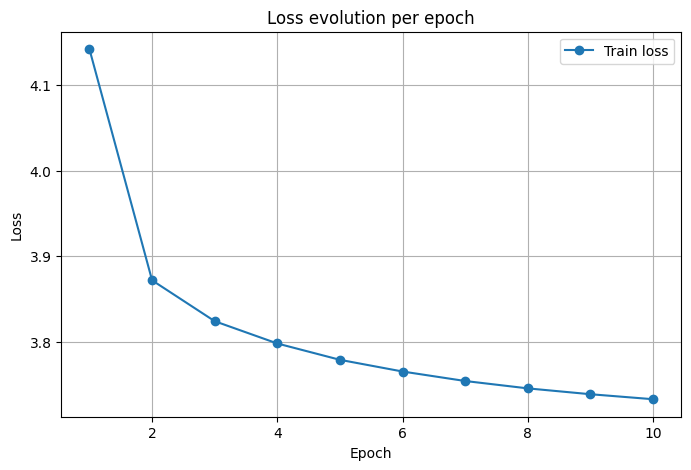

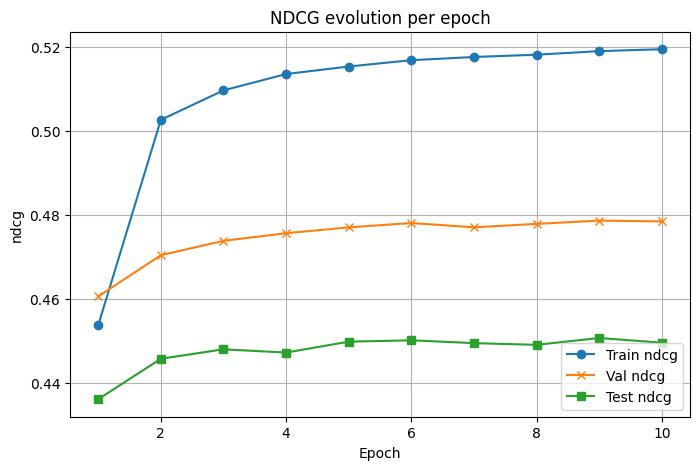

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# history_log contains: (epoch, step, loss, score)
df_log = pd.DataFrame(history_log, columns=["epoch", "step", "loss", "score"])

df_epoch = df_log.groupby("epoch")[["loss", "score"]].mean().reset_index()
df_epoch["val_score"] = val_curve[:len(df_epoch)]
df_epoch["test_score"] = test_curve[:len(df_epoch)]

display(df_epoch)

plt.figure(figsize=(8,5))
plt.plot(df_epoch["epoch"], df_epoch["loss"], marker="o", label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss evolution per epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(df_epoch["epoch"], df_epoch["score"], marker="o", label=f"Train {eval_metric}")
plt.plot(df_epoch["epoch"], df_epoch["val_score"], marker="x", label=f"Val {eval_metric}")
plt.plot(df_epoch["epoch"], df_epoch["test_score"], marker="s", label=f"Test {eval_metric}")
plt.xlabel("Epoch")
plt.ylabel(eval_metric)
plt.title(f"{eval_metric.upper()} evolution per epoch")
plt.legend()
plt.grid(True)
plt.show()